2. Alternative or complementary methods
Pearson assumes linearity and no strong outliers. For robustness, you might also compute:
- Spearman’s rank correlation (method='spearman' in pandas) – detects monotonic but non-linear relationships.
- Kendall’s tau – more conservative, less sensitive to outliers.
- Partial correlations – control for other variables (can reveal hidden relationships).
- Mutual Information – captures non-linear dependencies.





3. Feature usefulness / prediction power
- Correlation only shows linear association, not predictive performance. If your goal is prediction:
- Univariate feature selection: sklearn.feature_selection.SelectKBest with f_regression or mutual_info_regression.

Model-based importance:
- Train a simple model (e.g., Random Forest, Lasso) and see which features get high importance/coefficients.

- Permutation importance: Shuffle a feature and see how predictive performance drops.

- Recursive Feature Elimination (RFE): Iteratively remove the least important features.




1. Possible additional features worth exploring
In addition to your current four:

Time–frequency domain (still interpretable):
Wavelet packet energy / entropy — more sensitive to non-stationary changes than STFT in dynamic contractions.

Teager–Kaiser energy operator — good for detecting instantaneous energy changes in EMG bursts.

Hjorth parameters (activity, mobility, complexity) — robust in some muscle fatigue studies.

Coefficient of variation of RMS / power across cycles — could capture cycle-to-cycle fatigue effects.

Nonlinear features:
Fractal dimension (e.g., Higuchi, Katz) — complexity drop with fatigue.

Approximate entropy / sample entropy — decreased variability with fatigue.

Recurrence quantification metrics — sometimes sensitive in cyclic motor tasks.

Inter-channel / bilateral features:
Ratios LD/PD for MNF, MDF, RMS — might be more robust to inter-subject variation.

Coherence between muscle groups (if multiple EMG channels are available).

Loaded data shape: (59, 45)
Prepared 1163 data points


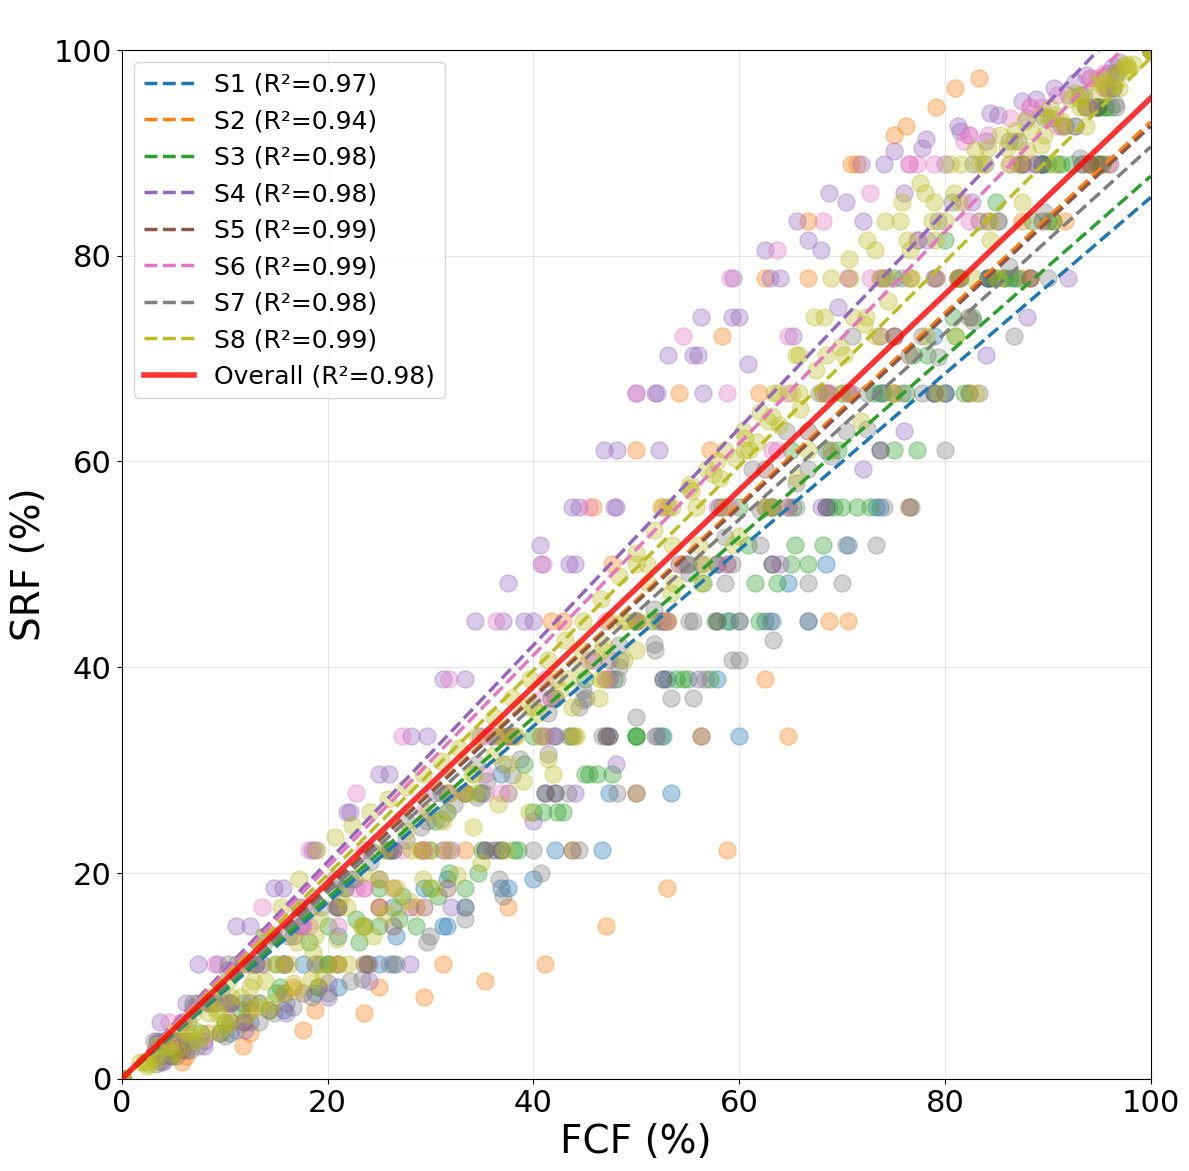

✅ Created single figure successfully!
📊 Processed 8 subjects: ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8']
📈 Overall fit: Slope=0.953, R²=0.977


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy.optimize import curve_fit

# Set up matplotlib
plt.style.use('default')

# Update this path to your Excel file
EXCEL_PATH = r"C:\Users\ezior\Downloads\SRF.xlsx"

# Load data
data = pd.read_excel(EXCEL_PATH)
print(f"Loaded data shape: {data.shape}")

# Filter out 'Circ' columns (include_circ=False)
filtered_columns = [col for col in data.columns if 'Circ' not in str(col)]
data = data[filtered_columns]

# Enhanced label smoothing function
def apply_label_smoothing(values):
    """Apply enhanced label smoothing for repeated values"""
    smoothed = values.copy().astype(float)
    i = 0
    while i < len(values):
        current_val = values[i]
        # Count consecutive repeats
        count = 1
        j = i + 1
        while j < len(values) and values[j] == current_val:
            count += 1
            j += 1
        
        # Apply smoothing if repeated
        if count > 1:
            step = 1.0 / count
            for k in range(count):
                smoothed[i + k] = float(current_val) + (k * step)
        i = j
    return smoothed

# Prepare plotting data
plot_data_list = []

for col in data.columns:
    col_str = str(col)
    
    # Extract subject info
    subject_match = re.search(r'S\d+', col_str)
    subject = subject_match.group() if subject_match else 'Unknown'
    
    # Get SRF values (remove NaN)
    srf_values = data[col].dropna().values
    if len(srf_values) == 0:
        continue
    
    # Apply label smoothing
    srf_values = apply_label_smoothing(srf_values)
    
    # Create completion percentage
    completion_pct = np.linspace(0, 100, len(srf_values))
    
    # Force start from zero
    srf_offset = srf_values[0]
    srf_values = srf_values - srf_offset
    comp_offset = completion_pct[0]
    completion_pct = completion_pct - comp_offset
    if len(completion_pct) > 1:
        max_comp = completion_pct[-1]
        if max_comp > 0:
            completion_pct = (completion_pct / max_comp) * 100
    
    # Normalize to 0-100 percent
    if srf_values.max() != srf_values.min():
        srf_values = ((srf_values - srf_values.min()) / 
                     (srf_values.max() - srf_values.min())) * 100
    
    # Store data
    for i in range(len(srf_values)):
        plot_data_list.append({
            'completion_percentage': completion_pct[i],
            'srf_value': srf_values[i],
            'subject': subject,
            'column_name': col_str
        })

# Convert to DataFrame
plot_data = pd.DataFrame(plot_data_list)
print(f"Prepared {len(plot_data)} data points")

# Get unique subjects and create colors (excluding red)
unique_subjects = sorted(plot_data['subject'].unique())
# Get tab10 colors but skip red (index 3)
all_colors = plt.cm.tab10(np.arange(10))
non_red_colors = [all_colors[i] for i in range(10) if i != 3]  # Skip index 3 (red)
# Repeat colors if we have more subjects than colors
while len(non_red_colors) < len(unique_subjects):
    non_red_colors.extend(non_red_colors)
color_dict = dict(zip(unique_subjects, non_red_colors[:len(unique_subjects)]))

# Linear fitting function (through origin)
def linear_fit(x, slope):
    return slope * x

# Calculate overall fit for overlay
x_all = plot_data['completion_percentage'].values
y_all = plot_data['srf_value'].values

# Remove NaN values
mask = ~(np.isnan(x_all) | np.isnan(y_all))
x_all = x_all[mask]
y_all = y_all[mask]

# Calculate overall slope and R²
overall_slope = 0
overall_r2 = 0
if len(x_all) > 1 and np.sum(x_all**2) != 0:
    overall_slope = np.sum(x_all * y_all) / np.sum(x_all**2)
    y_pred = overall_slope * x_all
    ss_res = np.sum((y_all - y_pred)**2)
    ss_tot = np.sum(y_all**2)
    overall_r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

# === MAIN FIGURE: Individual Fits + Overall Overlay ===
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# Fit individual subjects
for subject in unique_subjects:
    subject_data = plot_data[plot_data['subject'] == subject]
    
    if len(subject_data) > 1:
        x_subj = subject_data['completion_percentage'].values
        y_subj = subject_data['srf_value'].values
        
        # Remove NaN values
        mask = ~(np.isnan(x_subj) | np.isnan(y_subj))
        x_subj = x_subj[mask]
        y_subj = y_subj[mask]
        
        if len(x_subj) > 1:
            color = color_dict[subject]
            
            # Plot subject data
            ax.scatter(x_subj, y_subj, color=color, alpha=0.35, s=150)
            
            # Fit linear curve for this subject
            if np.sum(x_subj**2) != 0:
                subj_slope = np.sum(x_subj * y_subj) / np.sum(x_subj**2)
                
                # Calculate R² for subject
                y_pred_subj = subj_slope * x_subj
                ss_res_subj = np.sum((y_subj - y_pred_subj)**2)
                ss_tot_subj = np.sum(y_subj**2)
                r2_subj = 1 - (ss_res_subj / ss_tot_subj) if ss_tot_subj != 0 else 0
                
                # Plot subject fit
                x_smooth_subj = np.linspace(0, x_subj.max(), 50)
                y_smooth_subj = subj_slope * x_smooth_subj
                
                ax.plot(x_smooth_subj, y_smooth_subj, color=color, 
                       linewidth=2.5, linestyle='--',
                       label=f'{subject} (R²={r2_subj:.2f})')

# Overlay overall fit
if overall_slope > 0:
    x_smooth_overall = np.linspace(0, 100, 100)
    y_smooth_overall = overall_slope * x_smooth_overall
    ax.plot(x_smooth_overall, y_smooth_overall, color='red', 
           linewidth=4.0, label=f'Overall (R²={overall_r2:.2f})', 
           alpha=0.8, zorder=10)

ax.set_title(" ", fontsize=30, fontweight='bold')
ax.set_xlabel("FCF (%)", fontsize=28)
ax.set_ylabel("SRF (%)", fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=18, loc='upper left')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Set custom ticks
x_ticks = np.arange(0, 101, 20)
y_ticks = np.arange(0, 101, 20)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_box_aspect(1)

# Apply tight layout
fig.tight_layout()

# Show plot
plt.show()

print(f"✅ Created single figure successfully!")
print(f"📊 Processed {len(unique_subjects)} subjects: {unique_subjects}")
print(f"📈 Overall fit: Slope={overall_slope:.3f}, R²={overall_r2:.3f}")

In [79]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import re
import warnings
warnings.filterwarnings('ignore')


class SimpleDatasetManager:
    """Simple dataset manager for loading and combining CSV files"""
    
    def __init__(self, data_directory: str = None):
        self.data_directory = data_directory
        self.data = None
        self.subjects = []
        self.available_features = []
        
    def load_all_data(self, pattern: str = "*.csv", target_column: str = 'completion_percentage'):
        """Load and combine all CSV files from directory"""
        if not self.data_directory:
            raise ValueError("Data directory not specified")
        
        csv_files = glob.glob(str(Path(self.data_directory) / pattern))
        if not csv_files:
            print(f"No files found matching pattern '{pattern}'")
            return
        
        # Group files by subject
        subject_files = {}
        for file_path in csv_files:
            file_name = Path(file_path).stem
            subject_match = re.search(r'S(\d+)', file_name, re.IGNORECASE)
            
            if subject_match:
                subject_num = int(subject_match.group(1))
                if subject_num not in subject_files:
                    subject_files[subject_num] = []
                subject_files[subject_num].append({
                    'path': file_path,
                    'name': file_name,
                    'type': 'HD' if 'HD' in file_name.upper() else 'MD' if 'MD' in file_name.upper() else 'Unknown'
                })
        
        # Load and combine data
        all_dataframes = []
        for subject_num, files in sorted(subject_files.items()):
            subject_dataframes = []
            
            for file_info in files:
                try:
                    df = pd.read_csv(file_info['path'])
                    
                    if 'subject_id' in df.columns:
                        df['subject_id'] = subject_num
                    else:
                        df['subject_id'] = subject_num
                    
                    # Create unique trial indices
                    trial_match = re.search(r'Trial_(\d+)', file_info['name'], re.IGNORECASE)
                    if trial_match:
                        original_trial = int(trial_match.group(1))
                        file_type = file_info['type']
                        
                        if file_type == 'MD':
                            unique_trial_index = original_trial + 100
                        else:
                            unique_trial_index = original_trial
                        
                        df['trial_index'] = unique_trial_index
                        df['original_trial_number'] = original_trial
                    
                    df['file_type'] = file_info['type']
                    df['source_file'] = file_info['name']
                    subject_dataframes.append(df)
                    
                except Exception as e:
                    print(f"Failed to load {file_info['name']}: {e}")
            
            if subject_dataframes:
                subject_combined = pd.concat(subject_dataframes, ignore_index=True)
                all_dataframes.append(subject_combined)
        
        if not all_dataframes:
            print("No data loaded successfully")
            return
        
        self.data = pd.concat(all_dataframes, ignore_index=True)
        
        # Check required columns
        required_cols = ['subject_id', 'trial_index', 'cycle_index']
        missing_cols = [col for col in required_cols if col not in self.data.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return
        
        if target_column not in self.data.columns:
            print(f"Target column '{target_column}' not found")
            return
        
        self._update_metadata()
        
    def _update_metadata(self):
        """Update metadata about the dataset"""
        if self.data is None:
            return
        
        self.subjects = sorted(self.data['subject_id'].unique())
        
        metadata_cols = ['subject_id', 'trial_index', 'cycle_index', 'completion_percentage', 
                        'subjective_fatigue', 'motion_type', 'damping_level', 'dataset_source',
                        'file_type', 'source_file']
        self.available_features = [col for col in self.data.columns if col not in metadata_cols]
    
    def get_data_for_subjects(self, subjects=None):
        """Get data for specific subjects"""
        if self.data is None:
            print("No data loaded")
            return pd.DataFrame()
        
        if subjects is None:
            return self.data.copy()
        
        if not isinstance(subjects, list):
            subjects = [subjects]
        
        return self.data[self.data['subject_id'].isin(subjects)]
    
    def get_feature_names(self, feature_type='all'):
        """Get list of available feature names"""
        if not self.available_features:
            return []
        
        features = self.available_features.copy()
        
        if feature_type == 'all':
            return features
        elif feature_type == 'original':
            return [f for f in features if not f.endswith('_pct_change')]
        elif feature_type == 'pct_change':
            return [f for f in features if f.endswith('_pct_change')]
        elif feature_type == 'rms':
            return [f for f in features if 'rms' in f.lower()]
        elif feature_type == 'channel':
            return [f for f in features if f.startswith('ch')]
        else:
            return features
    
    
    def summary(self):
        """Print basic dataset summary"""
        if self.data is None:
            print("No data loaded")
            return
        
        print(f"Dataset: {self.data.shape}")
        print(f"Subjects: {self.subjects}")




# Example usage
if __name__ == "__main__":
    manager = SimpleDatasetManager(r"C:\Users\ezior\Downloads\EMG_ML_Features")
    manager.load_all_data("*.csv")
    manager.summary()


Dataset: (1168, 42)
Subjects: [1, 2, 3, 4, 5, 6, 7, 8]


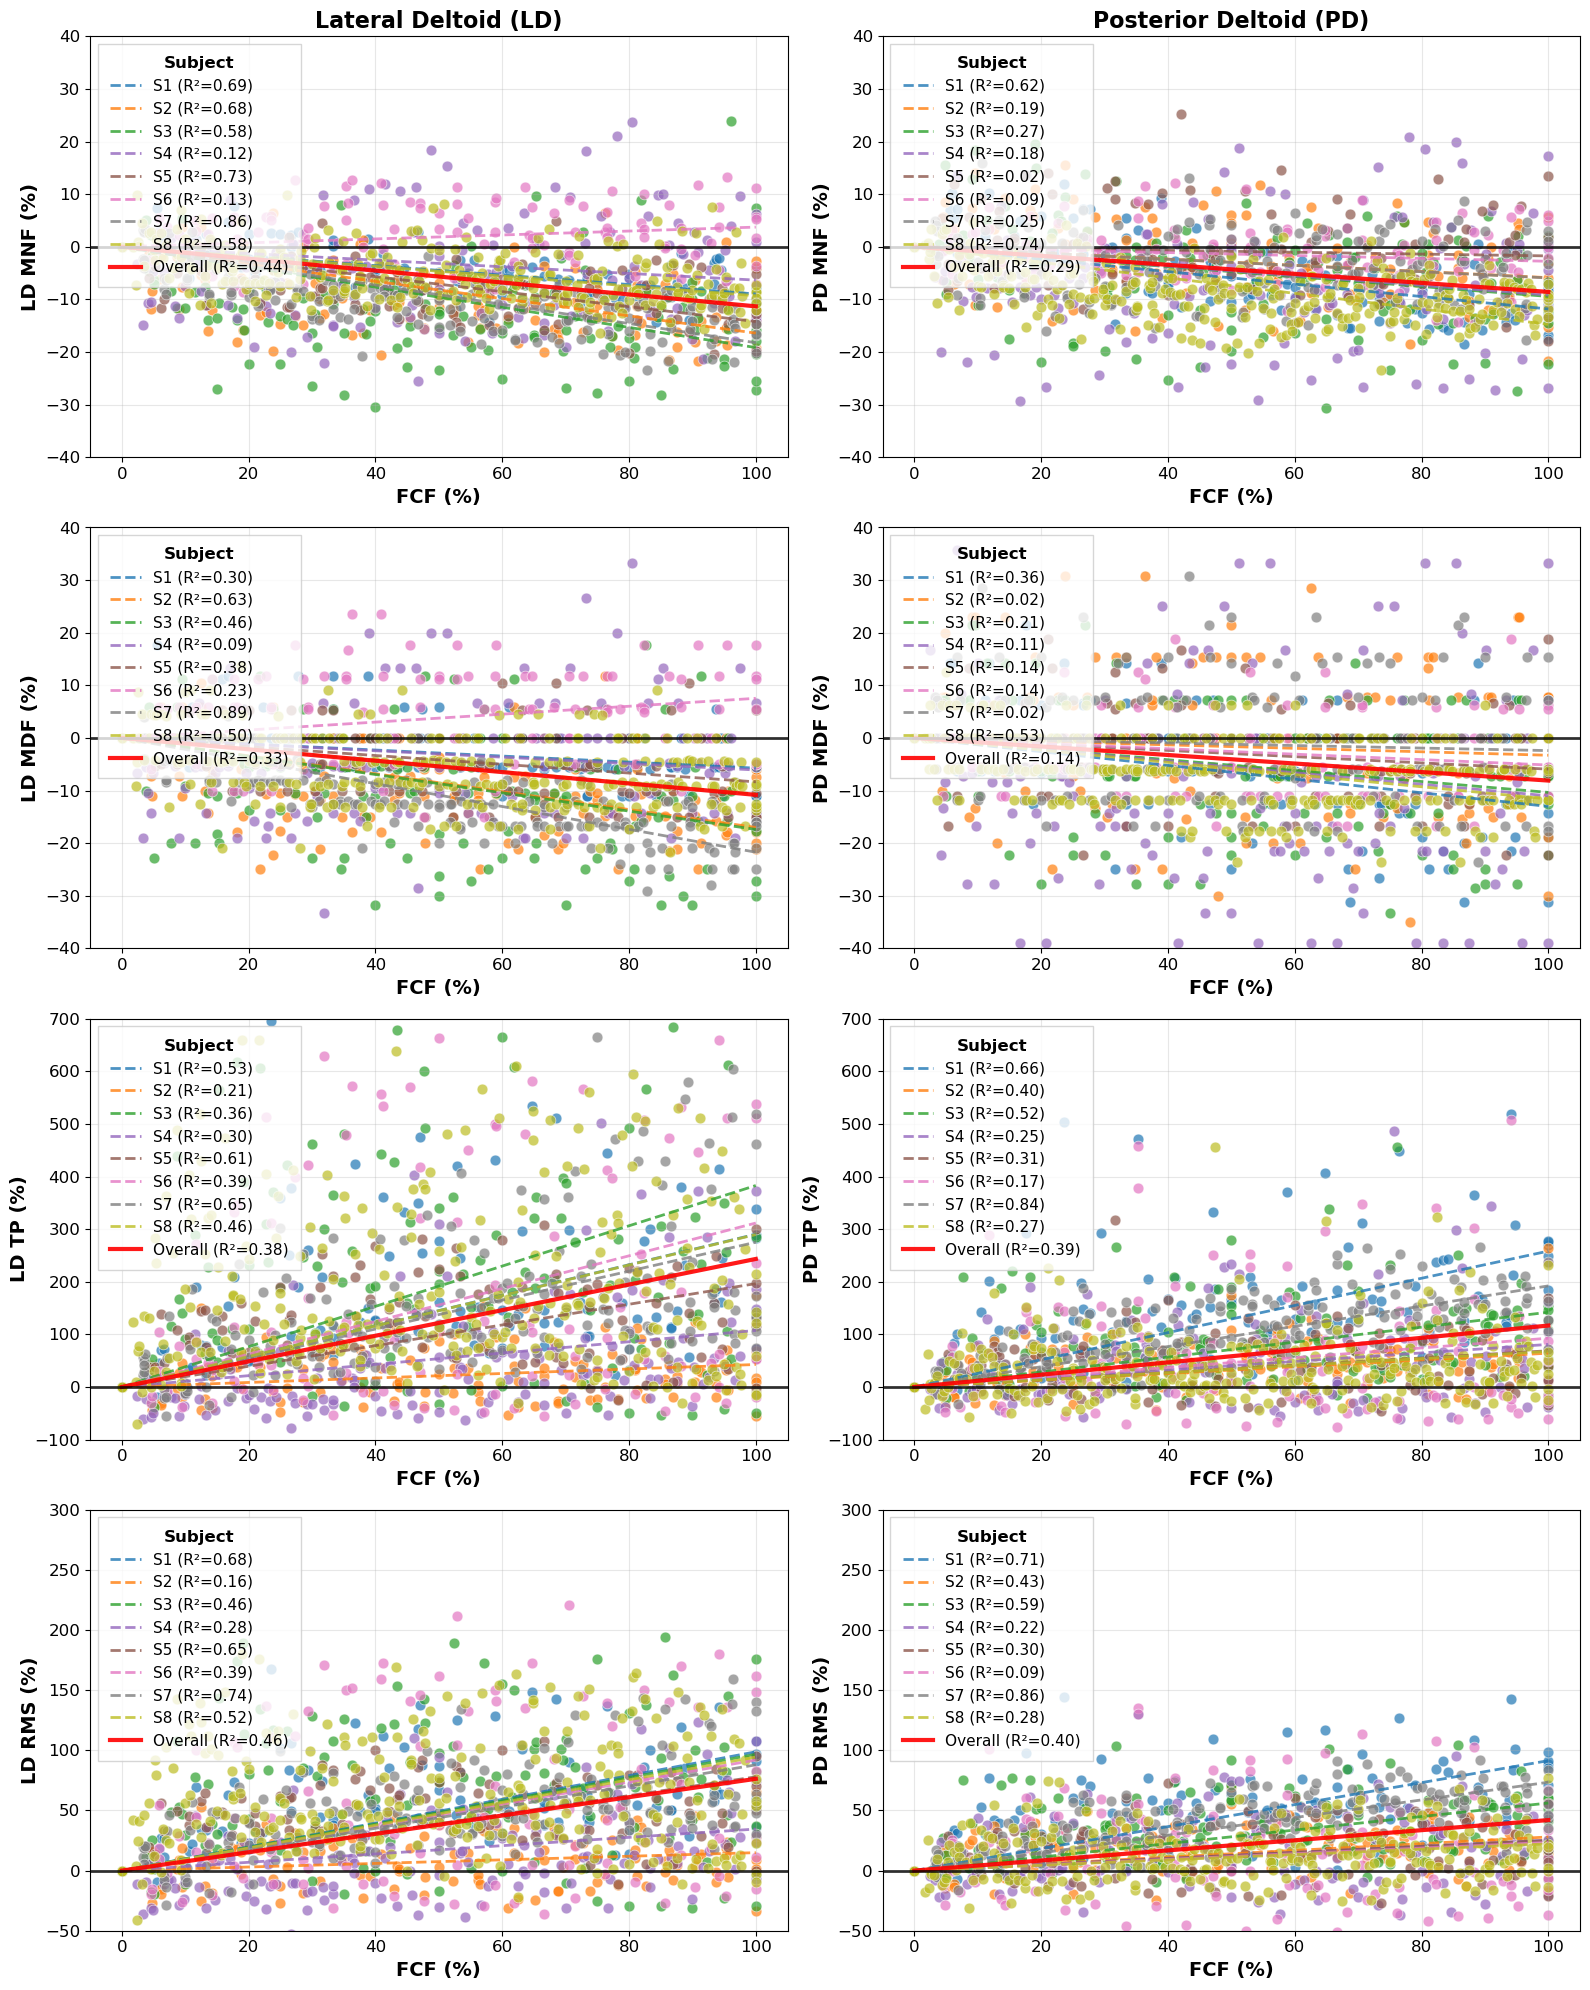

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from typing import List, Dict, Tuple

def plot_features_grid(data_manager, plot_configs: List[Dict], 
                      subjects=None,
                      x_axis: str = 'completion_percentage',
                      xlabel: str = 'FCF (%)',
                      figsize: Tuple[int, int] = (16, 20),
                      n_rows: int = 4, n_cols: int = 2,
                      save_path: str = None,
                      show_plot: bool = True,
                      suptitle: str = None):
    """Simple grid plot of EMG features with enhanced font sizes and legend."""
    
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return
    
    # Setup colors (excluding red for subjects, original tab10 style)
    subjects = data['subject_id'].unique()
    color_dict = _create_color_dict_no_red(subjects, 'tab10')
    
    # Default styles from original
    zero_line_style = {'color': 'black', 'linewidth': 2, 'linestyle': '-', 'alpha': 0.8}
    fit_line_style = {'color': 'red', 'linewidth': 3, 'linestyle': '-', 'alpha': 0.9}
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    for i, config in enumerate(plot_configs[:len(axes)]):
        if 'feature' not in config:
            continue
            
        feature = config['feature']
        ax = axes[i]
        
        # Check feature availability
        available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
        if feature not in available_features:
            print(f"Invalid feature '{feature}' for subplot {i+1}")
            ax.text(0.5, 0.5, f"Invalid feature:\n{feature}", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f"Subplot {i+1}: ERROR")
            continue
        
        all_x_clean, all_y_clean = [], []
        
        # Plot each subject
        for subject in subjects:
            subject_data = data[data['subject_id'] == subject].sort_values(x_axis)
            x_vals = subject_data[x_axis].values
            y_vals = subject_data[feature].values
            
            # Remove NaN
            mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
            x_vals, y_vals = x_vals[mask], y_vals[mask]
            
            if len(x_vals) == 0:
                continue
            
            # Apply outlier rejection if specified in config
            if config.get('outlier_rejection', False) and len(x_vals) > 3:
                x_vals, y_vals, _ = _remove_outliers(x_vals, y_vals, config.get('outlier_z_threshold', 3.0))
                if len(x_vals) == 0:
                    continue
                    
            all_x_clean.extend(x_vals)
            all_y_clean.extend(y_vals)
            
            color = color_dict[subject]
            
            # Scatter plot with larger marker size
            ax.scatter(x_vals, y_vals, color=color, alpha=0.7, s=60, 
                      edgecolors='white', linewidth=0.5)
            
            # Individual trend line (dashed) - force zero intercept
            if len(x_vals) > 1:
                slope = np.sum(x_vals * y_vals) / np.sum(x_vals**2)
                y_pred = slope * x_vals
                ss_res = np.sum((y_vals - y_pred)**2)
                ss_tot = np.sum(y_vals**2)
                r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
                
                # Round R² to 2 decimal places
                ax.plot(x_vals, y_pred, color=color, linestyle='--', linewidth=2, alpha=0.8,
                       label=f'S{subject} (R²={r2:.2f})')
        
        # Overall trend line (solid red)
        if len(all_x_clean) > 1:
            all_x, all_y = np.array(all_x_clean), np.array(all_y_clean)
            slope = np.sum(all_x * all_y) / np.sum(all_x**2)
            x_smooth = np.linspace(all_x.min(), all_x.max(), 100)
            y_smooth = slope * x_smooth
            
            y_pred = slope * all_x
            ss_res = np.sum((all_y - y_pred)**2)
            ss_tot = np.sum(all_y**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            # Round R² to 2 decimal places
            ax.plot(x_smooth, y_smooth, color='red', linewidth=3, linestyle='-', alpha=0.9,
                   label=f'Overall (R²={r2:.2f})')
        
        # Zero line
        ax.axhline(y=0, color=zero_line_style['color'], linewidth=zero_line_style['linewidth'], 
                  linestyle=zero_line_style['linestyle'], alpha=zero_line_style['alpha'])
        
        # Enhanced formatting with larger font sizes
        ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
        ax.set_ylabel(config.get('ylabel', feature.replace('_', ' ').title()), fontsize=14, fontweight='bold')
        
        # Title only on first row with larger font
        if i < n_cols:
            ax.set_title(config.get('title', feature.replace('_', ' ').title()), fontsize=16, fontweight='bold')
        
        # Apply custom y-axis settings
        if 'ylim' in config:
            ax.set_ylim(config['ylim'])
        if 'yscale' in config:
            ax.set_yscale(config['yscale'])
            
        # Enhanced tick parameters
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, alpha=0.3)
        
        # Enhanced legend with larger font and better spacing
        legend = ax.legend(title='Subject', loc='upper left', fontsize=11, 
                          title_fontsize=12, framealpha=0.8,
                          fancybox=False, shadow=False, 
                          borderpad=0.8, columnspacing=1.2, 
                          handletextpad=0.8)
        # Make legend title bold
        legend.get_title().set_fontweight('bold')
    
    # Hide unused subplots
    for i in range(len(plot_configs), len(axes)):
        axes[i].set_visible(False)
    
    # Add overall title with larger font
    if suptitle:
        fig.suptitle(suptitle, fontsize=18, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    if suptitle:
        plt.subplots_adjust(top=0.95)
    
    # Save plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig, axes

def _remove_outliers(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score for both x and y values."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask], outlier_mask

def _create_color_dict_no_red(unique_groups, color_palette):
    """Create color dictionary excluding red colors (reserved for overall trend)."""
    if color_palette == 'tab10':
        # Get tab10 colors but exclude red (index 3)
        all_colors = plt.cm.tab10(np.arange(10))
        colors = [color for i, color in enumerate(all_colors) if i != 3]  # Remove red
    elif color_palette == 'Set1':
        # Get Set1 colors but exclude red-ish colors
        all_colors = plt.cm.Set1(np.arange(9))
        colors = [color for i, color in enumerate(all_colors) if i not in [0, 5]]  # Remove red and pink
    else:
        # For other palettes, try to exclude red-ish colors
        all_colors = plt.cm.get_cmap(color_palette)(np.linspace(0, 1, len(unique_groups) + 3))
        colors = []
        for color in all_colors:
            # Skip colors that are too red (high red, low green and blue)
            if not (color[0] > 0.7 and color[1] < 0.5 and color[2] < 0.5):
                colors.append(color)
    
    # Ensure we have enough colors
    while len(colors) < len(unique_groups):
        colors.extend(colors)
    
    return dict(zip(unique_groups, colors[:len(unique_groups)]))

# Example usage with enhanced configurations
PLOT_CONFIGS = [
    {'feature': 'ch2_mean_power_freq_max_pct_change', 'title': 'Lateral Deltoid (LD)', 
     'ylim': (-40, 40), 'ylabel': 'LD MNF (%)'},
    {'feature': 'ch1_mean_power_freq_max_pct_change', 'title': 'Posterior Deltoid (PD)', 
     'ylim': (-40, 40), 'ylabel': 'PD MNF (%)'},
    {'feature': 'ch2_median_power_freq_max_pct_change', 'title': 'LD Median Power Frequency', 
     'ylim': (-40, 40), 'ylabel': 'LD MDF (%)'},
    {'feature': 'ch1_median_power_freq_max_pct_change', 'title': 'PD Median Power Frequency', 
     'ylim': (-40, 40), 'ylabel': 'PD MDF (%)'},
    {'feature': 'ch2_total_power_max_pct_change', 'ylim': (-100, 700), 'ylabel': 'LD TP (%)'},
    {'feature': 'ch1_total_power_max_pct_change', 'ylim': (-100, 700), 'ylabel': 'PD TP (%)'},
    {'feature': 'ch2_rms_max_pct_change', 'ylim': (-50, 300), 'ylabel': 'LD RMS (%)', 'outlier_rejection': True},
    {'feature': 'ch1_rms_max_pct_change', 'ylim': (-50, 300), 'ylabel': 'PD RMS (%)', 'outlier_rejection': True},
]

# Usage:
fig, axes = plot_features_grid(manager, PLOT_CONFIGS)

Analysis based on 8 subjects

R² STATISTICS SUMMARY
Feature                   Mean R²    Std R²     Red Line R²  Difference Diff %    
--------------------------------------------------------------------------------------------------------------
LD MNF                    0.549      0.274      0.436        0.112      25.75     
PD MNF                    0.293      0.252      0.295        -0.001     -0.47     
LD MDF                    0.435      0.248      0.326        0.109      33.33     
PD MDF                    0.190      0.177      0.143        0.047      32.89     
LD TP                     0.440      0.153      0.380        0.060      15.87     
PD TP                     0.427      0.230      0.390        0.037      9.45      
LD RMS                    0.485      0.205      0.458        0.027      5.85      
PD RMS                    0.435      0.264      0.401        0.034      8.60      
------------------------------------------------------------------------------------------

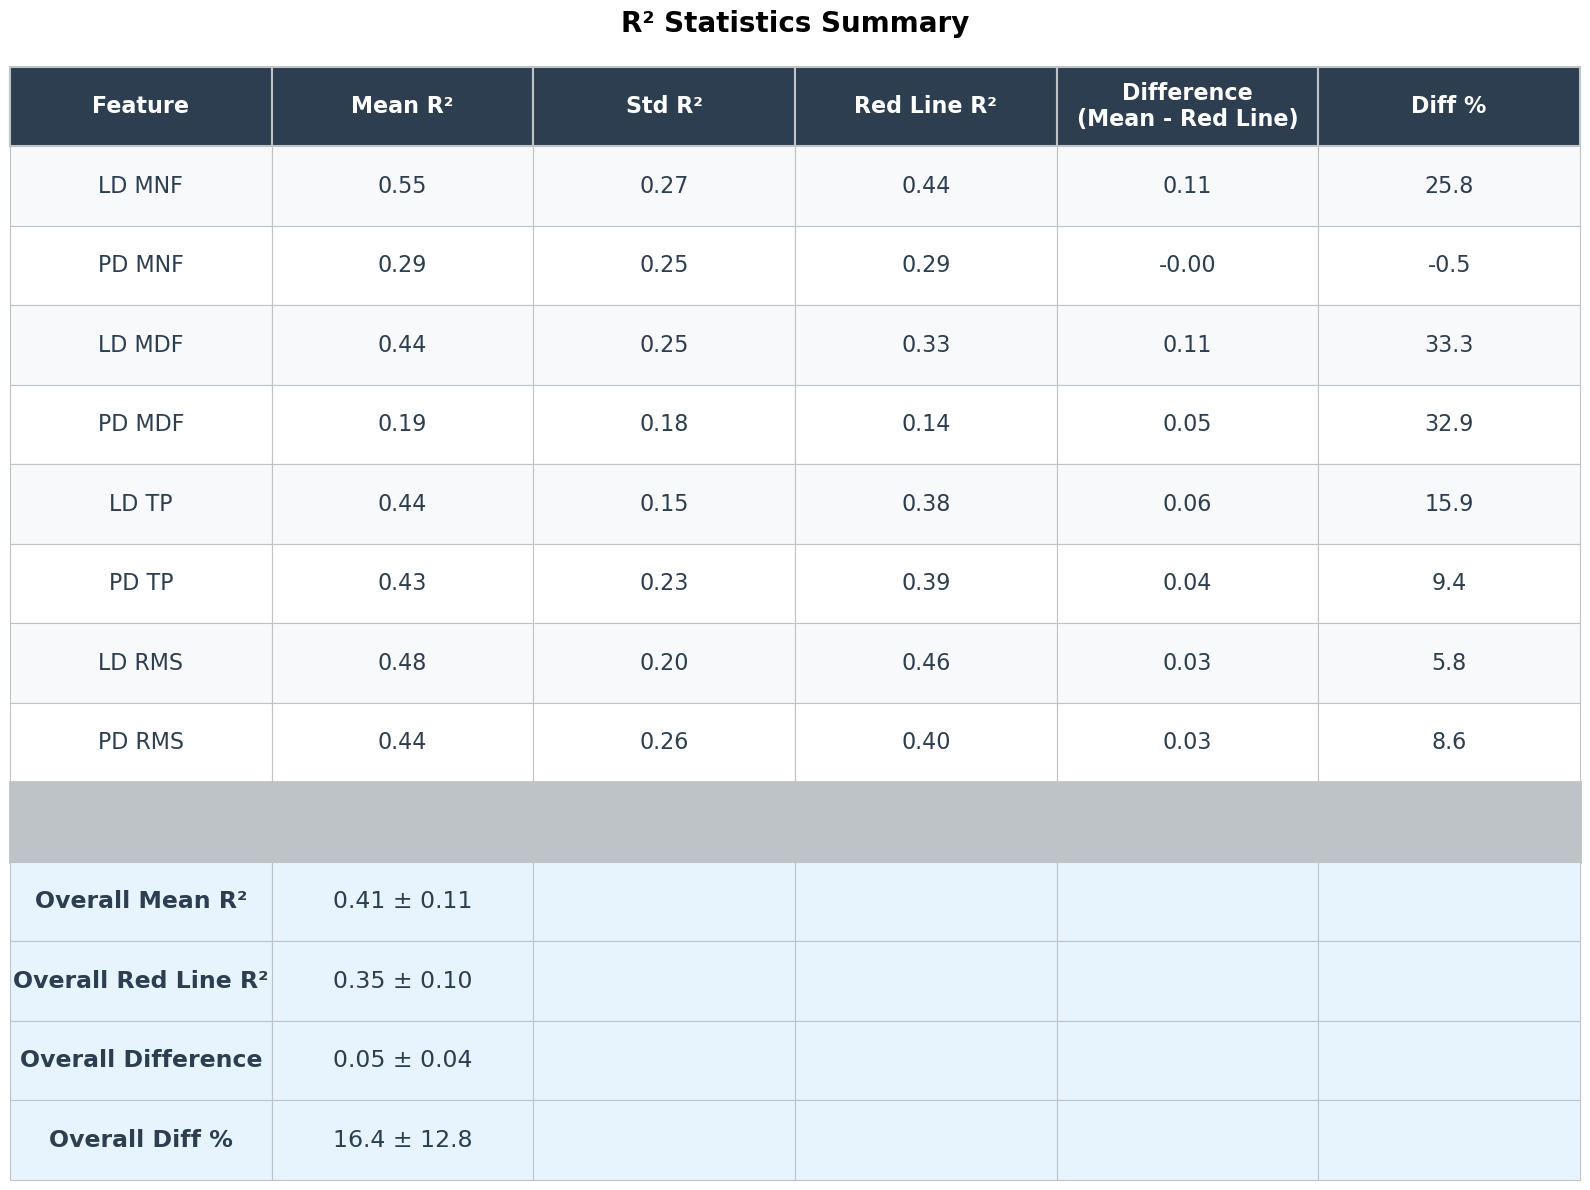

In [81]:
import pandas as pd
import numpy as np
from scipy import stats
from typing import List, Dict, Optional, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.table import Table

def calculate_r2_statistics(data_manager, plot_configs: List[Dict], 
                           subjects=None,
                           x_axis: str = 'completion_percentage',
                           outlier_z_threshold: float = 3.0) -> pd.DataFrame:
    """
    Calculate R² statistics (mean and std) for each feature across all subjects,
    plus the overall R² using all points together (Red Line R²).
    
    Parameters:
    -----------
    data_manager : DataManager object
        The data manager containing the dataset
    plot_configs : List[Dict]
        List of plot configuration dictionaries containing 'feature' keys
    subjects : list, optional
        List of subjects to include. If None, uses all subjects
    x_axis : str
        The x-axis variable (default: 'completion_percentage')
    outlier_z_threshold : float
        Z-score threshold for outlier removal (default: 3.0)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: Feature, Mean_R2, Std_R2, N_Subjects, Red_Line_R2, R2_Difference, R2_Diff_Percent
    """
    
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return pd.DataFrame()
    
    subjects_list = data['subject_id'].unique()
    results = []
    
    for config in plot_configs:
        if 'feature' not in config:
            continue
            
        feature = config['feature']
        
        # Check feature availability
        available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
        if feature not in available_features:
            print(f"Invalid feature '{feature}' - skipping")
            continue
        
        subject_r2_values = []
        all_x_vals = []
        all_y_vals = []
        
        # Calculate R² for each subject and collect all points
        for subject in subjects_list:
            subject_data = data[data['subject_id'] == subject].sort_values(x_axis)
            x_vals = subject_data[x_axis].values
            y_vals = subject_data[feature].values
            
            # Remove NaN values
            mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
            x_vals, y_vals = x_vals[mask], y_vals[mask]
            
            if len(x_vals) < 2:  # Need at least 2 points for regression
                continue
            
            # Apply outlier rejection if specified in config
            if config.get('outlier_rejection', False):
                x_vals, y_vals = _remove_outliers_for_r2(x_vals, y_vals, outlier_z_threshold)
                if len(x_vals) < 2:
                    continue
            
            # Calculate R² with forced zero intercept (as in original code)
            slope = np.sum(x_vals * y_vals) / np.sum(x_vals**2)
            y_pred = slope * x_vals
            ss_res = np.sum((y_vals - y_pred)**2)
            ss_tot = np.sum(y_vals**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            subject_r2_values.append(r2)
            
            # Collect all points for Red Line R²
            all_x_vals.extend(x_vals)
            all_y_vals.extend(y_vals)
        
        # Calculate Red Line R² (all points together)
        red_line_r2 = 0
        if len(all_x_vals) > 1:
            all_x_vals = np.array(all_x_vals)
            all_y_vals = np.array(all_y_vals)
            slope_all = np.sum(all_x_vals * all_y_vals) / np.sum(all_x_vals**2)
            y_pred_all = slope_all * all_x_vals
            ss_res_all = np.sum((all_y_vals - y_pred_all)**2)
            ss_tot_all = np.sum(all_y_vals**2)
            red_line_r2 = 1 - (ss_res_all / ss_tot_all) if ss_tot_all != 0 else 0
        
        # Calculate individual subject statistics
        if len(subject_r2_values) > 0:
            mean_r2 = np.mean(subject_r2_values)
            std_r2 = np.std(subject_r2_values, ddof=1) if len(subject_r2_values) > 1 else 0
            n_subjects = len(subject_r2_values)
            
            # Get feature display name with proper channel mapping
            display_name = _get_feature_display_name(feature, config)
            
            # Calculate difference between Mean R² and Red Line R²
            r2_difference = mean_r2 - red_line_r2
            
            # Calculate percentage difference: (Mean - Red Line) / Red Line * 100
            # Handle division by zero case
            if red_line_r2 != 0:
                r2_diff_percentage = (r2_difference / abs(red_line_r2)) * 100
            else:
                r2_diff_percentage = np.inf if r2_difference > 0 else (-np.inf if r2_difference < 0 else 0)
            
            results.append({
                'Feature': display_name,
                'Feature_Code': feature,
                'Mean_R2': mean_r2,
                'Std_R2': std_r2,
                'N_Subjects': n_subjects,
                'Red_Line_R2': red_line_r2,
                'R2_Difference': r2_difference,
                'R2_Diff_Percent': r2_diff_percentage
            })
        else:
            print(f"No valid data found for feature '{feature}'")
    
    # Create DataFrame
    df = pd.DataFrame(results)
    
    return df

def _get_feature_display_name(feature: str, config: Dict) -> str:
    """
    Generate proper display name for features with correct channel mapping.
    Ch1 = PD (Posterior Deltoid), Ch2/Ch4 = LD (Lateral Deltoid)
    """
    # Use config title if provided, but remove Max/Min
    if 'title' in config:
        title = config['title']
        # Remove "Max" and "Min" from the title
        title = title.replace(' Max', '').replace(' Min', '')
        return title
    
    # Parse feature name for automatic naming
    feature_lower = feature.lower()
    
    # Determine muscle
    if 'ch1' in feature_lower:
        muscle = 'PD'
    elif 'ch2' in feature_lower or 'ch4' in feature_lower:
        muscle = 'LD'
    else:
        muscle = 'Unknown'
    
    # Determine feature type
    if 'mean_power_freq' in feature_lower or 'mnf' in feature_lower:
        feature_type = 'MNF'
    elif 'median_power_freq' in feature_lower or 'mdf' in feature_lower:
        feature_type = 'MDF'
    elif 'total_power' in feature_lower:
        feature_type = 'TP'
    elif 'rms' in feature_lower:
        feature_type = 'RMS'
    else:
        # Fallback to cleaned feature name
        feature_type = feature.replace('_', ' ').title()
    
    # Don't determine window (min/max) anymore - just return muscle + feature type
    return f"{muscle} {feature_type}"

def _remove_outliers_for_r2(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score for both x and y values."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask]

def print_r2_table(df: pd.DataFrame, decimals: int = 3):
    """
    Print a nicely formatted table of R² statistics including Red Line R².
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame from calculate_r2_statistics
    decimals : int
        Number of decimal places to display (default: 3)
    """
    if df.empty:
        print("No data to display")
        return
    
    # Print N subjects info
    n_subjects_info = df['N_Subjects'].iloc[0] if len(df) > 0 else 0
    print(f"Analysis based on {n_subjects_info} subjects")
    
    print("\n" + "="*110)
    print("R² STATISTICS SUMMARY")
    print("="*110)
    print(f"{'Feature':<25} {'Mean R²':<10} {'Std R²':<10} {'Red Line R²':<12} {'Difference':<10} {'Diff %':<10}")
    print("-"*110)
    
    for _, row in df.iterrows():
        feature_name = row['Feature'][:22] + "..." if len(row['Feature']) > 25 else row['Feature']
        
        # Format percentage difference with special handling for infinity
        diff_percent = row['R2_Diff_Percent']
        if np.isinf(diff_percent):
            diff_percent_str = "inf" if diff_percent > 0 else "-inf"
        else:
            diff_percent_str = f"{diff_percent:.{decimals-1}f}"
        
        print(f"{feature_name:<25} {row['Mean_R2']:<10.{decimals}f} {row['Std_R2']:<10.{decimals}f} "
              f"{row['Red_Line_R2']:<12.{decimals}f} {row['R2_Difference']:<10.{decimals}f} {diff_percent_str:<10}")
    
    print("-"*110)
    print(f"Overall Mean R²: {df['Mean_R2'].mean():.{decimals}f} ± {df['Mean_R2'].std():.{decimals}f}")
    print(f"Overall Mean Red Line R²: {df['Red_Line_R2'].mean():.{decimals}f} ± {df['Red_Line_R2'].std():.{decimals}f}")
    print(f"Overall Mean Difference: {df['R2_Difference'].mean():.{decimals}f} ± {df['R2_Difference'].std():.{decimals}f}")
    
    # Calculate percentage statistics excluding infinite values
    finite_percentages = df['R2_Diff_Percent'][np.isfinite(df['R2_Diff_Percent'])]
    if len(finite_percentages) > 0:
        print(f"Overall Mean Diff %: {finite_percentages.mean():.{decimals-1}f} ± {finite_percentages.std():.{decimals-1}f}")
    print("="*110)

def save_r2_table(df: pd.DataFrame, filepath: str, decimals: int = 3):
    """
    Save R² statistics table to CSV file.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame from calculate_r2_statistics
    filepath : str
        Path to save the CSV file
    decimals : int
        Number of decimal places to round to (default: 3)
    """
    if df.empty:
        print("No data to save")
        return
    
    # Round numerical columns
    df_rounded = df.copy()
    df_rounded['Mean_R2'] = df_rounded['Mean_R2'].round(decimals)
    df_rounded['Std_R2'] = df_rounded['Std_R2'].round(decimals)
    df_rounded['Red_Line_R2'] = df_rounded['Red_Line_R2'].round(decimals)
    df_rounded['R2_Difference'] = df_rounded['R2_Difference'].round(decimals)
    # Round percentage but handle infinity values
    df_rounded['R2_Diff_Percent'] = df_rounded['R2_Diff_Percent'].apply(
        lambda x: round(x, decimals-1) if np.isfinite(x) else x
    )
    
    df_rounded.to_csv(filepath, index=False)
    print(f"R² statistics saved to: {filepath}")

# Key changes to make in your save_r2_table_image function:


def save_r2_table_image(df: pd.DataFrame, filepath: Optional[str] = None, decimals: int = 3, 
                       figsize: Tuple[float, float] = (16, 12), 
                       dpi: int = 300, title: str = "R² Statistics Summary",
                       color_scheme: str = 'modern', show_in_notebook: bool = False,
                       base_fontsize: int = 14):
    """
    Save R² statistics table as a high-quality image suitable for publications,
    or display it directly in Jupyter notebook.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame from calculate_r2_statistics
    filepath : str, optional
        Path to save the image file (supports .png, .pdf, .svg, .jpg).
        If None and show_in_notebook=True, only displays in notebook.
    decimals : int
        Number of decimal places to display (default: 3)
    figsize : Tuple[float, float]
        Figure size in inches (width, height)
    dpi : int
        Resolution for raster formats (default: 300)
    title : str
        Table title
    color_scheme : str
        Color scheme ('modern', 'classic', 'minimal', 'journal')
    show_in_notebook : bool
        If True, displays the table in Jupyter notebook cell (default: False)
    base_fontsize : int
        Base font size for table content (default: 14). Header will be +2, title will be +6
    """
    if df.empty:
        print("No data to save as image")
        return
    
    # Define color schemes
    color_schemes = {
        'modern': {
            'header_bg': '#2C3E50',
            'header_text': 'white',
            'row_even': '#F8F9FA',
            'row_odd': 'white',
            'text_color': '#2C3E50',
            'border_color': '#BDC3C7',
            'summary_bg': '#E8F4FD'
        },
        'classic': {
            'header_bg': '#34495E',
            'header_text': 'white',
            'row_even': '#F4F4F4',
            'row_odd': 'white',
            'text_color': 'black',
            'border_color': '#95A5A6',
            'summary_bg': '#D5DBDB'
        },
        'minimal': {
            'header_bg': '#95A5A6',
            'header_text': 'white',
            'row_even': '#FBFCFC',
            'row_odd': 'white',
            'text_color': '#2C3E50',
            'border_color': '#D5DBDB',
            'summary_bg': '#F8F9FA'
        },
        'journal': {
            'header_bg': 'black',
            'header_text': 'white',
            'row_even': '#F7F7F7',
            'row_odd': 'white',
            'text_color': 'black',
            'border_color': 'black',
            'summary_bg': '#EEEEEE'
        }
    }
    
    colors = color_schemes.get(color_scheme, color_schemes['modern'])
    
    # Print N subjects info before the table
    n_subjects_info = df['N_Subjects'].iloc[0] if len(df) > 0 else 0
    print(f"Analysis based on {n_subjects_info} subjects")
    
    # Prepare data for table (without N Subjects column) - UPDATED HEADER
    table_data = []
    headers = ['Feature', 'Mean R²', 'Std R²', 'Red Line R²', 'Difference\n(Mean - Red Line)', 'Diff %']
    
    for _, row in df.iterrows():
        # Format percentage difference with special handling for infinity
        diff_percent = row['R2_Diff_Percent']
        if np.isinf(diff_percent):
            diff_percent_str = "∞" if diff_percent > 0 else "-∞"
        else:
            diff_percent_str = f"{diff_percent:.1f}"
        
        formatted_row = [
            row['Feature'],
            f"{row['Mean_R2']:.2f}",
            f"{row['Std_R2']:.2f}",
            f"{row['Red_Line_R2']:.2f}",
            f"{row['R2_Difference']:.2f}",
            diff_percent_str
        ]
        table_data.append(formatted_row)
    
    # Calculate summary statistics
    finite_percentages = df['R2_Diff_Percent'][np.isfinite(df['R2_Diff_Percent'])]
    summary_data = [
        ['Overall Mean R²', f"{df['Mean_R2'].mean():.2f} ± {df['Mean_R2'].std():.2f}", '', '', '', ''],
        ['Overall Red Line R²', f"{df['Red_Line_R2'].mean():.2f} ± {df['Red_Line_R2'].std():.2f}", '', '', '', ''],
        ['Overall Difference', f"{df['R2_Difference'].mean():.2f} ± {df['R2_Difference'].std():.2f}", '', '', '', ''],
    ]
    
    if len(finite_percentages) > 0:
        summary_data.append(['Overall Diff %', f"{finite_percentages.mean():.1f} ± {finite_percentages.std():.1f}", '', '', '', ''])
    
    # Create figure and use matplotlib's table function
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    
    # Combine all data for the table
    all_data = [headers] + table_data + [[''] * len(headers)] + summary_data
    
    # Create table using matplotlib's table function
    table = ax.table(cellText=all_data[1:], colLabels=headers, 
                     cellLoc='center', loc='center', 
                     bbox=[0, 0, 1, 1])
    
    # UPDATED: Bigger font sizes but keep overall table size
    table.auto_set_font_size(False)
    table.set_fontsize(base_fontsize + 2)  # Make table numbers bigger (+2 from base)
    table.scale(1, 2.0)  # Keep original scale to maintain overall size
    
    # Style header row with bigger font
    header_fontsize = base_fontsize + 2
    for j in range(len(headers)):
        cell = table[(0, j)]
        cell.set_facecolor(colors['header_bg'])
        cell.set_text_props(weight='bold', color=colors['header_text'], 
                           fontsize=header_fontsize)
        cell.set_edgecolor(colors['border_color'])
        cell.set_linewidth(1.5)
    
    # Style data rows with bigger font for numbers
    for i in range(1, len(table_data) + 1):
        row_color = colors['row_even'] if (i-1) % 2 == 0 else colors['row_odd']
        for j in range(len(headers)):
            cell = table[(i, j)]
            cell.set_facecolor(row_color)
            cell.set_text_props(color=colors['text_color'], fontsize=base_fontsize + 2)  # Bigger data font
            cell.set_edgecolor(colors['border_color'])
            cell.set_linewidth(0.8)
    
    # Style separator row
    separator_idx = len(table_data) + 1
    for j in range(len(headers)):
        cell = table[(separator_idx, j)]
        cell.set_facecolor(colors['border_color'])
        cell.set_edgecolor(colors['border_color'])
        cell.set_linewidth(2)
    
    # Style summary rows with bigger font for numbers
    summary_fontsize = base_fontsize + 3  # Even bigger for summary
    for i in range(len(summary_data)):
        idx = separator_idx + 1 + i
        for j in range(len(headers)):
            cell = table[(idx, j)]
            cell.set_facecolor(colors['summary_bg'])
            cell.set_text_props(color=colors['text_color'], 
                               weight='bold' if j == 0 else 'normal',
                               fontsize=summary_fontsize)
            cell.set_edgecolor(colors['border_color'])
            cell.set_linewidth(0.8)
    
    # UPDATED: Bigger title font
    title_fontsize = base_fontsize + 6
    plt.title(title, fontsize=title_fontsize, fontweight='bold', pad=25)
    
    # Adjust layout
    plt.tight_layout()
    
    # Handle display/save options
    if show_in_notebook:
        plt.show()
        if filepath is not None:
            plt.savefig(filepath, dpi=dpi, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            print(f"R² statistics table image also saved to: {filepath}")
    else:
        if filepath is not None:
            plt.savefig(filepath, dpi=dpi, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            plt.close()
            print(f"R² statistics table image saved to: {filepath}")
        else:
            print("Error: Either filepath must be provided or show_in_notebook must be True")
            plt.close()


# # For presentations (very large fonts):
# save_r2_table_image(r2_stats_df, 'r2_stats_presentation.png', 
#                     base_fontsize=18,  # Large fonts for presentations
#                     figsize=(18, 14),
#                     show_in_notebook=True)

# # For publications (medium-large fonts):
# save_r2_table_image(r2_stats_df, 'r2_stats_paper.pdf', 
#                     base_fontsize=14,  # Good for papers
#                     figsize=(16, 12),
#                     color_scheme='journal')

# For reports (readable fonts):
# save_r2_table_
# Example usage with corrected channel mapping:
if __name__ == "__main__":
    # Updated plot configs with proper channel mapping
    PLOT_CONFIGS = [
        {'feature': 'ch2_mean_power_freq_max_pct_change', 'title': 'LD MNF', 
         'ylim': (-40, 40), 'ylabel': 'LD MNF (%)'},
        {'feature': 'ch1_mean_power_freq_max_pct_change', 'title': 'PD MNF', 
         'ylim': (-40, 40), 'ylabel': 'PD MNF (%)'},
        {'feature': 'ch2_median_power_freq_max_pct_change', 'title': 'LD MDF', 
         'ylim': (-40, 40), 'ylabel': 'LD MDF (%)'},
        {'feature': 'ch1_median_power_freq_max_pct_change', 'title': 'PD MDF', 
         'ylim': (-40, 40), 'ylabel': 'PD MDF (%)'},
        {'feature': 'ch2_total_power_max_pct_change', 'title': 'LD TP',
         'ylim': (-100, 700), 'ylabel': 'LD TP (%)'},
        {'feature': 'ch1_total_power_max_pct_change', 'title': 'PD TP',
         'ylim': (-100, 700), 'ylabel': 'PD TP (%)'},
        {'feature': 'ch2_rms_max_pct_change', 'title': 'LD RMS',
         'ylim': (-50, 300), 'ylabel': 'LD RMS (%)', 'outlier_rejection': True},
        {'feature': 'ch1_rms_max_pct_change', 'title': 'PD RMS Max',
         'ylim': (-50, 300), 'ylabel': 'PD RMS (%)', 'outlier_rejection': True},
    ]
    
    # Usage example:
    r2_stats_df = calculate_r2_statistics(manager, PLOT_CONFIGS)
    print_r2_table(r2_stats_df)
    save_r2_table(r2_stats_df, 'r2_statistics.csv')
    
    # Display table image directly in Jupyter notebook:
    save_r2_table_image(r2_stats_df, show_in_notebook=True)
    
    # Display in notebook AND save to file:
    # save_r2_table_image(r2_stats_df, 'r2_stats.png', show_in_notebook=True)
    
    # Traditional save to file only:
    # save_r2_table_image(r2_stats_df, 'r2_statistics_table.png')  # PNG format
    # save_r2_table_image(r2_stats_df, 'r2_statistics_table.pdf')  # PDF format (vector, good for papers)
    # save_r2_table_image(r2_stats_df, 'r2_statistics_table.svg')  # SVG format (vector)
    
    # Advanced usage with custom styling for notebook display:
    # save_r2_table_image(r2_stats_df, 
    #                     color_scheme='journal', 
    #                     figsize=(16, 12), 
    #                     title="EMG Fatigue Analysis: R² Statistics for ML Features",
    #                     show_in_notebook=True)

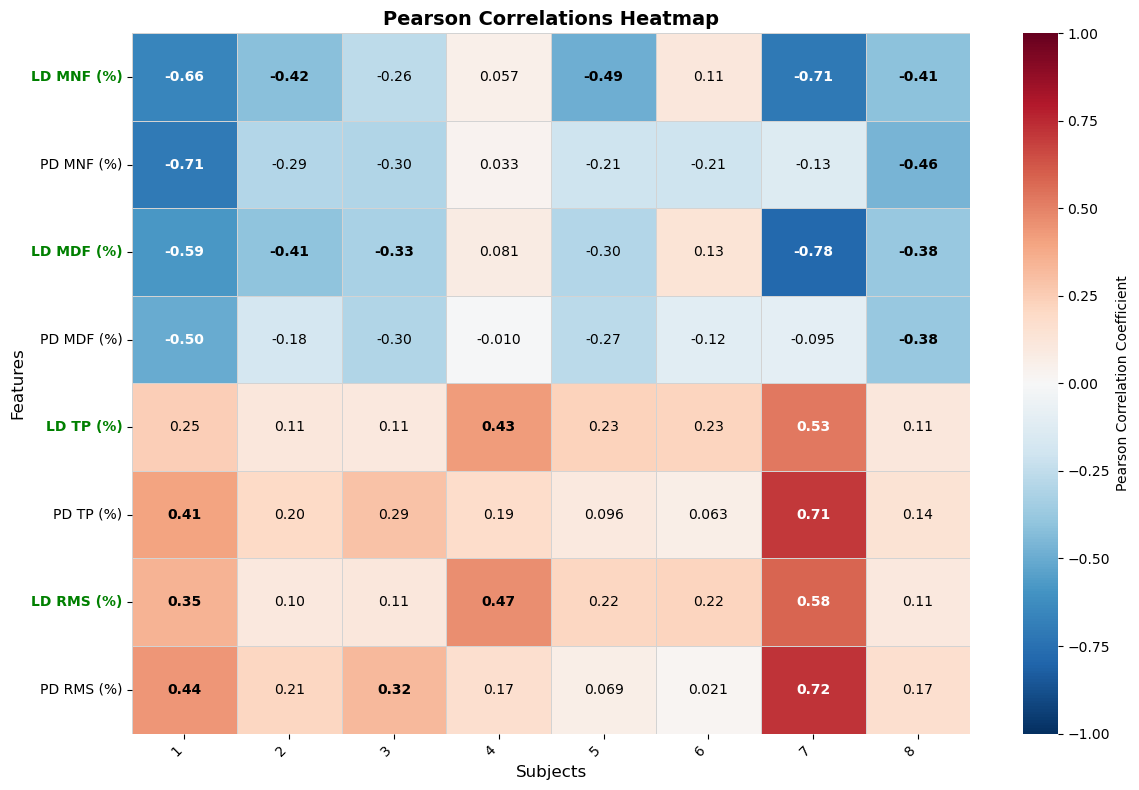

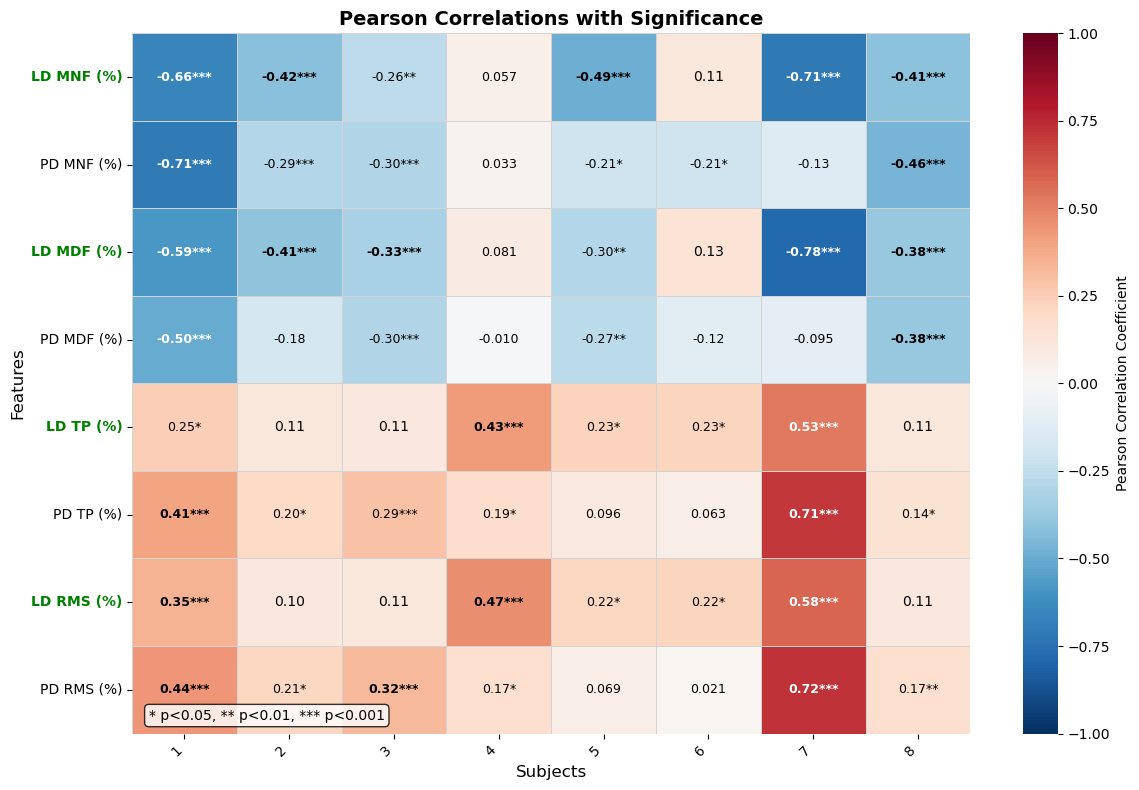

Mean correlation y-axis limits: [-0.45, 0.45]
Standard deviation y-axis limits: [0, 0.36]


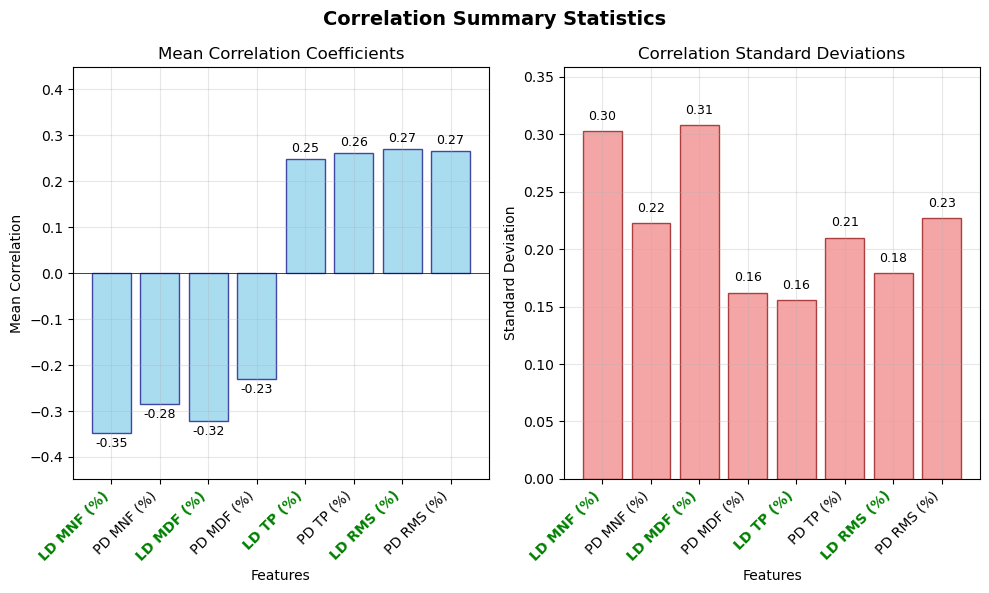

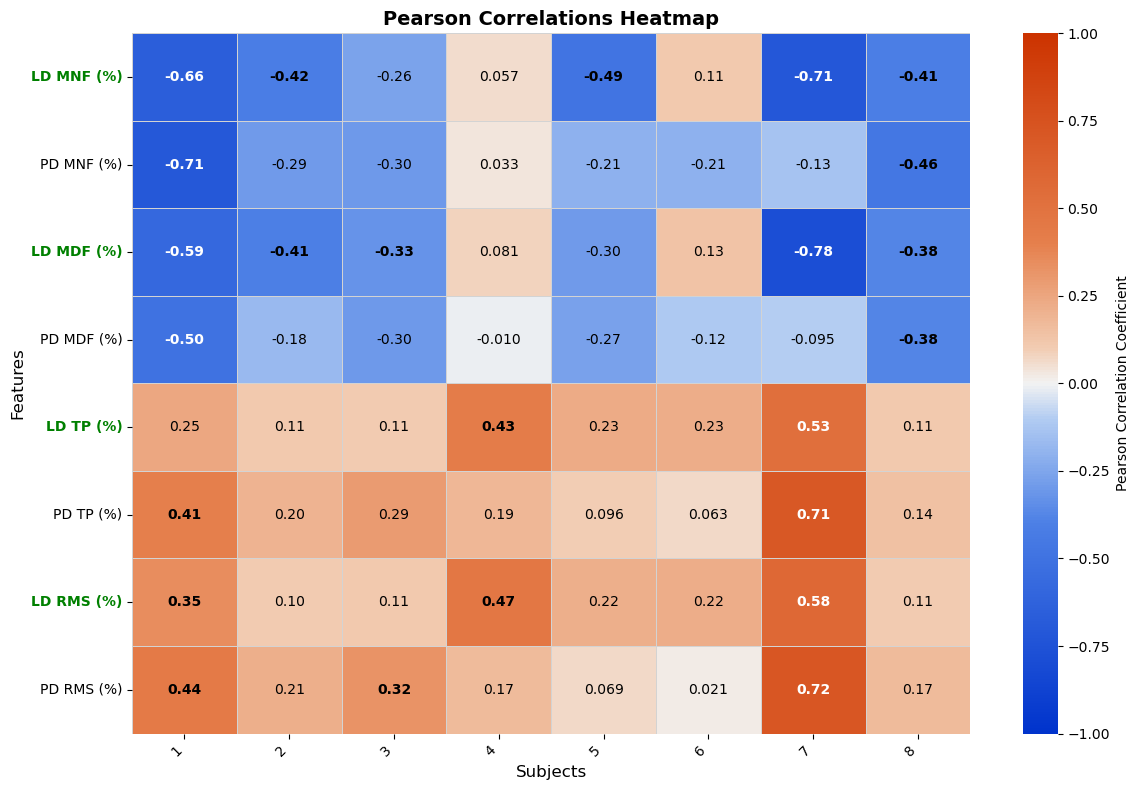

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from typing import List, Dict, Optional, Tuple, Union
import matplotlib.colors as mcolors

def calculate_pearson_correlations(data_manager, features: List[str], 
                                 subjects=None,
                                 x_axis: str = 'completion_percentage',
                                 normalization: Optional[str] = None,
                                 outlier_removal: bool = False,
                                 outlier_z_threshold: float = 3.0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate Pearson correlations between features and x_axis variable.
    
    Parameters:
    -----------
    data_manager : DataManager object
        The data manager containing the dataset
    features : List[str]
        List of feature names to calculate correlations for
    subjects : list, optional
        List of subjects to include. If None, uses all subjects
    x_axis : str
        The x-axis variable (default: 'completion_percentage')
    normalization : str, optional
        Type of normalization: 'standard', 'minmax', 'robust', or None
    outlier_removal : bool
        Whether to remove outliers based on z-score
    outlier_z_threshold : float
        Z-score threshold for outlier removal
    
    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        (correlations_df, p_values_df) - DataFrames with correlation coefficients and p-values
    """
    
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return pd.DataFrame(), pd.DataFrame()
    
    subjects_list = data['subject_id'].unique()
    
    # Check feature availability
    available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
    valid_features = [f for f in features if f in available_features]
    invalid_features = [f for f in features if f not in available_features]
    
    if invalid_features:
        print(f"Invalid features (skipped): {invalid_features}")
    
    if not valid_features:
        print("No valid features found")
        return pd.DataFrame(), pd.DataFrame()
    
    correlations = []
    p_values = []
    
    for subject in subjects_list:
        subject_data = data[data['subject_id'] == subject].copy()
        
        if subject_data.empty:
            continue
        
        # Get x-axis values
        x_vals = subject_data[x_axis].values
        
        subject_corrs = [subject]
        subject_pvals = [subject]
        
        for feature in valid_features:
            y_vals = subject_data[feature].values
            
            # Remove NaN values
            mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
            x_clean, y_clean = x_vals[mask], y_vals[mask]
            
            if len(x_clean) < 3:  # Need at least 3 points for meaningful correlation
                subject_corrs.append(np.nan)
                subject_pvals.append(np.nan)
                continue
            
            # Remove outliers if requested
            if outlier_removal:
                x_clean, y_clean = _remove_outliers_pearson(x_clean, y_clean, outlier_z_threshold)
                if len(x_clean) < 3:
                    subject_corrs.append(np.nan)
                    subject_pvals.append(np.nan)
                    continue
            
            # Apply normalization if requested
            if normalization:
                x_clean, y_clean = _apply_normalization(x_clean, y_clean, normalization)
            
            # Calculate Pearson correlation
            try:
                corr_coef, p_value = stats.pearsonr(x_clean, y_clean)
                subject_corrs.append(corr_coef)
                subject_pvals.append(p_value)
            except:
                subject_corrs.append(np.nan)
                subject_pvals.append(np.nan)
        
        correlations.append(subject_corrs)
        p_values.append(subject_pvals)
    
    # Create DataFrames
    columns = ['Subject'] + valid_features
    corr_df = pd.DataFrame(correlations, columns=columns).set_index('Subject')
    pval_df = pd.DataFrame(p_values, columns=columns).set_index('Subject')
    
    return corr_df, pval_df

def _remove_outliers_pearson(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score for both x and y values."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask]

def _apply_normalization(x_vals, y_vals, normalization_type):
    """Apply normalization to x and y values."""
    # Reshape for sklearn
    x_vals = x_vals.reshape(-1, 1)
    y_vals = y_vals.reshape(-1, 1)
    
    if normalization_type == 'standard':
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
    elif normalization_type == 'minmax':
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
    elif normalization_type == 'robust':
        scaler_x = RobustScaler()
        scaler_y = RobustScaler()
    else:
        raise ValueError(f"Unknown normalization type: {normalization_type}")
    
    x_normalized = scaler_x.fit_transform(x_vals).flatten()
    y_normalized = scaler_y.fit_transform(y_vals).flatten()
    
    return x_normalized, y_normalized

def _format_to_2_sig_figs(value):
    """Format a number to 2 significant figures."""
    if pd.isna(value) or value == 0:
        return "0.0"
    
    # Handle the sign
    sign = "-" if value < 0 else ""
    abs_value = abs(value)
    
    # Find the order of magnitude
    if abs_value >= 1:
        # For numbers >= 1
        order = int(np.floor(np.log10(abs_value)))
        factor = 10 ** (order - 1)  # 2 sig figs means order-1
        rounded_value = round(abs_value / factor) * factor
        
        if order >= 1:
            return f"{sign}{rounded_value:.{max(0, 1-order)}f}"
        else:
            return f"{sign}{rounded_value:.1f}"
    else:
        # For numbers < 1
        order = int(np.floor(np.log10(abs_value)))
        decimals = abs(order) + 1  # Number of decimal places needed
        factor = 10 ** (order - 1)
        rounded_value = round(abs_value / factor) * factor
        return f"{sign}{rounded_value:.{decimals}f}"

def plot_correlation_heatmap(corr_df: pd.DataFrame, 
                           p_values_df: pd.DataFrame = None,
                           feature_labels: Dict[str, str] = None,
                           figsize: Tuple[int, int] = (12, 8),
                           cmap: str = 'RdBu_r',
                           center: float = 0,
                           alpha_threshold: float = 0.05,
                           mask_nonsignificant: bool = False,
                           title: str = "Pearson Correlations Heatmap",
                           save_path: str = None,
                           show_plot: bool = True,
                           pale_threshold: float = 0.3) -> plt.Figure:
    """
    Improved correlation heatmap with better text visibility.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    p_values_df : pd.DataFrame, optional
        DataFrame with p-values for significance testing
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    cmap : str
        Colormap for the heatmap
    center : float
        Value to center the colormap at
    alpha_threshold : float
        P-value threshold for significance (default: 0.05)
    mask_nonsignificant : bool
        Whether to mask (hide) non-significant correlations
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    pale_threshold : float
        Threshold below which values get black text (default: 0.3)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Apply feature labels if provided
    display_corr_df = corr_df.copy()
    if feature_labels:
        display_corr_df.columns = [feature_labels.get(col, col) for col in display_corr_df.columns]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create significance mask if p-values provided
    mask = None
    if p_values_df is not None and mask_nonsignificant:
        display_pval_df = p_values_df.copy()
        if feature_labels:
            display_pval_df.columns = [feature_labels.get(col, col) for col in display_pval_df.columns]
        
        display_pval_df = display_pval_df.reindex(index=display_corr_df.index, 
                                                  columns=display_corr_df.columns)
        mask = display_pval_df > alpha_threshold
    
    # Create the base heatmap
    hm = sns.heatmap(display_corr_df.T, 
                     annot=False,  # We'll add custom annotations
                     fmt='',
                     cmap=cmap, 
                     center=center,
                     vmin=-1,
                     vmax=1,
                     ax=ax,
                     mask=mask.T if mask is not None else None,
                     cbar_kws={'label': 'Pearson Correlation Coefficient'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations with improved visibility
    for i in range(len(display_corr_df.index)):
        for j in range(len(display_corr_df.columns)):
            value = display_corr_df.iloc[i, j]
            
            # Skip NaN values
            if pd.isna(value):
                continue
            
            # Skip if masked (non-significant)
            if mask is not None and mask.iloc[i, j]:
                continue
            
            # Calculate text color based on value magnitude
            abs_val = abs(value)
            
            # Simple rule: use black text for low values, white for high values
            if abs_val < pale_threshold:
                text_color = 'black'
                font_weight = 'normal'
            else:
                # Higher correlation - determine based on background
                if value < -0.5:
                    text_color = 'white'  # Dark blue background
                elif value > 0.5:
                    text_color = 'white'  # Dark red background
                else:
                    text_color = 'black'  # Medium colors
                font_weight = 'bold'
            
            # Format the value
            text = _format_to_2_sig_figs(value)
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=10, 
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_correlation_heatmap_with_significance(corr_df: pd.DataFrame, 
                                             p_values_df: pd.DataFrame,
                                             feature_labels: Dict[str, str] = None,
                                             figsize: Tuple[int, int] = (12, 8),
                                             cmap: str = 'RdBu_r',
                                             center: float = 0,
                                             title: str = "Pearson Correlations with Significance",
                                             save_path: str = None,
                                             show_plot: bool = True,
                                             pale_threshold: float = 0.3) -> plt.Figure:
    """
    Improved correlation heatmap with significance stars and better text visibility.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    p_values_df : pd.DataFrame
        DataFrame with p-values for significance testing
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    cmap : str
        Colormap for the heatmap
    center : float
        Value to center the colormap at
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    pale_threshold : float
        Threshold below which values get black text (default: 0.3)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Apply feature labels if provided
    display_corr_df = corr_df.copy()
    display_pval_df = p_values_df.copy()
    
    if feature_labels:
        display_corr_df.columns = [feature_labels.get(col, col) for col in display_corr_df.columns]
        display_pval_df.columns = [feature_labels.get(col, col) for col in display_pval_df.columns]
    
    # Align indices and columns
    display_pval_df = display_pval_df.reindex(index=display_corr_df.index, 
                                              columns=display_corr_df.columns)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the base heatmap
    hm = sns.heatmap(display_corr_df.T, 
                     annot=False,
                     fmt='',
                     cmap=cmap, 
                     center=center,
                     vmin=-1,
                     vmax=1,
                     ax=ax,
                     cbar_kws={'label': 'Pearson Correlation Coefficient'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations with significance stars
    for i in range(len(display_corr_df.index)):
        for j in range(len(display_corr_df.columns)):
            corr_val = display_corr_df.iloc[i, j]
            p_val = display_pval_df.iloc[i, j]
            
            if pd.isna(corr_val):
                continue
            
            # Determine text color based on correlation magnitude
            abs_val = abs(corr_val)
            
            if abs_val < pale_threshold:
                text_color = 'black'
                font_weight = 'normal'
            else:
                # Higher correlation - determine based on value
                if corr_val < -0.5:
                    text_color = 'white'
                elif corr_val > 0.5:
                    text_color = 'white'
                else:
                    text_color = 'black'
                font_weight = 'bold'
            
            # Format correlation value
            corr_str = _format_to_2_sig_figs(corr_val)
            
            # Add significance stars if p-value available
            if not pd.isna(p_val):
                if p_val < 0.001:
                    stars = "***"
                elif p_val < 0.01:
                    stars = "**"
                elif p_val < 0.05:
                    stars = "*"
                else:
                    stars = ""
                text = f"{corr_str}{stars}"
            else:
                text = corr_str
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=9 if len(text) > 4 else 10,  # Smaller font for longer text
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Add legend for significance levels
    legend_text = "* p<0.05, ** p<0.01, *** p<0.001"
    ax.text(0.02, 0.02, legend_text, transform=ax.transAxes, 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
                                  facecolor="white", alpha=0.8))
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap with significance saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

# def plot_correlation_summary(corr_df: pd.DataFrame,
#                            feature_labels: Dict[str, str] = None,
#                            figsize: Tuple[int, int] = (10, 6),
#                            title: str = "Correlation Summary Statistics",
#                            save_path: str = None,
#                            show_plot: bool = True) -> plt.Figure:
#     """
#     Plot summary statistics of correlations across subjects with 2 sig fig formatting.
    
#     Parameters:
#     -----------
#     corr_df : pd.DataFrame
#         DataFrame with correlation coefficients
#     feature_labels : Dict[str, str], optional
#         Dictionary mapping feature names to display labels
#     figsize : Tuple[int, int]
#         Figure size
#     title : str
#         Plot title
#     save_path : str, optional
#         Path to save the plot
#     show_plot : bool
#         Whether to display the plot
    
#     Returns:
#     --------
#     plt.Figure
#         The matplotlib figure object
#     """
    
#     if corr_df.empty:
#         print("No correlation data to plot")
#         return None
    
#     # Calculate summary statistics
#     mean_corr = corr_df.mean()
#     std_corr = corr_df.std()
    
#     # Apply feature labels if provided
#     if feature_labels:
#         display_features = [feature_labels.get(col, col) for col in mean_corr.index]
#     else:
#         display_features = mean_corr.index
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
#     # Use standard colors for bars
#     colors1 = ['skyblue'] * len(display_features)
#     colors2 = ['lightcoral'] * len(display_features)
    
#     # Mean correlations bar plot
#     bars1 = ax1.bar(range(len(mean_corr)), mean_corr.values, 
#                     color=colors1, alpha=0.7, edgecolor='navy')
#     ax1.set_xlabel('Features')
#     ax1.set_ylabel('Mean Correlation')
#     ax1.set_title('Mean Correlation Coefficients')
#     ax1.set_xticks(range(len(mean_corr)))
#     ax1.set_xticklabels(display_features, rotation=45, ha='right')
#     ax1.grid(True, alpha=0.3)
#     ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
#     # Add value labels on bars with 2 sig figs
#     for bar, val in zip(bars1, mean_corr.values):
#         height = bar.get_height()
#         formatted_val = _format_to_2_sig_figs(val)
#         ax1.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.03),
#                 f'{formatted_val}', ha='center', va='bottom' if height > 0 else 'top')
    
#     # Standard deviation bar plot
#     bars2 = ax2.bar(range(len(std_corr)), std_corr.values, 
#                     color=colors2, alpha=0.7, edgecolor='darkred')
#     ax2.set_xlabel('Features')
#     ax2.set_ylabel('Standard Deviation')
#     ax2.set_title('Correlation Standard Deviations')
#     ax2.set_xticks(range(len(std_corr)))
#     ax2.set_xticklabels(display_features, rotation=45, ha='right')
#     ax2.grid(True, alpha=0.3)
    
#     # Add value labels on bars with 2 sig figs
#     for bar, val in zip(bars2, std_corr.values):
#         height = bar.get_height()
#         formatted_val = _format_to_2_sig_figs(val)
#         ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
#                 f'{formatted_val}', ha='center', va='bottom')
    
#     # Color x-axis labels for LD features (text only, not bars)
#     for ax in [ax1, ax2]:
#         labels = ax.get_xticklabels()
#         for label in labels:
#             if 'LD' in label.get_text():
#                 label.set_color('green')
#                 label.set_weight('bold')
    
#     plt.suptitle(title, fontsize=14, fontweight='bold')
#     plt.tight_layout()
    
#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#         print(f"Correlation summary plot saved to: {save_path}")
    
#     if show_plot:
#         plt.show()
    
#     return fig

def plot_correlation_summary(corr_df: pd.DataFrame,
                           feature_labels: Dict[str, str] = None,
                           figsize: Tuple[int, int] = (10, 6),
                           title: str = "Correlation Summary Statistics",
                           save_path: str = None,
                           show_plot: bool = True,
                           buffer: float = 0.1) -> plt.Figure:
    """
    Plot summary statistics of correlations across subjects with 2 sig fig formatting
    and symmetrical y-axis limits.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    buffer : float
        Buffer to add to the maximum absolute correlation value (default: 0.1)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Calculate summary statistics
    mean_corr = corr_df.mean()
    std_corr = corr_df.std()
    
    # Calculate symmetrical y-axis limits for mean correlation plot
    max_abs_mean_corr = abs(mean_corr).max()
    y_limit_mean = max_abs_mean_corr + buffer
    
    # Apply feature labels if provided
    if feature_labels:
        display_features = [feature_labels.get(col, col) for col in mean_corr.index]
    else:
        display_features = mean_corr.index
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Use standard colors for bars
    colors1 = ['skyblue'] * len(display_features)
    colors2 = ['lightcoral'] * len(display_features)
    
    # Mean correlations bar plot
    bars1 = ax1.bar(range(len(mean_corr)), mean_corr.values, 
                    color=colors1, alpha=0.7, edgecolor='navy')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Mean Correlation')
    ax1.set_title('Mean Correlation Coefficients')
    ax1.set_xticks(range(len(mean_corr)))
    ax1.set_xticklabels(display_features, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Set symmetrical y-axis limits for mean correlation plot
    ax1.set_ylim(-y_limit_mean, y_limit_mean)
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars1, mean_corr.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        # Adjust text position based on bar height and y-limits
        text_offset = y_limit_mean * 0.02  # 2% of the y-limit range
        y_pos = height + text_offset if height >= 0 else height - text_offset
        ax1.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{formatted_val}', ha='center', 
                va='bottom' if height >= 0 else 'top',
                fontsize=9)
    
    # Standard deviation bar plot
    bars2 = ax2.bar(range(len(std_corr)), std_corr.values, 
                    color=colors2, alpha=0.7, edgecolor='darkred')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Standard Deviation')
    ax2.set_title('Correlation Standard Deviations')
    ax2.set_xticks(range(len(std_corr)))
    ax2.set_xticklabels(display_features, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Set y-axis limit for std plot (starts from 0)
    max_std = std_corr.max()
    ax2.set_ylim(0, max_std + buffer/2)  # Smaller buffer for std plot
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars2, std_corr.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        text_offset = (max_std + buffer/2) * 0.02  # 2% of the y-limit range
        ax2.text(bar.get_x() + bar.get_width()/2., height + text_offset,
                f'{formatted_val}', ha='center', va='bottom',
                fontsize=9)
    
    # Color x-axis labels for LD features (text only, not bars)
    for ax in [ax1, ax2]:
        labels = ax.get_xticklabels()
        for label in labels:
            if 'LD' in label.get_text():
                label.set_color('green')
                label.set_weight('bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Print the y-axis limits for reference
    print(f"Mean correlation y-axis limits: [{-y_limit_mean:.2f}, {y_limit_mean:.2f}]")
    print(f"Standard deviation y-axis limits: [0, {max_std + buffer/2:.2f}]")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation summary plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig
# Optional: Create a custom diverging colormap with better pale center
def create_custom_diverging_colormap():
    """
    Create a custom diverging colormap with more visible pale center region.
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    # Define colors: dark blue -> light blue -> white -> light red -> dark red
    colors = [
        (0.0, (0.0, 0.2, 0.8)),    # Dark blue
        (0.3, (0.3, 0.5, 0.9)),    # Medium blue
        (0.45, (0.7, 0.8, 0.95)),  # Light blue
        (0.5, (0.95, 0.95, 0.95)), # Near white (slight gray)
        (0.55, (0.95, 0.8, 0.7)),  # Light red
        (0.7, (0.9, 0.5, 0.3)),    # Medium red
        (1.0, (0.8, 0.2, 0.0))     # Dark red
    ]
    
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
    return cmap

# Example usage
if __name__ == "__main__":
    # Example feature list
    FEATURES = [
        'ch2_mean_power_freq_max_pct_change',
        'ch1_mean_power_freq_max_pct_change',
        'ch2_median_power_freq_max_pct_change',
        'ch1_median_power_freq_max_pct_change',
        'ch2_total_power_max_pct_change',
        'ch1_total_power_max_pct_change',
        'ch2_rms_max_pct_change',
        'ch1_rms_max_pct_change'
    ]
    
    # Feature labels for better display
    FEATURE_LABELS = {
        'ch2_mean_power_freq_max_pct_change': 'LD MNF (%)',
        'ch1_mean_power_freq_max_pct_change': 'PD MNF (%)',
        'ch2_median_power_freq_max_pct_change': 'LD MDF (%)',
        'ch1_median_power_freq_max_pct_change': 'PD MDF (%)',
        'ch2_total_power_max_pct_change': 'LD TP (%)',
        'ch1_total_power_max_pct_change': 'PD TP (%)',
        'ch2_rms_max_pct_change': 'LD RMS (%)',
        'ch1_rms_max_pct_change': 'PD RMS (%)'
    }
    
    # Usage examples:
    # Without normalization
    corr_df, pval_df = calculate_pearson_correlations(manager, FEATURES)
    
    # # With standard normalization
    # corr_df, pval_df = calculate_pearson_correlations(manager, FEATURES, normalization='standard')
    
    # # With min-max normalization and outlier removal
    # corr_df, pval_df = calculate_pearson_correlations(manager, FEATURES, 
    #                                                   normalization='minmax', 
    #                                                   outlier_removal=True)
    
    # Print summary table
    # print_correlation_summary(corr_df, pval_df, FEATURE_LABELS)
    
    # Create all visualizations
    plot_correlation_heatmap(corr_df, pval_df, FEATURE_LABELS, pale_threshold=0.3)
    plot_correlation_heatmap_with_significance(corr_df, pval_df, FEATURE_LABELS, pale_threshold=0.3)
    plot_correlation_summary(corr_df, FEATURE_LABELS)
    
    # Or use custom colormap for even better visibility
    custom_cmap = create_custom_diverging_colormap()
    plot_correlation_heatmap(corr_df, pval_df, FEATURE_LABELS, cmap=custom_cmap)

EMG FATIGUE CORRELATION ANALYSIS SUMMARY - Zero-Intercept
Method: Forced through Origin (Recommended for EMG Fatigue)

LD MNF (%):
-----------
  Correlation:  Mean = -0.620, Std =  0.433
                Range = [-0.928,  0.361]
  Fatigue Rate: Mean = -0.111, Std =  0.076
                → Rate of change per 1% cycle completion
  R² Standard:  Mean =  0.549 (54.9% variance)
  R² Pearson²:  Mean =  0.549 (54.9% variance)
  Significant:  6/8 subjects (75.0%) at p<0.05

PD MNF (%):
-----------
  Correlation:  Mean = -0.494, Std =  0.238
                Range = [-0.858, -0.130]
  Fatigue Rate: Mean = -0.077, Std =  0.044
                → Rate of change per 1% cycle completion
  R² Standard:  Mean =  0.293 (29.3% variance)
  R² Pearson²:  Mean =  0.293 (29.3% variance)
  Significant:  7/8 subjects (87.5%) at p<0.05

LD MDF (%):
-----------
  Correlation:  Mean = -0.515, Std =  0.441
                Range = [-0.942,  0.474]
  Fatigue Rate: Mean = -0.099, Std =  0.091
                → Rate o

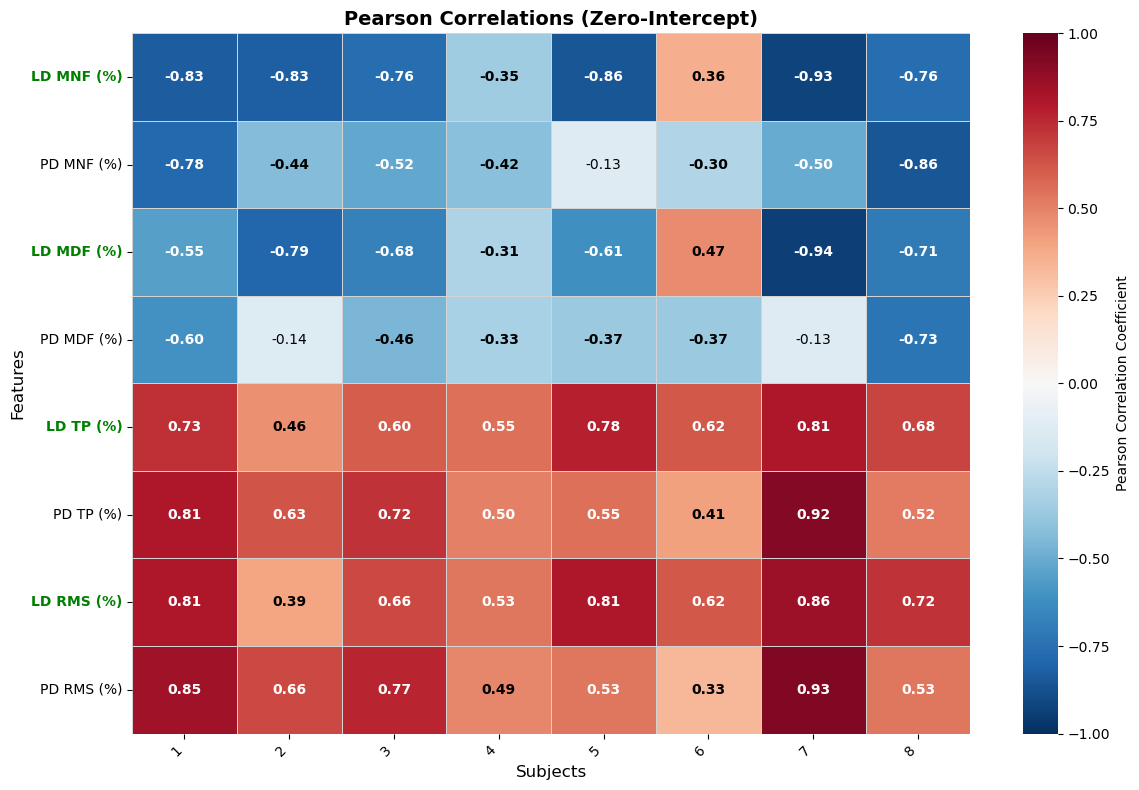

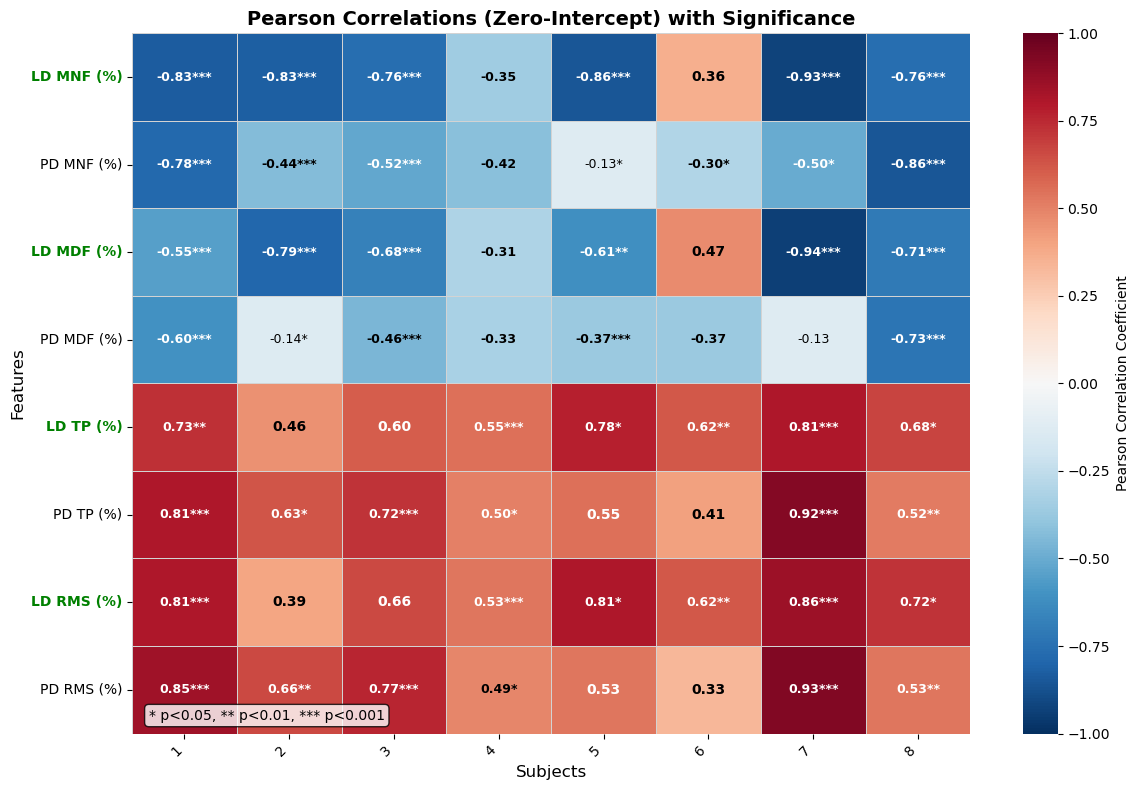

Mean correlation y-axis limits: [-0.78, 0.78]
Standard deviation y-axis limits: [0, 0.49]


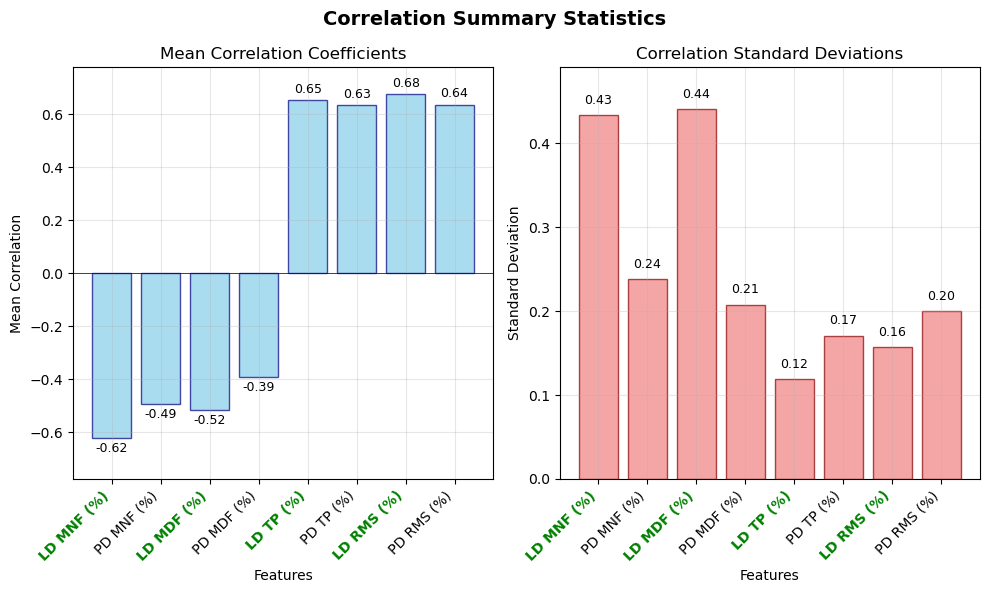

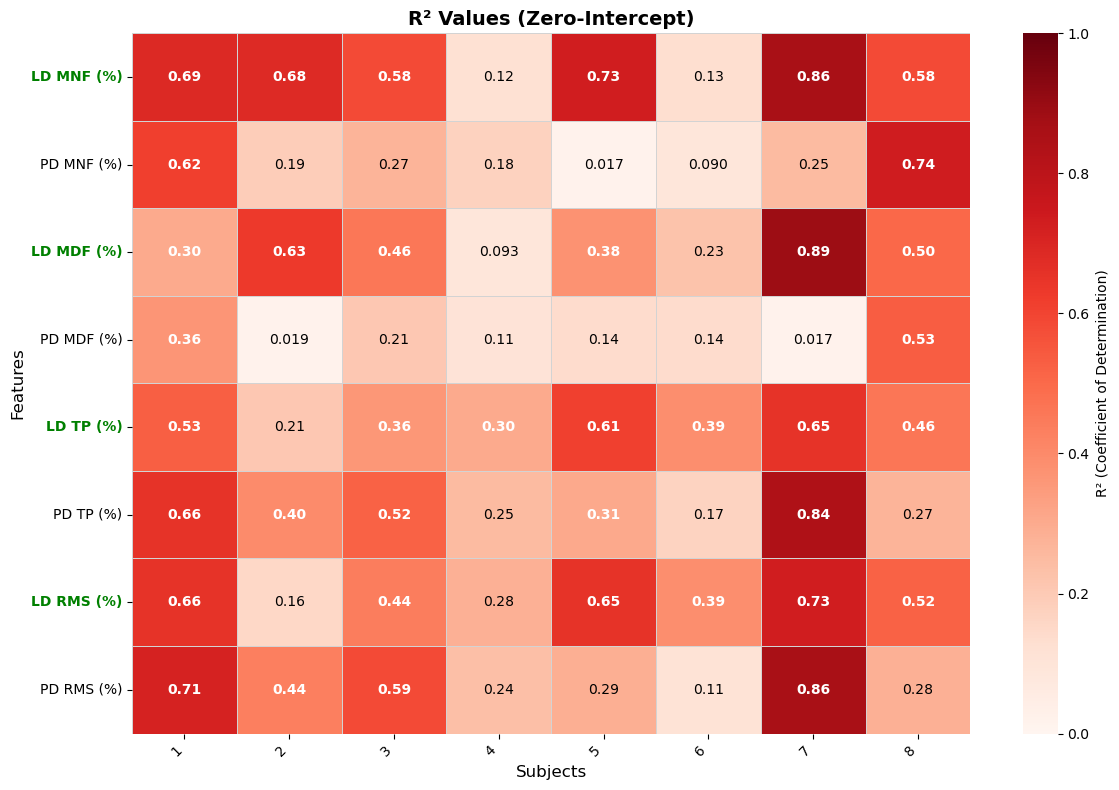

Mean R² y-axis limits: [0, 0.599]
R² standard deviation y-axis limits: [0, 0.299]


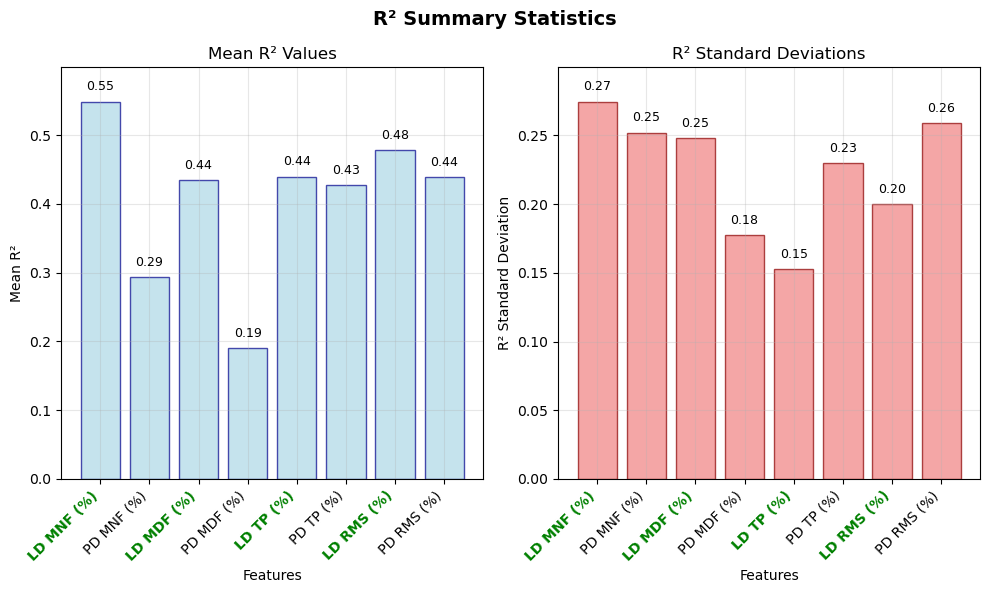

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from typing import List, Dict, Optional, Tuple, Union
import matplotlib.colors as mcolors

def calculate_zero_intercept_correlation(x_vals, y_vals):
    """
    Calculate correlation coefficient for line forced through origin.
    
    Parameters:
    -----------
    x_vals : array-like
        X values (e.g., completion_percentage)
    y_vals : array-like
        Y values (e.g., EMG features)
    
    Returns:
    --------
    Tuple[float, float, float, float]
        (correlation_coefficient, slope, r_squared_standard, r_squared_pearson)
    """
    # Remove mean from correlation formula to force through origin
    numerator = np.sum(x_vals * y_vals)
    denominator = np.sqrt(np.sum(x_vals**2) * np.sum(y_vals**2))
    
    if denominator == 0:
        return 0.0, 0.0, 0.0, 0.0
    
    correlation = numerator / denominator
    
    # Calculate slope for line through origin
    slope = np.sum(x_vals * y_vals) / np.sum(x_vals**2) if np.sum(x_vals**2) != 0 else 0
    
    # Calculate standard R² for line through origin (1 - SS_res/SS_tot)
    y_pred = slope * x_vals
    ss_res = np.sum((y_vals - y_pred)**2)
    ss_tot = np.sum(y_vals**2)  # Total sum of squares from origin
    r_squared_standard = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Calculate R² as squared Pearson correlation (from zero-intercept)
    r_squared_pearson = correlation ** 2
    
    return correlation, slope, r_squared_standard, r_squared_pearson

def _permutation_test_zero_intercept(x_vals, y_vals, observed_corr, n_permutations=1000):
    """
    Permutation test for zero-intercept correlation significance.
    
    Parameters:
    -----------
    x_vals : array-like
        X values
    y_vals : array-like
        Y values  
    observed_corr : float
        Observed correlation coefficient
    n_permutations : int
        Number of permutations for the test
    
    Returns:
    --------
    float
        P-value from permutation test
    """
    null_correlations = []
    
    for _ in range(n_permutations):
        # Shuffle y values while keeping x values fixed
        y_shuffled = np.random.permutation(y_vals)
        null_corr, _, _, _ = calculate_zero_intercept_correlation(x_vals, y_shuffled)
        null_correlations.append(null_corr)
    
    # Calculate p-value (two-tailed test)
    null_correlations = np.array(null_correlations)
    p_value = np.mean(np.abs(null_correlations) >= np.abs(observed_corr))
    
    return p_value

def calculate_pearson_correlations(data_manager, features: List[str], 
                                 subjects=None,
                                 x_axis: str = 'completion_percentage',
                                 normalization: Optional[str] = None,
                                 outlier_removal: bool = False,
                                 outlier_z_threshold: float = 3.0,
                                 zero_intercept: bool = True) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Calculate Pearson correlations between features and x_axis variable.
    
    Parameters:
    -----------
    data_manager : DataManager object
        The data manager containing the dataset
    features : List[str]
        List of feature names to calculate correlations for
    subjects : list, optional
        List of subjects to include. If None, uses all subjects
    x_axis : str
        The x-axis variable (default: 'completion_percentage')
    normalization : str, optional
        Type of normalization: 'standard', 'minmax', 'robust', or None
    outlier_removal : bool
        Whether to remove outliers based on z-score
    outlier_z_threshold : float
        Z-score threshold for outlier removal
    zero_intercept : bool
        Whether to use zero-intercept correlation (default: True, recommended for EMG fatigue)
        If False, uses standard Pearson correlation
    
    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]
        (correlations_df, p_values_df, slopes_df, r2_standard_df, r2_pearson_df)
        - slopes_df, r2_standard_df, r2_pearson_df only for zero_intercept=True
    """
    
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return pd.DataFrame(), pd.DataFrame(), None, None, None
    
    subjects_list = data['subject_id'].unique()
    
    # Check feature availability
    available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
    valid_features = [f for f in features if f in available_features]
    invalid_features = [f for f in features if f not in available_features]
    
    if invalid_features:
        print(f"Invalid features (skipped): {invalid_features}")
    
    if not valid_features:
        print("No valid features found")
        return pd.DataFrame(), pd.DataFrame(), None, None, None
    
    correlations = []
    p_values = []
    slopes = [] if zero_intercept else None
    r2_standard = [] if zero_intercept else None
    r2_pearson = [] if zero_intercept else None
    
    for subject in subjects_list:
        subject_data = data[data['subject_id'] == subject].copy()
        
        if subject_data.empty:
            continue
        
        # Get x-axis values
        x_vals = subject_data[x_axis].values
        
        subject_corrs = [subject]
        subject_pvals = [subject]
        subject_slopes = [subject] if zero_intercept else None
        subject_r2_std = [subject] if zero_intercept else None
        subject_r2_pear = [subject] if zero_intercept else None
        
        for feature in valid_features:
            y_vals = subject_data[feature].values
            
            # Remove NaN values
            mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
            x_clean, y_clean = x_vals[mask], y_vals[mask]
            
            if len(x_clean) < 3:  # Need at least 3 points for meaningful correlation
                subject_corrs.append(np.nan)
                subject_pvals.append(np.nan)
                if subject_slopes is not None:
                    subject_slopes.append(np.nan)
                    subject_r2_std.append(np.nan)
                    subject_r2_pear.append(np.nan)
                continue
            
            # Remove outliers if requested
            if outlier_removal:
                x_clean, y_clean = _remove_outliers_pearson(x_clean, y_clean, outlier_z_threshold)
                if len(x_clean) < 3:
                    subject_corrs.append(np.nan)
                    subject_pvals.append(np.nan)
                    if subject_slopes is not None:
                        subject_slopes.append(np.nan)
                        subject_r2_std.append(np.nan)
                        subject_r2_pear.append(np.nan)
                    continue
            
            # Apply normalization if requested
            if normalization and not zero_intercept:
                x_clean, y_clean = _apply_normalization(x_clean, y_clean, normalization)
            elif normalization and zero_intercept:
                print(f"Warning: Normalization with zero_intercept correlation may not be meaningful for EMG percentage features")
            
            # Calculate correlation based on type
            try:
                if zero_intercept:
                    corr_coef, slope, r2_std, r2_pear = calculate_zero_intercept_correlation(x_clean, y_clean)
                    subject_corrs.append(corr_coef)
                    subject_slopes.append(slope)
                    subject_r2_std.append(r2_std)
                    subject_r2_pear.append(r2_pear)
                    
                    # For zero intercept, use permutation test for p-value
                    p_value = _permutation_test_zero_intercept(x_clean, y_clean, corr_coef, n_permutations=1000)
                    subject_pvals.append(p_value)
                else:
                    corr_coef, p_value = stats.pearsonr(x_clean, y_clean)
                    subject_corrs.append(corr_coef)
                    subject_pvals.append(p_value)
                    
            except Exception as e:
                correlation_type = "zero_intercept" if zero_intercept else "standard Pearson"
                print(f"Error calculating {correlation_type} correlation for {feature}: {e}")
                subject_corrs.append(np.nan)
                subject_pvals.append(np.nan)
                if subject_slopes is not None:
                    subject_slopes.append(np.nan)
                    subject_r2_std.append(np.nan)
                    subject_r2_pear.append(np.nan)
        
        correlations.append(subject_corrs)
        p_values.append(subject_pvals)
        if slopes is not None:
            slopes.append(subject_slopes)
            r2_standard.append(subject_r2_std)
            r2_pearson.append(subject_r2_pear)
    
    # Create DataFrames
    columns = ['Subject'] + valid_features
    corr_df = pd.DataFrame(correlations, columns=columns).set_index('Subject')
    pval_df = pd.DataFrame(p_values, columns=columns).set_index('Subject')
    
    slopes_df = None
    r2_standard_df = None
    r2_pearson_df = None
    
    if slopes is not None:
        slopes_df = pd.DataFrame(slopes, columns=columns).set_index('Subject')
        r2_standard_df = pd.DataFrame(r2_standard, columns=columns).set_index('Subject')
        r2_pearson_df = pd.DataFrame(r2_pearson, columns=columns).set_index('Subject')
    
    return corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df

def _remove_outliers_pearson(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score for both x and y values."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask]

def _apply_normalization(x_vals, y_vals, normalization_type):
    """Apply normalization to x and y values."""
    # Reshape for sklearn
    x_vals = x_vals.reshape(-1, 1)
    y_vals = y_vals.reshape(-1, 1)
    
    if normalization_type == 'standard':
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
    elif normalization_type == 'minmax':
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
    elif normalization_type == 'robust':
        scaler_x = RobustScaler()
        scaler_y = RobustScaler()
    else:
        raise ValueError(f"Unknown normalization type: {normalization_type}")
    
    x_normalized = scaler_x.fit_transform(x_vals).flatten()
    y_normalized = scaler_y.fit_transform(y_vals).flatten()
    
    return x_normalized, y_normalized

def _format_to_2_sig_figs(value):
    """Format a number to 2 significant figures."""
    if pd.isna(value) or value == 0:
        return "0.0"
    
    # Handle the sign
    sign = "-" if value < 0 else ""
    abs_value = abs(value)
    
    # Find the order of magnitude
    if abs_value >= 1:
        # For numbers >= 1
        order = int(np.floor(np.log10(abs_value)))
        factor = 10 ** (order - 1)  # 2 sig figs means order-1
        rounded_value = round(abs_value / factor) * factor
        
        if order >= 1:
            return f"{sign}{rounded_value:.{max(0, 1-order)}f}"
        else:
            return f"{sign}{rounded_value:.1f}"
    else:
        # For numbers < 1
        order = int(np.floor(np.log10(abs_value)))
        decimals = abs(order) + 1  # Number of decimal places needed
        factor = 10 ** (order - 1)
        rounded_value = round(abs_value / factor) * factor
        return f"{sign}{rounded_value:.{decimals}f}"

def plot_correlation_heatmap(corr_df: pd.DataFrame, 
                           p_values_df: pd.DataFrame = None,
                           feature_labels: Dict[str, str] = None,
                           figsize: Tuple[int, int] = (12, 8),
                           cmap: str = 'RdBu_r',
                           center: float = 0,
                           alpha_threshold: float = 0.05,
                           mask_nonsignificant: bool = False,
                           title: str = "Pearson Correlations (Zero-Intercept)",
                           save_path: str = None,
                           show_plot: bool = True,
                           pale_threshold: float = 0.3) -> plt.Figure:
    """
    Improved correlation heatmap with better text visibility.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    p_values_df : pd.DataFrame, optional
        DataFrame with p-values for significance testing
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    cmap : str
        Colormap for the heatmap
    center : float
        Value to center the colormap at
    alpha_threshold : float
        P-value threshold for significance (default: 0.05)
    mask_nonsignificant : bool
        Whether to mask (hide) non-significant correlations
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    pale_threshold : float
        Threshold below which values get black text (default: 0.3)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Apply feature labels if provided
    display_corr_df = corr_df.copy()
    if feature_labels:
        display_corr_df.columns = [feature_labels.get(col, col) for col in display_corr_df.columns]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create significance mask if p-values provided
    mask = None
    if p_values_df is not None and mask_nonsignificant:
        display_pval_df = p_values_df.copy()
        if feature_labels:
            display_pval_df.columns = [feature_labels.get(col, col) for col in display_pval_df.columns]
        
        display_pval_df = display_pval_df.reindex(index=display_corr_df.index, 
                                                  columns=display_corr_df.columns)
        mask = display_pval_df > alpha_threshold
    
    # Create the base heatmap
    hm = sns.heatmap(display_corr_df.T, 
                     annot=False,  # We'll add custom annotations
                     fmt='',
                     cmap=cmap, 
                     center=center,
                     vmin=-1,
                     vmax=1,
                     ax=ax,
                     mask=mask.T if mask is not None else None,
                     cbar_kws={'label': 'Pearson Correlation Coefficient'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations with improved visibility
    for i in range(len(display_corr_df.index)):
        for j in range(len(display_corr_df.columns)):
            value = display_corr_df.iloc[i, j]
            
            # Skip NaN values
            if pd.isna(value):
                continue
            
            # Skip if masked (non-significant)
            if mask is not None and mask.iloc[i, j]:
                continue
            
            # Calculate text color based on value magnitude
            abs_val = abs(value)
            
            # Simple rule: use black text for low values, white for high values
            if abs_val < pale_threshold:
                text_color = 'black'
                font_weight = 'normal'
            else:
                # Higher correlation - determine based on background
                if value < -0.5:
                    text_color = 'white'  # Dark blue background
                elif value > 0.5:
                    text_color = 'white'  # Dark red background
                else:
                    text_color = 'black'  # Medium colors
                font_weight = 'bold'
            
            # Format the value
            text = _format_to_2_sig_figs(value)
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=10, 
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_correlation_heatmap_with_significance(corr_df: pd.DataFrame, 
                                             p_values_df: pd.DataFrame,
                                             feature_labels: Dict[str, str] = None,
                                             figsize: Tuple[int, int] = (12, 8),
                                             cmap: str = 'RdBu_r',
                                             center: float = 0,
                                             title: str = "Pearson Correlations (Zero-Intercept) with Significance",
                                             save_path: str = None,
                                             show_plot: bool = True,
                                             pale_threshold: float = 0.3) -> plt.Figure:
    """
    Improved correlation heatmap with significance stars and better text visibility.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    p_values_df : pd.DataFrame
        DataFrame with p-values for significance testing
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    cmap : str
        Colormap for the heatmap
    center : float
        Value to center the colormap at
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    pale_threshold : float
        Threshold below which values get black text (default: 0.3)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Apply feature labels if provided
    display_corr_df = corr_df.copy()
    display_pval_df = p_values_df.copy()
    
    if feature_labels:
        display_corr_df.columns = [feature_labels.get(col, col) for col in display_corr_df.columns]
        display_pval_df.columns = [feature_labels.get(col, col) for col in display_pval_df.columns]
    
    # Align indices and columns
    display_pval_df = display_pval_df.reindex(index=display_corr_df.index, 
                                              columns=display_corr_df.columns)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the base heatmap
    hm = sns.heatmap(display_corr_df.T, 
                     annot=False,
                     fmt='',
                     cmap=cmap, 
                     center=center,
                     vmin=-1,
                     vmax=1,
                     ax=ax,
                     cbar_kws={'label': 'Pearson Correlation Coefficient'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations with significance stars
    for i in range(len(display_corr_df.index)):
        for j in range(len(display_corr_df.columns)):
            corr_val = display_corr_df.iloc[i, j]
            p_val = display_pval_df.iloc[i, j]
            
            if pd.isna(corr_val):
                continue
            
            # Determine text color based on correlation magnitude
            abs_val = abs(corr_val)
            
            if abs_val < pale_threshold:
                text_color = 'black'
                font_weight = 'normal'
            else:
                # Higher correlation - determine based on value
                if corr_val < -0.5:
                    text_color = 'white'
                elif corr_val > 0.5:
                    text_color = 'white'
                else:
                    text_color = 'black'
                font_weight = 'bold'
            
            # Format correlation value
            corr_str = _format_to_2_sig_figs(corr_val)
            
            # Add significance stars if p-value available
            if not pd.isna(p_val):
                if p_val < 0.001:
                    stars = "***"
                elif p_val < 0.01:
                    stars = "**"
                elif p_val < 0.05:
                    stars = "*"
                else:
                    stars = ""
                text = f"{corr_str}{stars}"
            else:
                text = corr_str
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=9 if len(text) > 4 else 10,  # Smaller font for longer text
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Add legend for significance levels
    legend_text = "* p<0.05, ** p<0.01, *** p<0.001"
    ax.text(0.02, 0.02, legend_text, transform=ax.transAxes, 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
                                  facecolor="white", alpha=0.8))
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap with significance saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_correlation_summary(corr_df: pd.DataFrame,
                           feature_labels: Dict[str, str] = None,
                           figsize: Tuple[int, int] = (10, 6),
                           title: str = "Correlation Summary Statistics",
                           save_path: str = None,
                           show_plot: bool = True,
                           buffer: float = 0.1) -> plt.Figure:
    """
    Plot summary statistics of correlations across subjects with 2 sig fig formatting
    and symmetrical y-axis limits.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    buffer : float
        Buffer to add to the maximum absolute correlation value (default: 0.1)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Calculate summary statistics
    mean_corr = corr_df.mean()
    std_corr = corr_df.std()
    
    # Calculate symmetrical y-axis limits for mean correlation plot
    max_abs_mean_corr = abs(mean_corr).max()
    y_limit_mean = max_abs_mean_corr + buffer
    
    # Apply feature labels if provided
    if feature_labels:
        display_features = [feature_labels.get(col, col) for col in mean_corr.index]
    else:
        display_features = mean_corr.index
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Use standard colors for bars
    colors1 = ['skyblue'] * len(display_features)
    colors2 = ['lightcoral'] * len(display_features)
    
    # Mean correlations bar plot
    bars1 = ax1.bar(range(len(mean_corr)), mean_corr.values, 
                    color=colors1, alpha=0.7, edgecolor='navy')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Mean Correlation')
    ax1.set_title('Mean Correlation Coefficients')
    ax1.set_xticks(range(len(mean_corr)))
    ax1.set_xticklabels(display_features, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Set symmetrical y-axis limits for mean correlation plot
    ax1.set_ylim(-y_limit_mean, y_limit_mean)
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars1, mean_corr.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        # Adjust text position based on bar height and y-limits
        text_offset = y_limit_mean * 0.02  # 2% of the y-limit range
        y_pos = height + text_offset if height >= 0 else height - text_offset
        ax1.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{formatted_val}', ha='center', 
                va='bottom' if height >= 0 else 'top',
                fontsize=9)
    
    # Standard deviation bar plot
    bars2 = ax2.bar(range(len(std_corr)), std_corr.values, 
                    color=colors2, alpha=0.7, edgecolor='darkred')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Standard Deviation')
    ax2.set_title('Correlation Standard Deviations')
    ax2.set_xticks(range(len(std_corr)))
    ax2.set_xticklabels(display_features, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Set y-axis limit for std plot (starts from 0)
    max_std = std_corr.max()
    ax2.set_ylim(0, max_std + buffer/2)  # Smaller buffer for std plot
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars2, std_corr.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        text_offset = (max_std + buffer/2) * 0.02  # 2% of the y-limit range
        ax2.text(bar.get_x() + bar.get_width()/2., height + text_offset,
                f'{formatted_val}', ha='center', va='bottom',
                fontsize=9)
    
    # Color x-axis labels for LD features (text only, not bars)
    for ax in [ax1, ax2]:
        labels = ax.get_xticklabels()
        for label in labels:
            if 'LD' in label.get_text():
                label.set_color('green')
                label.set_weight('bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Print the y-axis limits for reference
    print(f"Mean correlation y-axis limits: [{-y_limit_mean:.2f}, {y_limit_mean:.2f}]")
    print(f"Standard deviation y-axis limits: [0, {max_std + buffer/2:.2f}]")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation summary plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_r_squared_summary(r2_df: pd.DataFrame,
                          feature_labels: Dict[str, str] = None,
                          figsize: Tuple[int, int] = (10, 6),
                          title: str = "R² Summary Statistics",
                          save_path: str = None,
                          show_plot: bool = True,
                          buffer: float = 0.05) -> plt.Figure:
    """
    Plot summary statistics of R² values across subjects.
    
    Parameters:
    -----------
    r2_df : pd.DataFrame
        DataFrame with R² values
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    buffer : float
        Buffer to add to the maximum R² value (default: 0.05)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if r2_df.empty:
        print("No R² data to plot")
        return None
    
    # Calculate summary statistics
    mean_r2 = r2_df.mean()
    std_r2 = r2_df.std()
    
    # Apply feature labels if provided
    if feature_labels:
        display_features = [feature_labels.get(col, col) for col in mean_r2.index]
    else:
        display_features = mean_r2.index
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Use colors appropriate for R² (always positive)
    colors1 = ['lightblue'] * len(display_features)
    colors2 = ['lightcoral'] * len(display_features)
    
    # Mean R² bar plot
    bars1 = ax1.bar(range(len(mean_r2)), mean_r2.values, 
                    color=colors1, alpha=0.7, edgecolor='darkblue')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Mean R²')
    ax1.set_title('Mean R² Values')
    ax1.set_xticks(range(len(mean_r2)))
    ax1.set_xticklabels(display_features, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Set y-axis limits for R² (0 to max + buffer)
    max_r2 = mean_r2.max()
    ax1.set_ylim(0, max_r2 + buffer)
    
    # Add value labels on bars with 2 sig figs for R²
    for bar, val in zip(bars1, mean_r2.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        text_offset = (max_r2 + buffer) * 0.02  # 2% of the y-limit range
        ax1.text(bar.get_x() + bar.get_width()/2., height + text_offset,
                f'{formatted_val}', ha='center', va='bottom',
                fontsize=9)
    
    # Standard deviation bar plot
    bars2 = ax2.bar(range(len(std_r2)), std_r2.values, 
                    color=colors2, alpha=0.7, edgecolor='darkred')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('R² Standard Deviation')
    ax2.set_title('R² Standard Deviations')
    ax2.set_xticks(range(len(std_r2)))
    ax2.set_xticklabels(display_features, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Set y-axis limit for std plot (starts from 0)
    max_std = std_r2.max()
    ax2.set_ylim(0, max_std + buffer/2)  # Smaller buffer for std plot
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars2, std_r2.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        text_offset = (max_std + buffer/2) * 0.02  # 2% of the y-limit range
        ax2.text(bar.get_x() + bar.get_width()/2., height + text_offset,
                f'{formatted_val}', ha='center', va='bottom',
                fontsize=9)
    
    # Color x-axis labels for LD features (text only, not bars)
    for ax in [ax1, ax2]:
        labels = ax.get_xticklabels()
        for label in labels:
            if 'LD' in label.get_text():
                label.set_color('green')
                label.set_weight('bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Print the y-axis limits for reference
    print(f"Mean R² y-axis limits: [0, {max_r2 + buffer:.3f}]")
    print(f"R² standard deviation y-axis limits: [0, {max_std + buffer/2:.3f}]")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"R² summary plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_r_squared_heatmap(r2_df: pd.DataFrame,
                          feature_labels: Dict[str, str] = None,
                          figsize: Tuple[int, int] = (12, 8),
                          title: str = "R² Values (Coefficient of Determination)",
                          save_path: str = None,
                          show_plot: bool = True) -> plt.Figure:
    """
    Plot R² (coefficient of determination) heatmap.
    
    Parameters:
    -----------
    r2_df : pd.DataFrame
        DataFrame with R² values
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if r2_df.empty:
        print("No R² data to plot")
        return None
    
    # Apply feature labels if provided
    display_r2_df = r2_df.copy()
    if feature_labels:
        display_r2_df.columns = [feature_labels.get(col, col) for col in display_r2_df.columns]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the heatmap with different colormap (since R² is always positive)
    hm = sns.heatmap(display_r2_df.T, 
                     annot=False,  # We'll add custom annotations
                     fmt='',
                     cmap='Reds',  # Red colormap for R² (0 to 1)
                     vmin=0,
                     vmax=1,
                     ax=ax,
                     cbar_kws={'label': 'R² (Coefficient of Determination)'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations
    for i in range(len(display_r2_df.index)):
        for j in range(len(display_r2_df.columns)):
            value = display_r2_df.iloc[i, j]
            
            # Skip NaN values
            if pd.isna(value):
                continue
            
            # Determine text color based on value
            if value < 0.3:
                text_color = 'black'
                font_weight = 'normal'
            else:
                text_color = 'white'
                font_weight = 'bold'
            
            # Format the value to 2 sig figs for R²
            text = _format_to_2_sig_figs(value)
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=10, 
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"R² heatmap saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def print_correlation_summary(corr_df: pd.DataFrame,
                            p_values_df: pd.DataFrame = None,
                            slopes_df: pd.DataFrame = None,
                            r2_standard_df: pd.DataFrame = None,
                            r2_pearson_df: pd.DataFrame = None,
                            feature_labels: Dict[str, str] = None,
                            zero_intercept: bool = True):
    """
    Print comprehensive correlation analysis summary.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        Correlation coefficients
    p_values_df : pd.DataFrame, optional
        P-values for correlations
    slopes_df : pd.DataFrame, optional
        Slopes (only for zero_intercept=True)
    r2_standard_df : pd.DataFrame, optional
        Standard R² values (only for zero_intercept=True)
    r2_pearson_df : pd.DataFrame, optional
        Pearson R² values (only for zero_intercept=True)
    feature_labels : Dict[str, str], optional
        Feature labels for display
    zero_intercept : bool
        Whether analysis used zero-intercept method
    """
    
    method_name = "Zero-Intercept" if zero_intercept else "Standard Pearson"
    print("="*80)
    print(f"EMG FATIGUE CORRELATION ANALYSIS SUMMARY - {method_name}")
    if zero_intercept:
        print("Method: Forced through Origin (Recommended for EMG Fatigue)")
    else:
        print("Method: Standard Pearson Correlation")
    print("="*80)
    
    features = corr_df.columns
    
    for feature in features:
        display_name = feature_labels.get(feature, feature) if feature_labels else feature
        print(f"\n{display_name}:")
        print("-" * (len(display_name) + 1))
        
        # Basic correlation statistics
        corr_mean = corr_df[feature].mean()
        corr_std = corr_df[feature].std()
        corr_min = corr_df[feature].min()
        corr_max = corr_df[feature].max()
        
        print(f"  Correlation:  Mean = {corr_mean:6.3f}, Std = {corr_std:6.3f}")
        print(f"                Range = [{corr_min:6.3f}, {corr_max:6.3f}]")
        
        # Add slope information for zero-intercept (biological interpretation)
        if slopes_df is not None:
            slope_mean = slopes_df[feature].mean()
            slope_std = slopes_df[feature].std()
            print(f"  Fatigue Rate: Mean = {slope_mean:6.3f}, Std = {slope_std:6.3f}")
            print(f"                → Rate of change per 1% cycle completion")
        
        # R² information for zero-intercept
        if r2_standard_df is not None and r2_pearson_df is not None:
            r2_std_mean = r2_standard_df[feature].mean()
            r2_pear_mean = r2_pearson_df[feature].mean()
            print(f"  R² Standard:  Mean = {r2_std_mean:6.3f} ({r2_std_mean*100:.1f}% variance)")
            print(f"  R² Pearson²:  Mean = {r2_pear_mean:6.3f} ({r2_pear_mean*100:.1f}% variance)")
        
        # Significance information
        if p_values_df is not None:
            sig_count = (p_values_df[feature] < 0.05).sum()
            total_subjects = p_values_df[feature].notna().sum()
            sig_percentage = (sig_count / total_subjects * 100) if total_subjects > 0 else 0
            print(f"  Significant:  {sig_count}/{total_subjects} subjects ({sig_percentage:.1f}%) at p<0.05")
    
    print("\n" + "="*80)
    print("INTERPRETATION NOTES:")
    if zero_intercept:
        print("• Zero-intercept correlation is more appropriate for EMG percentage change features")
        print("• Slope values represent the rate of fatigue development per % cycle completion")
        print("• Standard R² = 1 - SS_residual/SS_total (from origin)")
        print("• Pearson R² = correlation coefficient squared")
        print("• Positive slopes indicate increasing feature values with fatigue progression")
        print("• Negative slopes indicate decreasing feature values with fatigue progression")
    else:
        print("• Standard Pearson correlation measures linear relationship with intercept")
        print("• Suitable for general linear relationships between variables")
        print("• May not be optimal for EMG fatigue percentage change features")
    print("="*80)

# Optional: Create a custom diverging colormap with better pale center
def create_custom_diverging_colormap():
    """
    Create a custom diverging colormap with more visible pale center region.
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    # Define colors: dark blue -> light blue -> white -> light red -> dark red
    colors = [
        (0.0, (0.0, 0.2, 0.8)),    # Dark blue
        (0.3, (0.3, 0.5, 0.9)),    # Medium blue
        (0.45, (0.7, 0.8, 0.95)),  # Light blue
        (0.5, (0.95, 0.95, 0.95)), # Near white (slight gray)
        (0.55, (0.95, 0.8, 0.7)),  # Light red
        (0.7, (0.9, 0.5, 0.3)),    # Medium red
        (1.0, (0.8, 0.2, 0.0))     # Dark red
    ]
    
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
    return cmap

# Example usage
if __name__ == "__main__":
    # Example feature list
    FEATURES = [
        'ch2_mean_power_freq_max_pct_change',
        'ch1_mean_power_freq_max_pct_change',
        'ch2_median_power_freq_max_pct_change',
        'ch1_median_power_freq_max_pct_change',
        'ch2_total_power_max_pct_change',
        'ch1_total_power_max_pct_change',
        'ch2_rms_max_pct_change',
        'ch1_rms_max_pct_change'
    ]
    
    # Feature labels for better display
    FEATURE_LABELS = {
        'ch2_mean_power_freq_max_pct_change': 'LD MNF (%)',
        'ch1_mean_power_freq_max_pct_change': 'PD MNF (%)',
        'ch2_median_power_freq_max_pct_change': 'LD MDF (%)',
        'ch1_median_power_freq_max_pct_change': 'PD MDF (%)',
        'ch2_total_power_max_pct_change': 'LD TP (%)',
        'ch1_total_power_max_pct_change': 'PD TP (%)',
        'ch2_rms_max_pct_change': 'LD RMS (%)',
        'ch1_rms_max_pct_change': 'PD RMS (%)'
    }
    
    # Usage examples:
    
    # Zero-intercept correlation (DEFAULT - recommended for EMG fatigue)
    corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df = calculate_pearson_correlations(
        manager, FEATURES, zero_intercept=True
    )
    
    # Standard Pearson correlation (if needed for comparison)
    # corr_df, pval_df, _, _, _ = calculate_pearson_correlations(
    #     manager, FEATURES, zero_intercept=False
    # )
    
    # With additional options
    # corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df = calculate_pearson_correlations(
    #     manager, FEATURES, 
    #     zero_intercept=True,
    #     outlier_removal=True,
    #     outlier_z_threshold=3.0
    # )
    
    # Print comprehensive summary
    print_correlation_summary(corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df, 
                             FEATURE_LABELS, zero_intercept=True)
    
    # Create all standard visualizations
    plot_correlation_heatmap(corr_df, pval_df, FEATURE_LABELS, 
                           title="Pearson Correlations (Zero-Intercept)")
    
    plot_correlation_heatmap_with_significance(corr_df, pval_df, FEATURE_LABELS,
                                             title="Pearson Correlations (Zero-Intercept) with Significance")
    
    plot_correlation_summary(corr_df, FEATURE_LABELS, 
                           title="Correlation Summary Statistics")
    
    # Optional: Plot R² heatmaps and summary (only available with zero_intercept=True)
    if r2_standard_df is not None:
        plot_r_squared_heatmap(r2_standard_df, FEATURE_LABELS, 
                              title="R² Values (Zero-Intercept)")
        
        plot_r_squared_summary(r2_standard_df, FEATURE_LABELS,
                              title="R² Summary Statistics")
    
    # Optional: Use custom colormap for even better visibility
    # custom_cmap = create_custom_diverging_colormap()
    # plot_correlation_heatmap(corr_df, pval_df, FEATURE_LABELS, 
    #                         cmap=custom_cmap, title="Pearson Correlations (Zero-Intercept) - Custom Colormap")

EMG Fatigue Correlation Analysis Module
Use run_correlation_analysis() for complete analysis
Calculating correlations...
EMG FATIGUE CORRELATION ANALYSIS SUMMARY - Zero-Intercept
Method: Forced through Origin (Recommended for EMG Fatigue)

Feature Analysis:
--------------------------------------------------------------------------------

LD MNF (%):
  Correlation: μ=-0.620, σ= 0.433
               Range=[-0.928,  0.361]
  Fatigue Rate: μ=-0.111, σ= 0.076
  R²: μ= 0.549 (54.9% variance explained)
  Significant: 6/8 subjects (75.0%)

PD MNF (%):
  Correlation: μ=-0.494, σ= 0.238
               Range=[-0.858, -0.130]
  Fatigue Rate: μ=-0.077, σ= 0.044
  R²: μ= 0.293 (29.3% variance explained)
  Significant: 7/8 subjects (87.5%)

LD MDF (%):
  Correlation: μ=-0.515, σ= 0.441
               Range=[-0.942,  0.474]
  Fatigue Rate: μ=-0.099, σ= 0.091
  R²: μ= 0.435 (43.5% variance explained)
  Significant: 6/8 subjects (75.0%)

PD MDF (%):
  Correlation: μ=-0.390, σ= 0.208
               Range

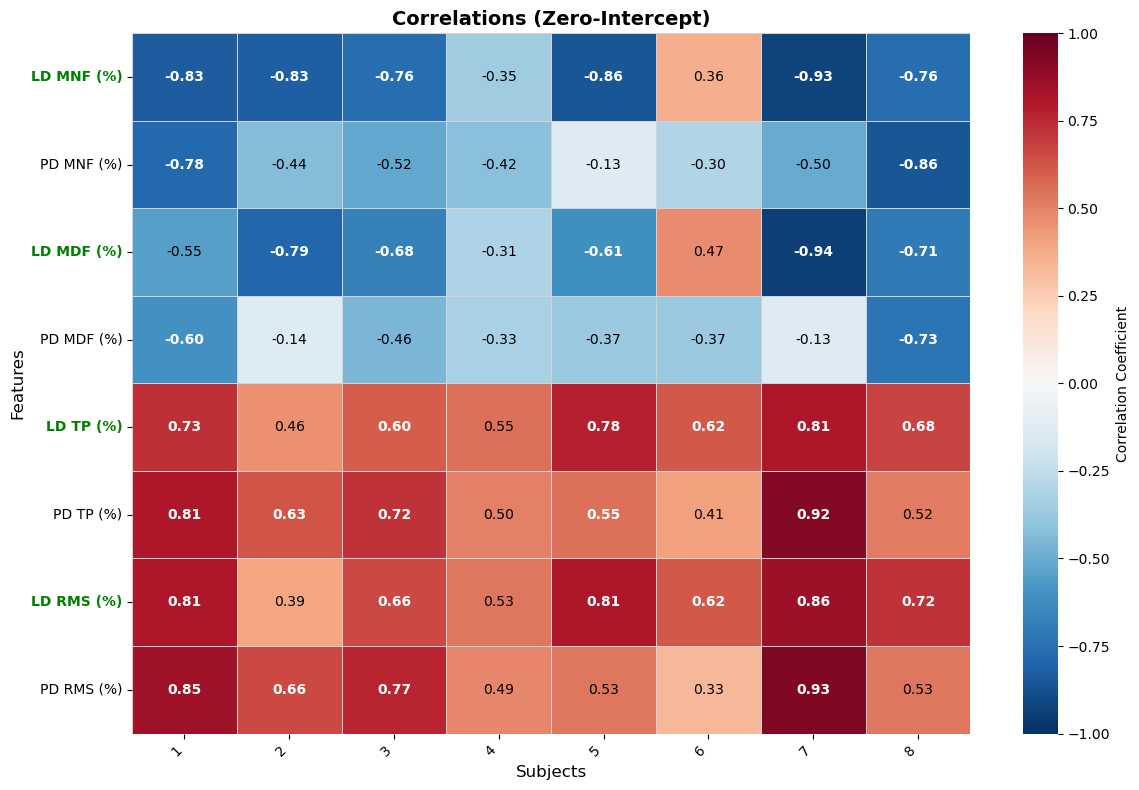

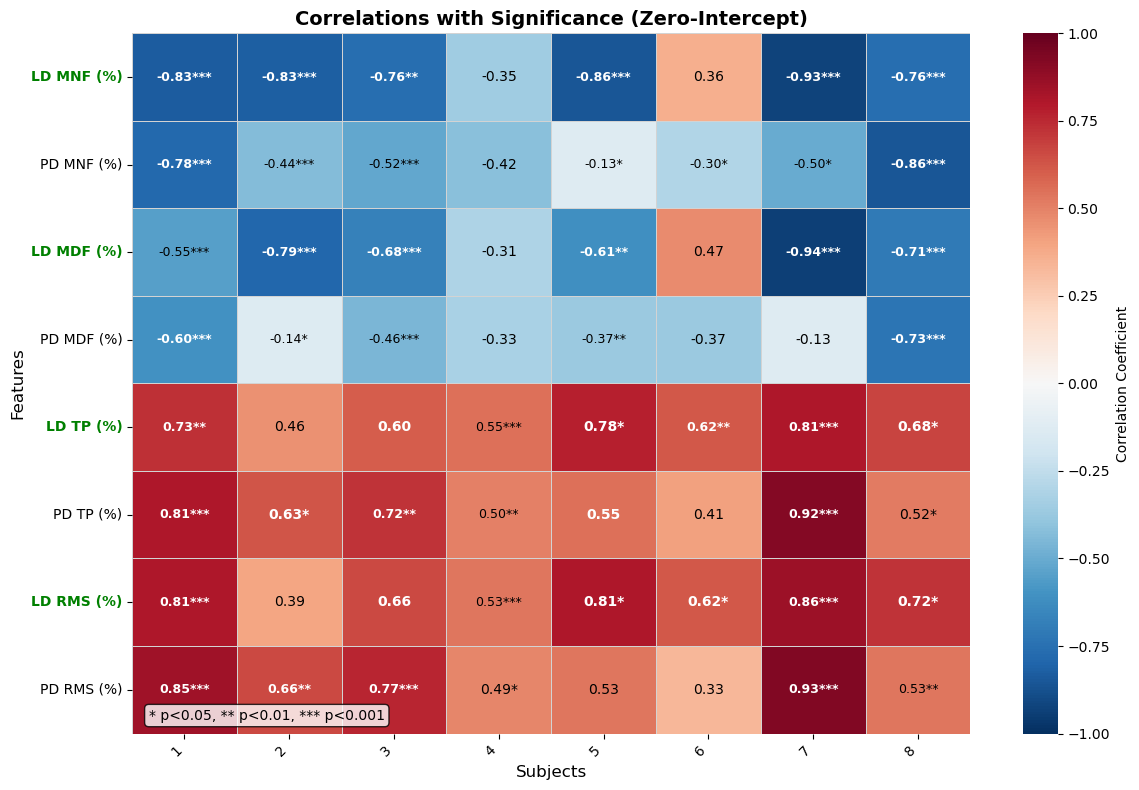

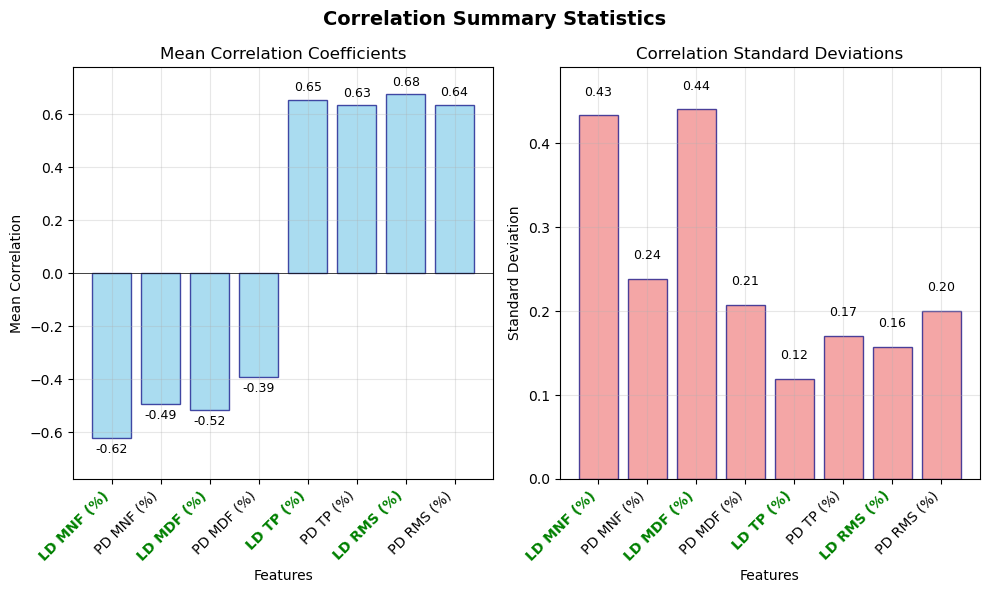

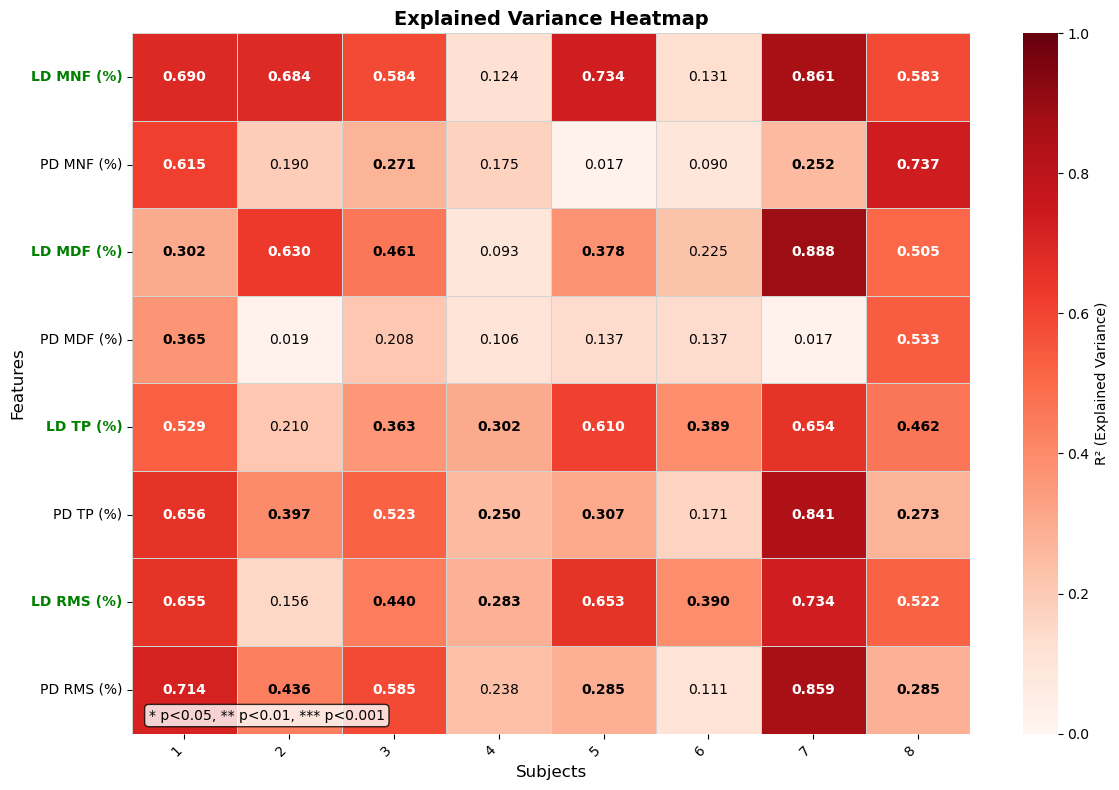

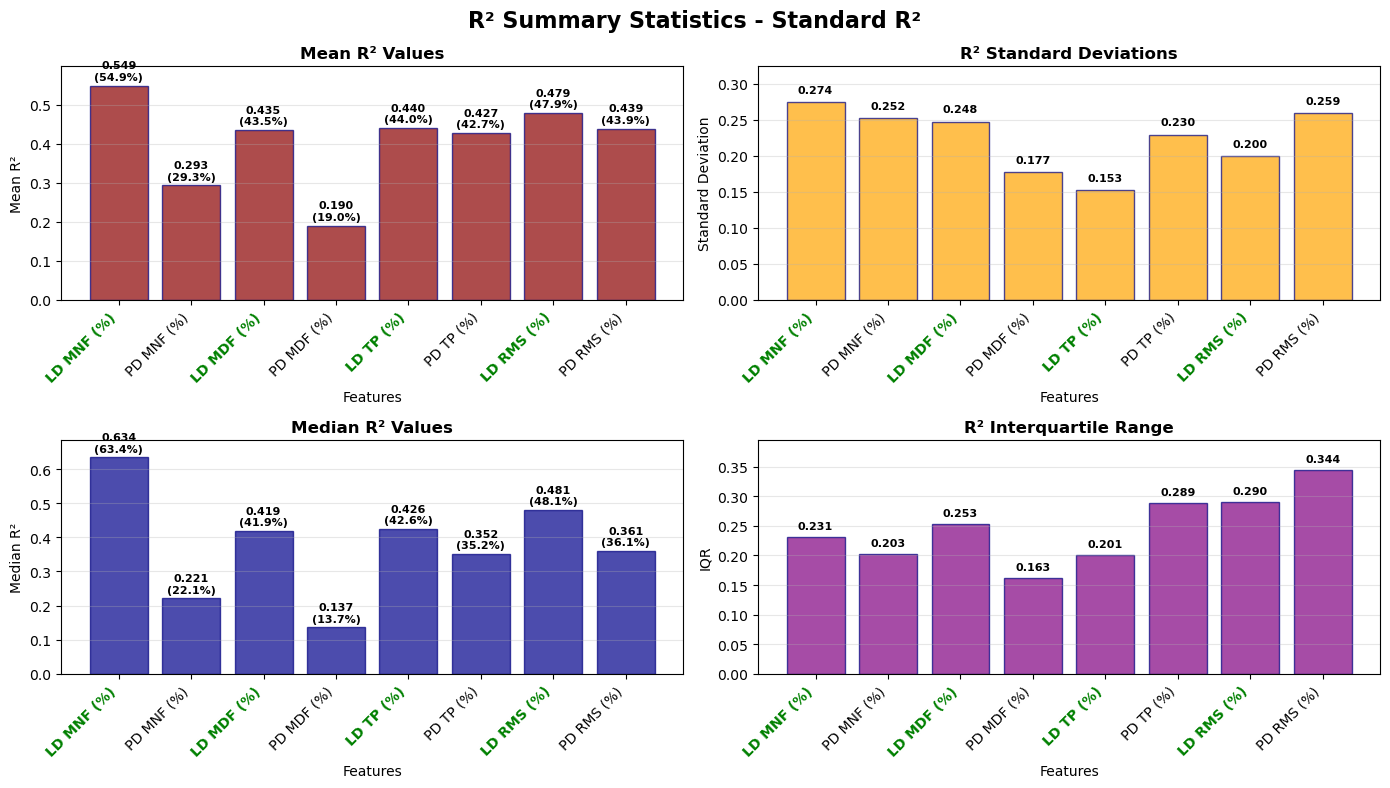

In [84]:
"""
EMG Fatigue Correlation Analysis Module
Provides zero-intercept and standard correlation analysis for EMG fatigue data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from typing import List, Dict, Optional, Tuple, Union
import matplotlib.colors as mcolors


# =============================================================================
# CORRELATION CALCULATION FUNCTIONS
# =============================================================================

def calculate_zero_intercept_correlation(x_vals: np.ndarray, y_vals: np.ndarray) -> Tuple[float, float, float, float]:
    """
    Calculate correlation coefficient for line forced through origin.
    
    Returns:
        (correlation_coefficient, slope, r_squared_standard, r_squared_pearson)
    """
    numerator = np.sum(x_vals * y_vals)
    denominator = np.sqrt(np.sum(x_vals**2) * np.sum(y_vals**2))
    
    if denominator == 0:
        return 0.0, 0.0, 0.0, 0.0
    
    correlation = numerator / denominator
    
    # Calculate slope for line through origin
    slope = np.sum(x_vals * y_vals) / np.sum(x_vals**2) if np.sum(x_vals**2) != 0 else 0
    
    # Calculate standard R² for line through origin
    y_pred = slope * x_vals
    ss_res = np.sum((y_vals - y_pred)**2)
    ss_tot = np.sum(y_vals**2)
    r_squared_standard = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Calculate R² as squared Pearson correlation
    r_squared_pearson = correlation ** 2
    
    return correlation, slope, r_squared_standard, r_squared_pearson


def calculate_pearson_correlations(
    data_manager,
    features: List[str],
    subjects: Optional[List] = None,
    x_axis: str = 'completion_percentage',
    normalization: Optional[str] = None,
    outlier_removal: bool = False,
    outlier_z_threshold: float = 3.0,
    zero_intercept: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Calculate Pearson correlations between features and x_axis variable.
    
    Args:
        data_manager: DataManager object containing the dataset
        features: List of feature names to calculate correlations for
        subjects: List of subjects to include (None for all)
        x_axis: The x-axis variable (default: 'completion_percentage')
        normalization: Type of normalization ('standard', 'minmax', 'robust', or None)
        outlier_removal: Whether to remove outliers based on z-score
        outlier_z_threshold: Z-score threshold for outlier removal
        zero_intercept: Use zero-intercept correlation (recommended for EMG fatigue)
    
    Returns:
        (correlations_df, p_values_df, slopes_df, r2_standard_df, r2_pearson_df)
    """
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return pd.DataFrame(), pd.DataFrame(), None, None, None
    
    subjects_list = data['subject_id'].unique()
    
    # Validate features
    available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
    valid_features = [f for f in features if f in available_features]
    
    if not valid_features:
        print("No valid features found")
        return pd.DataFrame(), pd.DataFrame(), None, None, None
    
    # Initialize result containers
    correlations = []
    p_values = []
    slopes = [] if zero_intercept else None
    r2_standard = [] if zero_intercept else None
    r2_pearson = [] if zero_intercept else None
    
    for subject in subjects_list:
        subject_data = data[data['subject_id'] == subject].copy()
        
        if subject_data.empty:
            continue
        
        x_vals = subject_data[x_axis].values
        
        # Process each feature
        subject_results = _process_subject_features(
            subject, x_vals, subject_data, valid_features,
            outlier_removal, outlier_z_threshold, normalization, zero_intercept
        )
        
        correlations.append(subject_results['correlations'])
        p_values.append(subject_results['p_values'])
        
        if zero_intercept:
            slopes.append(subject_results['slopes'])
            r2_standard.append(subject_results['r2_standard'])
            r2_pearson.append(subject_results['r2_pearson'])
    
    # Create DataFrames
    columns = ['Subject'] + valid_features
    corr_df = pd.DataFrame(correlations, columns=columns).set_index('Subject')
    pval_df = pd.DataFrame(p_values, columns=columns).set_index('Subject')
    
    slopes_df = None
    r2_standard_df = None
    r2_pearson_df = None
    
    if zero_intercept:
        slopes_df = pd.DataFrame(slopes, columns=columns).set_index('Subject')
        r2_standard_df = pd.DataFrame(r2_standard, columns=columns).set_index('Subject')
        r2_pearson_df = pd.DataFrame(r2_pearson, columns=columns).set_index('Subject')
    
    return corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df


# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def _process_subject_features(
    subject, x_vals, subject_data, features,
    outlier_removal, outlier_z_threshold, normalization, zero_intercept
):
    """Process features for a single subject."""
    results = {
        'correlations': [subject],
        'p_values': [subject],
        'slopes': [subject] if zero_intercept else None,
        'r2_standard': [subject] if zero_intercept else None,
        'r2_pearson': [subject] if zero_intercept else None
    }
    
    for feature in features:
        y_vals = subject_data[feature].values
        
        # Clean data
        mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
        x_clean, y_clean = x_vals[mask], y_vals[mask]
        
        if len(x_clean) < 3:
            _append_nan_results(results, zero_intercept)
            continue
        
        # Remove outliers if requested
        if outlier_removal:
            x_clean, y_clean = _remove_outliers(x_clean, y_clean, outlier_z_threshold)
            if len(x_clean) < 3:
                _append_nan_results(results, zero_intercept)
                continue
        
        # Apply normalization if requested
        if normalization and not zero_intercept:
            x_clean, y_clean = _apply_normalization(x_clean, y_clean, normalization)
        
        # Calculate correlation
        try:
            if zero_intercept:
                corr, slope, r2_std, r2_pear = calculate_zero_intercept_correlation(x_clean, y_clean)
                p_value = _permutation_test_zero_intercept(x_clean, y_clean, corr)
                
                results['correlations'].append(corr)
                results['p_values'].append(p_value)
                results['slopes'].append(slope)
                results['r2_standard'].append(r2_std)
                results['r2_pearson'].append(r2_pear)
            else:
                corr, p_value = stats.pearsonr(x_clean, y_clean)
                results['correlations'].append(corr)
                results['p_values'].append(p_value)
        except Exception as e:
            print(f"Error calculating correlation for {feature}: {e}")
            _append_nan_results(results, zero_intercept)
    
    return results


def _append_nan_results(results, zero_intercept):
    """Append NaN values to results."""
    results['correlations'].append(np.nan)
    results['p_values'].append(np.nan)
    if zero_intercept:
        results['slopes'].append(np.nan)
        results['r2_standard'].append(np.nan)
        results['r2_pearson'].append(np.nan)


def _remove_outliers(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask]


def _apply_normalization(x_vals, y_vals, normalization_type):
    """Apply normalization to x and y values."""
    x_vals = x_vals.reshape(-1, 1)
    y_vals = y_vals.reshape(-1, 1)
    
    scalers = {
        'standard': (StandardScaler(), StandardScaler()),
        'minmax': (MinMaxScaler(), MinMaxScaler()),
        'robust': (RobustScaler(), RobustScaler())
    }
    
    if normalization_type not in scalers:
        raise ValueError(f"Unknown normalization type: {normalization_type}")
    
    scaler_x, scaler_y = scalers[normalization_type]
    x_normalized = scaler_x.fit_transform(x_vals).flatten()
    y_normalized = scaler_y.fit_transform(y_vals).flatten()
    
    return x_normalized, y_normalized


def _permutation_test_zero_intercept(x_vals, y_vals, observed_corr, n_permutations=1000):
    """Permutation test for zero-intercept correlation significance."""
    null_correlations = []
    
    for _ in range(n_permutations):
        y_shuffled = np.random.permutation(y_vals)
        null_corr, _, _, _ = calculate_zero_intercept_correlation(x_vals, y_shuffled)
        null_correlations.append(null_corr)
    
    null_correlations = np.array(null_correlations)
    p_value = np.mean(np.abs(null_correlations) >= np.abs(observed_corr))
    
    return p_value


def _format_value(value, decimals=2):
    """Format a value to specified decimal places."""
    if pd.isna(value):
        return ""
    return f"{value:.{decimals}f}"


# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_correlation_heatmap(
    corr_df: pd.DataFrame,
    p_values_df: Optional[pd.DataFrame] = None,
    feature_labels: Optional[Dict[str, str]] = None,
    figsize: Tuple[int, int] = (12, 8),
    title: str = "Pearson Correlations (Zero-Intercept)",
    save_path: Optional[str] = None,
    show_plot: bool = True,
    show_significance: bool = False
) -> plt.Figure:
    """
    Plot correlation heatmap with consistent text coloring.
    
    Args:
        corr_df: DataFrame with correlation coefficients
        p_values_df: DataFrame with p-values for significance testing
        feature_labels: Dictionary mapping feature names to display labels
        figsize: Figure size
        title: Plot title
        save_path: Path to save the plot
        show_plot: Whether to display the plot
        show_significance: Whether to show significance stars
    
    Returns:
        matplotlib Figure object
    """
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Apply feature labels
    display_corr_df = corr_df.copy()
    if feature_labels:
        display_corr_df.columns = [feature_labels.get(col, col) for col in display_corr_df.columns]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(
        display_corr_df.T,
        annot=False,
        cmap='RdBu_r',
        center=0,
        vmin=-1,
        vmax=1,
        ax=ax,
        cbar_kws={'label': 'Correlation Coefficient'},
        xticklabels=True,
        yticklabels=True,
        linewidths=0.5,
        linecolor='lightgray'
    )
    
    # Add text annotations with consistent coloring
    _add_heatmap_annotations(
        ax, display_corr_df, p_values_df, feature_labels, show_significance
    )
    
    # Style the plot
    _style_heatmap(ax, title, show_significance)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig


def _add_heatmap_annotations(ax, display_df, p_values_df, feature_labels, show_significance):
    """Add text annotations to heatmap with consistent coloring."""
    for i in range(len(display_df.index)):
        for j in range(len(display_df.columns)):
            value = display_df.iloc[i, j]
            
            if pd.isna(value):
                continue
            
            # Consistent text color logic
            abs_val = abs(value)
            if abs_val < 0.4:
                text_color = 'black'
                font_weight = 'normal'
            elif abs_val >= 0.7:
                text_color = 'white'
                font_weight = 'bold'
            else:
                # For medium values (0.4-0.7), use white for better contrast
                text_color = 'white' if abs_val >= 0.55 else 'black'
                font_weight = 'bold' if abs_val >= 0.55 else 'normal'
            
            # Format text
            text = f"{value:.2f}"
            
            # Add significance stars if requested
            if show_significance and p_values_df is not None:
                p_val = p_values_df.iloc[i, j] if not pd.isna(p_values_df.iloc[i, j]) else 1.0
                if p_val < 0.001:
                    text += "***"
                elif p_val < 0.01:
                    text += "**"
                elif p_val < 0.05:
                    text += "*"
            
            # Add annotation
            ax.text(
                i + 0.5, j + 0.5, text,
                ha='center', va='center',
                fontsize=9 if len(text) > 5 else 10,
                fontweight=font_weight,
                color=text_color
            )


def _style_heatmap(ax, title, show_significance):
    """Apply styling to heatmap."""
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Add significance legend if needed
    if show_significance:
        legend_text = "* p<0.05, ** p<0.01, *** p<0.001"
        ax.text(
            0.02, 0.02, legend_text,
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
        )
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)


def plot_correlation_summary(
    corr_df: pd.DataFrame,
    feature_labels: Optional[Dict[str, str]] = None,
    figsize: Tuple[int, int] = (10, 6),
    title: str = "Correlation Summary Statistics",
    save_path: Optional[str] = None,
    show_plot: bool = True
) -> plt.Figure:
    """Plot summary statistics of correlations across subjects."""
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Calculate statistics
    mean_corr = corr_df.mean()
    std_corr = corr_df.std()
    
    # Apply feature labels
    if feature_labels:
        display_features = [feature_labels.get(col, col) for col in mean_corr.index]
    else:
        display_features = mean_corr.index
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot mean correlations
    _plot_bar_chart(
        ax1, mean_corr.values, display_features,
        'Mean Correlation Coefficients', 'Mean Correlation',
        color='skyblue', symmetric=True
    )
    
    # Plot standard deviations
    _plot_bar_chart(
        ax2, std_corr.values, display_features,
        'Correlation Standard Deviations', 'Standard Deviation',
        color='lightcoral', symmetric=False
    )
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig


def _plot_bar_chart(ax, values, labels, title, ylabel, color='skyblue', symmetric=False):
    """Helper function to plot bar charts."""
    bars = ax.bar(range(len(values)), values, color=color, alpha=0.7, edgecolor='navy')
    
    ax.set_xlabel('Features')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    if symmetric:
        max_abs = max(abs(values.min()), abs(values.max()))
        y_limit = max_abs + 0.1
        ax.set_ylim(-y_limit, y_limit)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    else:
        ax.set_ylim(0, values.max() + 0.05)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        y_pos = height + (0.02 if height >= 0 else -0.02)
        va = 'bottom' if height >= 0 else 'top'
        ax.text(
            bar.get_x() + bar.get_width()/2., y_pos,
            f'{val:.2f}', ha='center', va=va, fontsize=9
        )
    
    # Color LD features
    x_labels = ax.get_xticklabels()
    for label in x_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')


def print_correlation_summary(
    corr_df: pd.DataFrame,
    p_values_df: Optional[pd.DataFrame] = None,
    slopes_df: Optional[pd.DataFrame] = None,
    r2_standard_df: Optional[pd.DataFrame] = None,
    r2_pearson_df: Optional[pd.DataFrame] = None,
    feature_labels: Optional[Dict[str, str]] = None,
    zero_intercept: bool = True
):
    """Print comprehensive correlation analysis summary."""
    method_name = "Zero-Intercept" if zero_intercept else "Standard Pearson"
    
    print("=" * 80)
    print(f"EMG FATIGUE CORRELATION ANALYSIS SUMMARY - {method_name}")
    print("=" * 80)
    
    if zero_intercept:
        print("Method: Forced through Origin (Recommended for EMG Fatigue)")
    else:
        print("Method: Standard Pearson Correlation")
    
    print("\nFeature Analysis:")
    print("-" * 80)
    
    for feature in corr_df.columns:
        display_name = feature_labels.get(feature, feature) if feature_labels else feature
        
        print(f"\n{display_name}:")
        
        # Basic statistics
        corr_vals = corr_df[feature].dropna()
        print(f"  Correlation: μ={corr_vals.mean():6.3f}, σ={corr_vals.std():6.3f}")
        print(f"               Range=[{corr_vals.min():6.3f}, {corr_vals.max():6.3f}]")
        
        # Additional metrics for zero-intercept
        if zero_intercept and slopes_df is not None:
            slope_vals = slopes_df[feature].dropna()
            print(f"  Fatigue Rate: μ={slope_vals.mean():6.3f}, σ={slope_vals.std():6.3f}")
        
        if r2_standard_df is not None:
            r2_vals = r2_standard_df[feature].dropna()
            print(f"  R²: μ={r2_vals.mean():6.3f} ({r2_vals.mean()*100:.1f}% variance explained)")
        
        # Significance
        if p_values_df is not None:
            sig_count = (p_values_df[feature] < 0.05).sum()
            total = p_values_df[feature].notna().sum()
            print(f"  Significant: {sig_count}/{total} subjects ({sig_count/total*100:.1f}%)")
    
    print("\n" + "=" * 80)


# =============================================================================
# PRESET CONFIGURATIONS
# =============================================================================

class EMGCorrelationConfig:
    """Standard configuration for EMG correlation analysis."""
    
    FEATURES = [
        'ch2_mean_power_freq_max_pct_change',
        'ch1_mean_power_freq_max_pct_change',
        'ch2_median_power_freq_max_pct_change',
        'ch1_median_power_freq_max_pct_change',
        'ch2_total_power_max_pct_change',
        'ch1_total_power_max_pct_change',
        'ch2_rms_max_pct_change',
        'ch1_rms_max_pct_change'
    ]
    
    FEATURE_LABELS = {
        'ch2_mean_power_freq_max_pct_change': 'LD MNF (%)',
        'ch1_mean_power_freq_max_pct_change': 'PD MNF (%)',
        'ch2_median_power_freq_max_pct_change': 'LD MDF (%)',
        'ch1_median_power_freq_max_pct_change': 'PD MDF (%)',
        'ch2_total_power_max_pct_change': 'LD TP (%)',
        'ch1_total_power_max_pct_change': 'PD TP (%)',
        'ch2_rms_max_pct_change': 'LD RMS (%)',
        'ch1_rms_max_pct_change': 'PD RMS (%)'
    }

def plot_r2_heatmap(
    r2_df: pd.DataFrame,
    p_values_df: Optional[pd.DataFrame] = None,
    feature_labels: Optional[Dict[str, str]] = None,
    figsize: Tuple[int, int] = (12, 8),
    title: str = "R² Values (Coefficient of Determination)",
    save_path: Optional[str] = None,
    show_plot: bool = True,
    show_significance: bool = False,
    r2_type: str = "standard"
) -> plt.Figure:
    """
    Plot R² heatmap showing explained variance.
    
    Args:
        r2_df: DataFrame with R² values
        p_values_df: DataFrame with p-values for significance testing
        feature_labels: Dictionary mapping feature names to display labels
        figsize: Figure size
        title: Plot title
        save_path: Path to save the plot
        show_plot: Whether to display the plot
        show_significance: Whether to show significance stars
        r2_type: Type of R² ("standard" or "pearson")
    
    Returns:
        matplotlib Figure object
    """
    if r2_df is None or r2_df.empty:
        print("No R² data to plot")
        return None
    
    # Apply feature labels
    display_r2_df = r2_df.copy()
    if feature_labels:
        display_r2_df.columns = [feature_labels.get(col, col) for col in display_r2_df.columns]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap with R² appropriate colormap (0 to 1 range)
    sns.heatmap(
        display_r2_df.T,
        annot=False,
        cmap='Reds',  # Red colormap for R² values
        vmin=0,
        vmax=1,
        ax=ax,
        cbar_kws={'label': 'R² (Explained Variance)'},
        xticklabels=True,
        yticklabels=True,
        linewidths=0.5,
        linecolor='lightgray'
    )
    
    # Add text annotations with appropriate coloring for R² values
    _add_r2_heatmap_annotations(
        ax, display_r2_df, p_values_df, feature_labels, show_significance
    )
    
    # Style the plot
    _style_heatmap(ax, title, show_significance)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"R² heatmap saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig


def _add_r2_heatmap_annotations(ax, display_df, p_values_df, feature_labels, show_significance):
    """Add text annotations to R² heatmap with appropriate coloring."""
    for i in range(len(display_df.index)):
        for j in range(len(display_df.columns)):
            value = display_df.iloc[i, j]
            
            if pd.isna(value):
                continue
            
            # Text color logic for R² values (0 to 1 range)
            # Use white text for darker red backgrounds (higher R²)
            if value > 0.5:
                text_color = 'white'
                font_weight = 'bold'
            elif value > 0.25:
                text_color = 'black'
                font_weight = 'bold'
            else:
                text_color = 'black'
                font_weight = 'normal'
            
            # Format text as percentage
            text = f"{value:.3f}"
            
            # Add significance stars if requested
            if show_significance and p_values_df is not None:
                p_val = p_values_df.iloc[i, j] if not pd.isna(p_values_df.iloc[i, j]) else 1.0
                if p_val < 0.001:
                    text += "***"
                elif p_val < 0.01:
                    text += "**"
                elif p_val < 0.05:
                    text += "*"
            
            # Add annotation
            ax.text(
                i + 0.5, j + 0.5, text,
                ha='center', va='center',
                fontsize=9 if len(text) > 6 else 10,
                fontweight=font_weight,
                color=text_color
            )


def plot_r2_summary(
    r2_df: pd.DataFrame,
    feature_labels: Optional[Dict[str, str]] = None,
    figsize: Tuple[int, int] = (14, 8),
    title: str = "R² Summary Statistics",
    save_path: Optional[str] = None,
    show_plot: bool = True,
    r2_type: str = "standard"
) -> plt.Figure:
    """
    Plot comprehensive summary statistics of R² values across subjects.
    
    Args:
        r2_df: DataFrame with R² values
        feature_labels: Dictionary mapping feature names to display labels
        figsize: Figure size
        title: Plot title
        save_path: Path to save the plot
        show_plot: Whether to display the plot
        r2_type: Type of R² ("standard" or "pearson")
    
    Returns:
        matplotlib Figure object
    """
    if r2_df is None or r2_df.empty:
        print("No R² data to plot")
        return None
    
    # Calculate statistics
    mean_r2 = r2_df.mean()
    std_r2 = r2_df.std()
    median_r2 = r2_df.median()
    q75_r2 = r2_df.quantile(0.75)
    q25_r2 = r2_df.quantile(0.25)
    
    # Apply feature labels
    if feature_labels:
        display_features = [feature_labels.get(col, col) for col in mean_r2.index]
    else:
        display_features = mean_r2.index
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: Mean R² values
    _plot_r2_bar_chart(
        ax1, mean_r2.values, display_features,
        'Mean R² Values', 'Mean R²',
        color='darkred', show_percentage=True
    )
    
    # Plot 2: R² variability (standard deviation)
    _plot_r2_bar_chart(
        ax2, std_r2.values, display_features,
        'R² Standard Deviations', 'Standard Deviation',
        color='orange', show_percentage=False
    )
    
    # Plot 3: Median R² values
    _plot_r2_bar_chart(
        ax3, median_r2.values, display_features,
        'Median R² Values', 'Median R²',
        color='darkblue', show_percentage=True
    )
    
    # Plot 4: Interquartile range
    iqr_values = q75_r2.values - q25_r2.values
    _plot_r2_bar_chart(
        ax4, iqr_values, display_features,
        'R² Interquartile Range', 'IQR',
        color='purple', show_percentage=False
    )
    
    plt.suptitle(f"{title} - {r2_type.title()} R²", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"R² summary plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig


def _plot_r2_bar_chart(ax, values, labels, title, ylabel, color='darkred', show_percentage=True):
    """Helper function to plot R² bar charts."""
    bars = ax.bar(range(len(values)), values, color=color, alpha=0.7, edgecolor='navy')
    
    ax.set_xlabel('Features')
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set y-axis limits appropriate for R² values
    ax.set_ylim(0, max(values.max() + 0.05, 0.1))
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        if show_percentage:
            label_text = f'{val:.3f}\n({val*100:.1f}%)'
        else:
            label_text = f'{val:.3f}'
        
        ax.text(
            bar.get_x() + bar.get_width()/2., height + 0.01,
            label_text, ha='center', va='bottom', 
            fontsize=8, fontweight='bold'
        )
    
    # Color LD features
    x_labels = ax.get_xticklabels()
    for label in x_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')


def plot_combined_r2_comparison(
    r2_standard_df: Optional[pd.DataFrame] = None,
    r2_pearson_df: Optional[pd.DataFrame] = None,
    feature_labels: Optional[Dict[str, str]] = None,
    figsize: Tuple[int, int] = (16, 6),
    title: str = "R² Comparison: Standard vs Pearson²",
    save_path: Optional[str] = None,
    show_plot: bool = True
) -> plt.Figure:
    """
    Plot comparison between standard R² and squared Pearson correlation.
    
    Args:
        r2_standard_df: DataFrame with standard R² values
        r2_pearson_df: DataFrame with Pearson² values
        feature_labels: Dictionary mapping feature names to display labels
        figsize: Figure size
        title: Plot title
        save_path: Path to save the plot
        show_plot: Whether to display the plot
    
    Returns:
        matplotlib Figure object
    """
    if r2_standard_df is None and r2_pearson_df is None:
        print("No R² data to compare")
        return None
    
    # Determine which data to use
    if r2_standard_df is not None and r2_pearson_df is not None:
        # Both available - create comparison
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        
        # Calculate means
        mean_standard = r2_standard_df.mean()
        mean_pearson = r2_pearson_df.mean()
        
        # Apply feature labels
        if feature_labels:
            display_features = [feature_labels.get(col, col) for col in mean_standard.index]
        else:
            display_features = mean_standard.index
        
        # Plot 1: Standard R²
        _plot_r2_bar_chart(
            ax1, mean_standard.values, display_features,
            'Standard R² (Line through Origin)', 'Mean R²',
            color='darkred', show_percentage=True
        )
        
        # Plot 2: Pearson²
        _plot_r2_bar_chart(
            ax2, mean_pearson.values, display_features,
            'Pearson² R²', 'Mean R²',
            color='darkblue', show_percentage=True
        )
        
        # Plot 3: Difference
        diff_values = mean_standard.values - mean_pearson.values
        bars = ax3.bar(range(len(diff_values)), diff_values, 
                      color=['green' if x >= 0 else 'red' for x in diff_values], 
                      alpha=0.7, edgecolor='navy')
        
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Difference (Standard - Pearson²)')
        ax3.set_title('Difference: Standard R² - Pearson²', fontsize=12, fontweight='bold')
        ax3.set_xticks(range(len(diff_values)))
        ax3.set_xticklabels(display_features, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
        
        # Add value labels
        for bar, val in zip(bars, diff_values):
            height = bar.get_height()
            y_pos = height + (0.005 if height >= 0 else -0.005)
            va = 'bottom' if height >= 0 else 'top'
            ax3.text(
                bar.get_x() + bar.get_width()/2., y_pos,
                f'{val:.3f}', ha='center', va=va, 
                fontsize=8, fontweight='bold'
            )
        
        # Color LD features in difference plot
        x_labels = ax3.get_xticklabels()
        for label in x_labels:
            if 'LD' in label.get_text():
                label.set_color('green')
                label.set_weight('bold')
                
    else:
        # Only one type available
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        if r2_standard_df is not None:
            mean_r2 = r2_standard_df.mean()
            plot_title = 'Standard R² (Line through Origin)'
            color = 'darkred'
        else:
            mean_r2 = r2_pearson_df.mean()
            plot_title = 'Pearson² R²'
            color = 'darkblue'
        
        # Apply feature labels
        if feature_labels:
            display_features = [feature_labels.get(col, col) for col in mean_r2.index]
        else:
            display_features = mean_r2.index
        
        _plot_r2_bar_chart(
            ax, mean_r2.values, display_features,
            plot_title, 'Mean R²',
            color=color, show_percentage=True
        )
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"R² comparison plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig


def print_r2_summary(
    r2_standard_df: Optional[pd.DataFrame] = None,
    r2_pearson_df: Optional[pd.DataFrame] = None,
    feature_labels: Optional[Dict[str, str]] = None
):
    """Print comprehensive R² analysis summary."""
    print("\n" + "=" * 80)
    print("R² (COEFFICIENT OF DETERMINATION) ANALYSIS SUMMARY")
    print("=" * 80)
    
    if r2_standard_df is not None:
        print("\nSTANDARD R² (Line forced through origin):")
        print("-" * 50)
        _print_r2_stats(r2_standard_df, feature_labels, "Standard")
    
    if r2_pearson_df is not None:
        print("\nPEARSON² R² (Squared correlation coefficient):")
        print("-" * 50)
        _print_r2_stats(r2_pearson_df, feature_labels, "Pearson²")
    
    if r2_standard_df is not None and r2_pearson_df is not None:
        print("\nCOMPARISON (Standard R² vs Pearson² R²):")
        print("-" * 50)
        
        for feature in r2_standard_df.columns:
            display_name = feature_labels.get(feature, feature) if feature_labels else feature
            
            std_vals = r2_standard_df[feature].dropna()
            pear_vals = r2_pearson_df[feature].dropna()
            
            if len(std_vals) > 0 and len(pear_vals) > 0:
                diff_mean = std_vals.mean() - pear_vals.mean()
                print(f"  {display_name}:")
                print(f"    Standard: {std_vals.mean():.3f} ({std_vals.mean()*100:.1f}%)")
                print(f"    Pearson²: {pear_vals.mean():.3f} ({pear_vals.mean()*100:.1f}%)")
                print(f"    Difference: {diff_mean:+.3f} ({diff_mean*100:+.1f}%)")
    
    print("\n" + "=" * 80)


def _print_r2_stats(r2_df, feature_labels, r2_type):
    """Helper function to print R² statistics."""
    for feature in r2_df.columns:
        display_name = feature_labels.get(feature, feature) if feature_labels else feature
        
        r2_vals = r2_df[feature].dropna()
        if len(r2_vals) == 0:
            continue
            
        print(f"\n  {display_name}:")
        print(f"    Mean: {r2_vals.mean():.3f} ({r2_vals.mean()*100:.1f}% variance explained)")
        print(f"    Median: {r2_vals.median():.3f} ({r2_vals.median()*100:.1f}%)")
        print(f"    Std Dev: {r2_vals.std():.3f}")
        print(f"    Range: [{r2_vals.min():.3f}, {r2_vals.max():.3f}]")
        
        # Quality assessment
        excellent = (r2_vals >= 0.7).sum()
        good = ((r2_vals >= 0.5) & (r2_vals < 0.7)).sum()
        moderate = ((r2_vals >= 0.3) & (r2_vals < 0.5)).sum()
        poor = (r2_vals < 0.3).sum()
        total = len(r2_vals)
        
        print(f"    Quality: Excellent(≥0.7): {excellent}/{total} ({excellent/total*100:.1f}%)")
        print(f"             Good(0.5-0.7): {good}/{total} ({good/total*100:.1f}%)")
        print(f"             Moderate(0.3-0.5): {moderate}/{total} ({moderate/total*100:.1f}%)")
        print(f"             Poor(<0.3): {poor}/{total} ({poor/total*100:.1f}%)")


# =============================================================================
# MAIN ANALYSIS FUNCTION
# =============================================================================

def run_correlation_analysis(
    data_manager,
    features: Optional[List[str]] = None,
    feature_labels: Optional[Dict[str, str]] = None,
    subjects: Optional[List] = None,
    zero_intercept: bool = True,
    outlier_removal: bool = False,
    save_plots: bool = False,
    plot_dir: str = "./plots"
) -> Dict:
    """
    Run complete correlation analysis with all visualizations.
    
    Args:
        data_manager: DataManager object
        features: List of features (uses default if None)
        feature_labels: Feature labels (uses default if None)
        subjects: List of subjects (uses all if None)
        zero_intercept: Use zero-intercept correlation
        outlier_removal: Remove outliers
        save_plots: Save plots to files
        plot_dir: Directory for saving plots
    
    Returns:
        Dictionary with all results DataFrames
    """
    # Use defaults if not provided
    if features is None:
        features = EMGCorrelationConfig.FEATURES
    if feature_labels is None:
        feature_labels = EMGCorrelationConfig.FEATURE_LABELS
    
    # Calculate correlations
    print("Calculating correlations...")
    results = calculate_pearson_correlations(
        data_manager, features, subjects,
        zero_intercept=zero_intercept,
        outlier_removal=outlier_removal
    )
    
    corr_df, pval_df, slopes_df, r2_std_df, r2_pear_df = results
    
    # Print summary
    print_correlation_summary(
        corr_df, pval_df, slopes_df, r2_std_df, r2_pear_df,
        feature_labels, zero_intercept
    )
    
    # Create visualizations
    print("\nGenerating visualizations...")
    
    # Basic heatmap
    plot_correlation_heatmap(
        corr_df, pval_df, feature_labels,
        title=f"Correlations ({'Zero-Intercept' if zero_intercept else 'Standard'})",
        save_path=f"{plot_dir}/correlation_heatmap.png" if save_plots else None
    )
    
    # Heatmap with significance
    plot_correlation_heatmap(
        corr_df, pval_df, feature_labels,
        title=f"Correlations with Significance ({'Zero-Intercept' if zero_intercept else 'Standard'})",
        show_significance=True,
        save_path=f"{plot_dir}/correlation_heatmap_sig.png" if save_plots else None
    )
    
    # Summary statistics
    plot_correlation_summary(
        corr_df, feature_labels,
        save_path=f"{plot_dir}/correlation_summary.png" if save_plots else None
    )
    
    return {
        'correlations': corr_df,
        'p_values': pval_df,
        'slopes': slopes_df,
        'r2_standard': r2_std_df,
        'r2_pearson': r2_pear_df
    }


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    # Example usage
    print("EMG Fatigue Correlation Analysis Module")
    print("Use run_correlation_analysis() for complete analysis")
    
    # # Example:
    # results = run_correlation_analysis(
    #     manager,
    #     zero_intercept=True,
    #     outlier_removal=True,
    #     save_plots=True
    # )
    # Generate all plots including R² analysis
    results = run_correlation_analysis(
        manager,
        zero_intercept=True,
        save_plots=False,
        plot_dir="./emg_analysis_plots"
    )

    # Access the R² data
    r2_standard = results['r2_standard']
    r2_pearson = results['r2_pearson']

    # Generate only specific R² plots
    plot_r2_heatmap(
        r2_standard, 
        feature_labels=EMGCorrelationConfig.FEATURE_LABELS,
        title="Explained Variance Heatmap",
        show_significance=True
    )

    # Create detailed R² summary
    plot_r2_summary(
        r2_standard,
        feature_labels=EMGCorrelationConfig.FEATURE_LABELS
    )

EMG FATIGUE CORRELATION ANALYSIS SUMMARY - Enhanced Spearman
Method: Spearman Rank Correlation with Enhanced Metrics
Note: Measures monotonic relationships and rank-based patterns

LD MNF (%):
-----------
  Correlation:  Mean = -0.361, Std =  0.298
                Range = [-0.711,  0.123]
  Rank Slope:   Mean =  0.664, Std =  0.074
                → Rank-based rate of change per rank unit
  R²:           Mean =  0.208 (20.8% rank variance)
  Significant:  6/8 subjects (75.0%) at p<0.05

PD MNF (%):
-----------
  Correlation:  Mean = -0.282, Std =  0.222
                Range = [-0.726,  0.001]
  Rank Slope:   Mean =  0.683, Std =  0.055
                → Rank-based rate of change per rank unit
  R²:           Mean =  0.123 (12.3% rank variance)
  Significant:  5/8 subjects (62.5%) at p<0.05

LD MDF (%):
-----------
  Correlation:  Mean = -0.346, Std =  0.308
                Range = [-0.786,  0.134]
  Rank Slope:   Mean =  0.668, Std =  0.075
                → Rank-based rate of change 

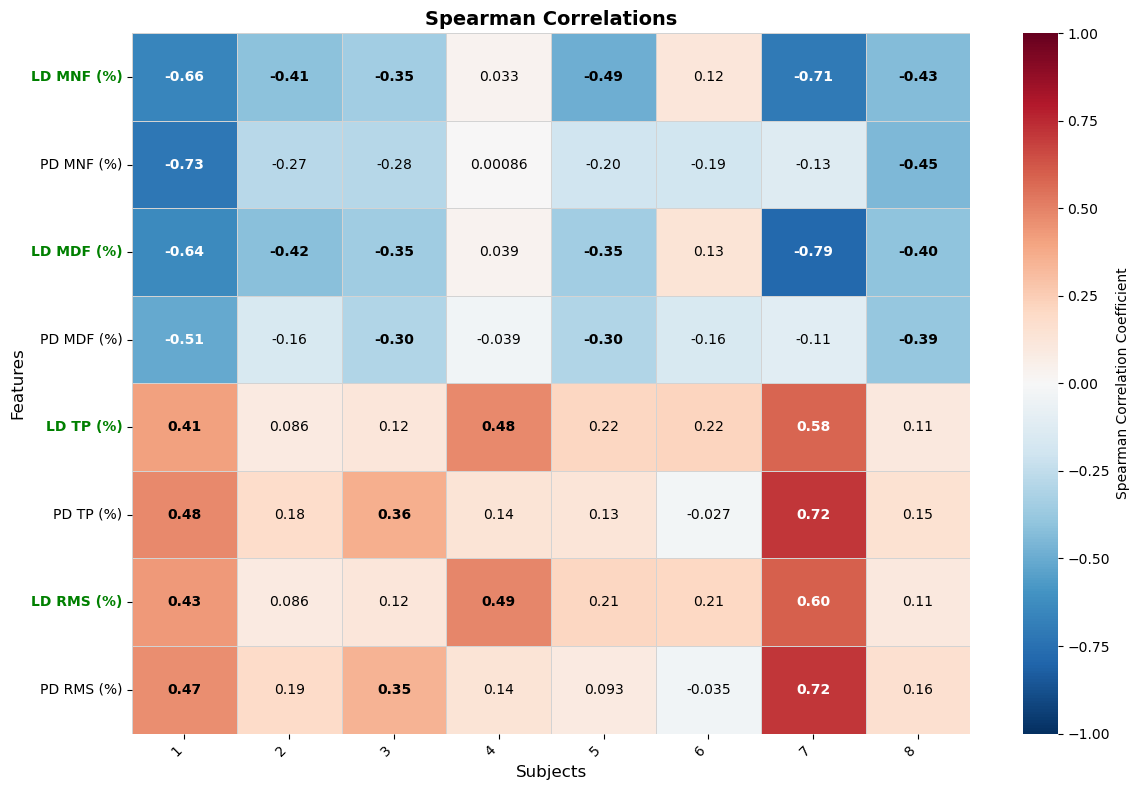

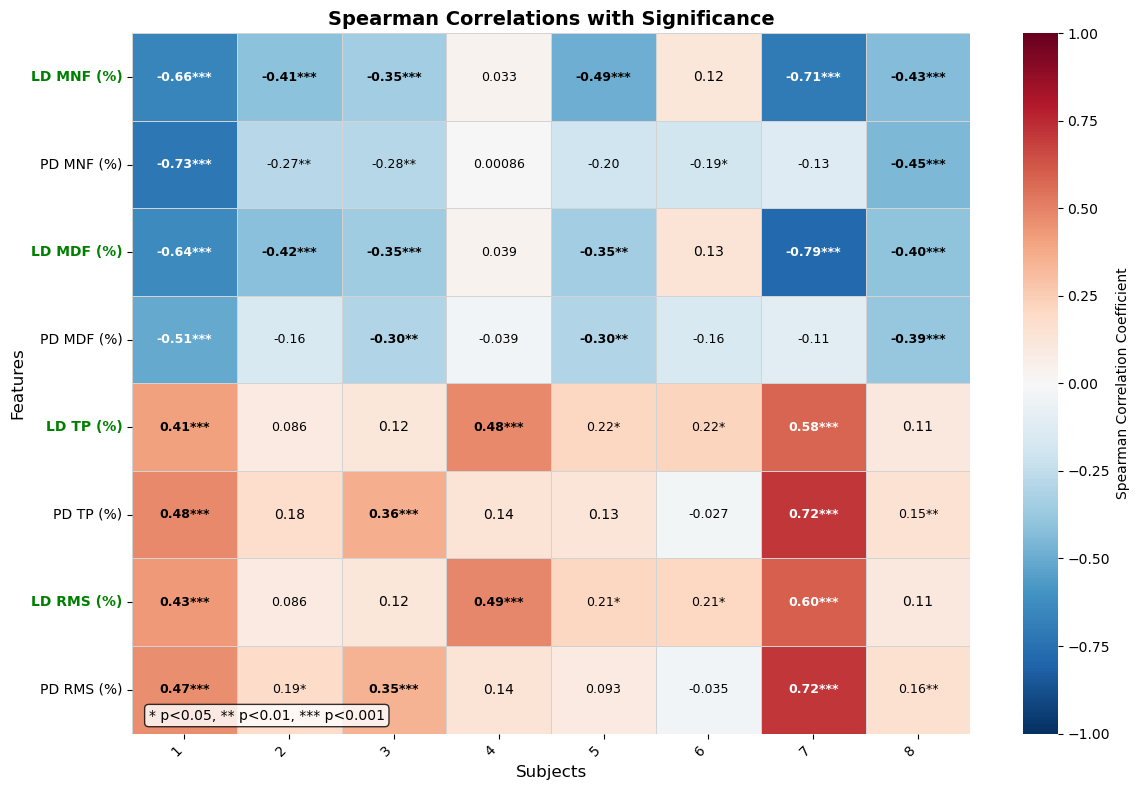

Mean correlation y-axis limits: [-0.46, 0.46]
Standard deviation y-axis limits: [0, 0.36]


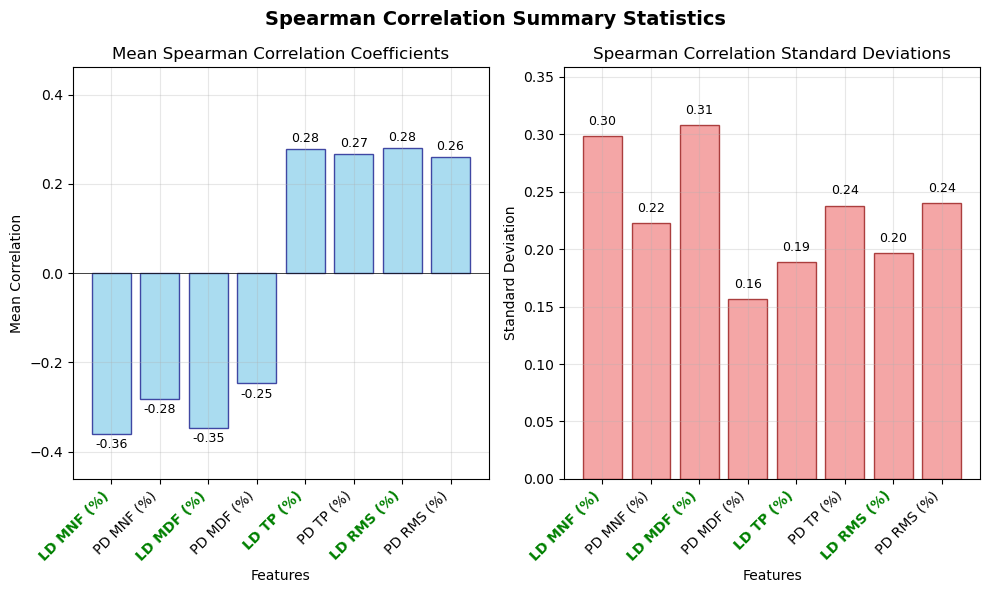

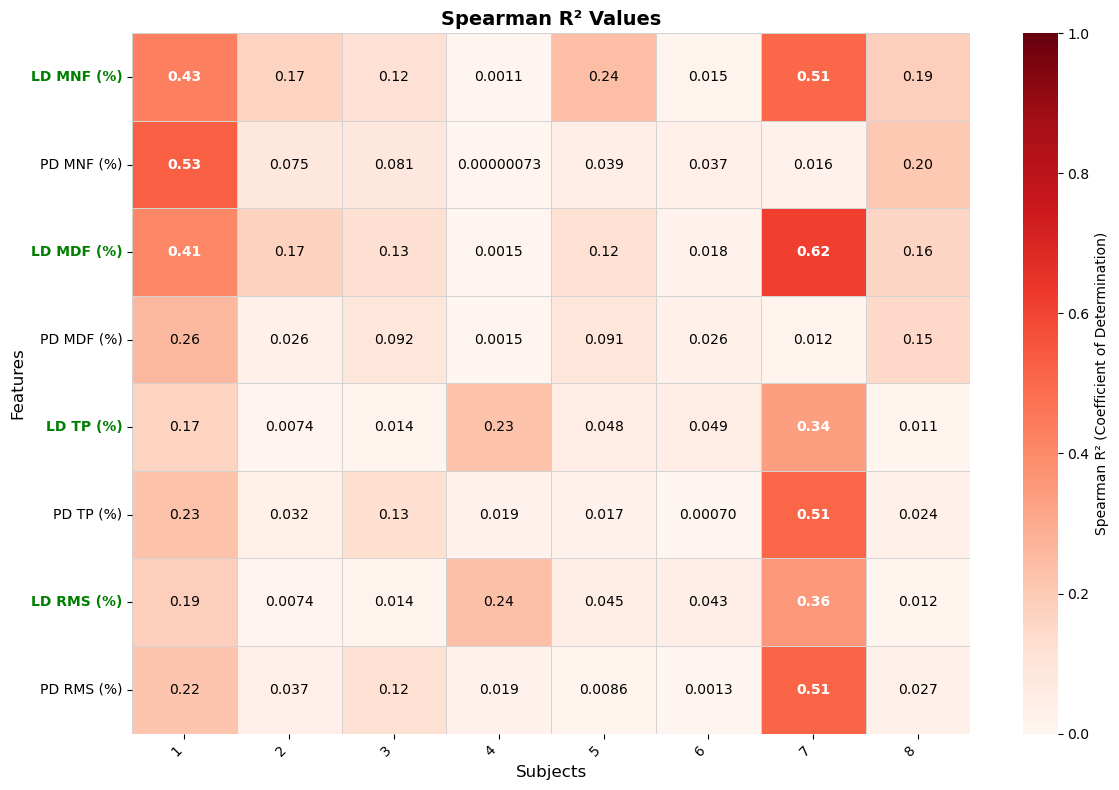

Mean R² y-axis limits: [0, 0.258]
R² standard deviation y-axis limits: [0, 0.233]


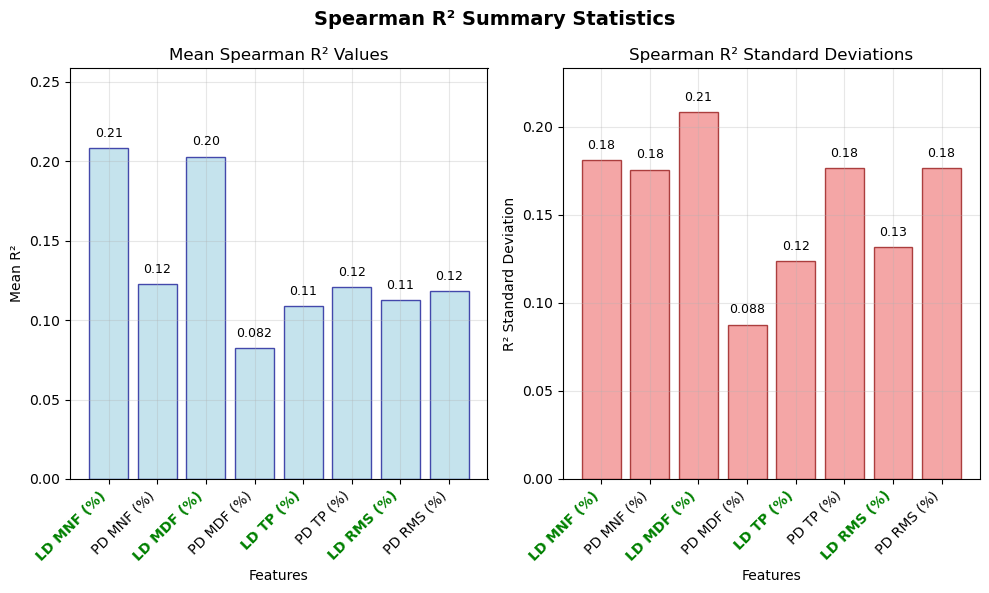

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from typing import List, Dict, Optional, Tuple, Union
import matplotlib.colors as mcolors

def calculate_zero_intercept_spearman(x_vals, y_vals):
    """
    Calculate Spearman correlation coefficient considering rank relationships from origin.
    Note: For Spearman, we still calculate standard rank correlation as it's inherently
    about monotonic relationships, but we provide similar output structure as Pearson.
    
    Parameters:
    -----------
    x_vals : array-like
        X values (e.g., completion_percentage)
    y_vals : array-like
        Y values (e.g., EMG features)
    
    Returns:
    --------
    Tuple[float, float, float, float]
        (spearman_coefficient, rank_slope, spearman_r_squared, spearman_r_squared_duplicate)
        Note: For Spearman, slope is calculated on ranks, R² values are identical
    """
    # Calculate standard Spearman correlation
    spearman_coef, _ = stats.spearmanr(x_vals, y_vals)
    
    # For additional metrics, work with ranks
    x_ranks = stats.rankdata(x_vals)
    y_ranks = stats.rankdata(y_vals)
    
    # Calculate slope on ranks (similar to Pearson approach)
    rank_slope = np.sum(x_ranks * y_ranks) / np.sum(x_ranks**2) if np.sum(x_ranks**2) != 0 else 0
    
    # R² for Spearman is simply correlation squared
    spearman_r_squared = spearman_coef ** 2
    
    return spearman_coef, rank_slope, spearman_r_squared, spearman_r_squared

def _permutation_test_spearman(x_vals, y_vals, observed_corr, n_permutations=1000):
    """
    Permutation test for Spearman correlation significance.
    
    Parameters:
    -----------
    x_vals : array-like
        X values
    y_vals : array-like
        Y values  
    observed_corr : float
        Observed Spearman correlation coefficient
    n_permutations : int
        Number of permutations for the test
    
    Returns:
    --------
    float
        P-value from permutation test
    """
    null_correlations = []
    
    for _ in range(n_permutations):
        # Shuffle y values while keeping x values fixed
        y_shuffled = np.random.permutation(y_vals)
        null_corr, _ = stats.spearmanr(x_vals, y_shuffled)
        null_correlations.append(null_corr)
    
    # Calculate p-value (two-tailed test)
    null_correlations = np.array(null_correlations)
    p_value = np.mean(np.abs(null_correlations) >= np.abs(observed_corr))
    
    return p_value

def calculate_spearman_correlations(data_manager, features: List[str], 
                                  subjects=None,
                                  x_axis: str = 'completion_percentage',
                                  normalization: Optional[str] = None,
                                  outlier_removal: bool = False,
                                  outlier_z_threshold: float = 3.0,
                                  zero_intercept: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Calculate Spearman correlations between features and x_axis variable.
    
    Parameters:
    -----------
    data_manager : DataManager object
        The data manager containing the dataset
    features : List[str]
        List of feature names to calculate correlations for
    subjects : list, optional
        List of subjects to include. If None, uses all subjects
    x_axis : str
        The x-axis variable (default: 'completion_percentage')
    normalization : str, optional
        Type of normalization: 'standard', 'minmax', 'robust', or None
        Note: For Spearman, normalization doesn't affect rank correlation
    outlier_removal : bool
        Whether to remove outliers based on z-score
    outlier_z_threshold : float
        Z-score threshold for outlier removal
    zero_intercept : bool
        Whether to use enhanced analysis with rank slopes and additional metrics
        If False, uses standard Spearman correlation only
    
    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame], Optional[pd.DataFrame]]
        (correlations_df, p_values_df, slopes_df, r2_standard_df, r2_pearson_df)
        - slopes_df, r2_standard_df, r2_pearson_df only for zero_intercept=True
    """
    
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return pd.DataFrame(), pd.DataFrame(), None, None, None
    
    subjects_list = data['subject_id'].unique()
    
    # Check feature availability
    available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
    valid_features = [f for f in features if f in available_features]
    invalid_features = [f for f in features if f not in available_features]
    
    if invalid_features:
        print(f"Invalid features (skipped): {invalid_features}")
    
    if not valid_features:
        print("No valid features found")
        return pd.DataFrame(), pd.DataFrame(), None, None, None
    
    correlations = []
    p_values = []
    slopes = [] if zero_intercept else None
    r2_standard = [] if zero_intercept else None
    r2_pearson = [] if zero_intercept else None
    
    for subject in subjects_list:
        subject_data = data[data['subject_id'] == subject].copy()
        
        if subject_data.empty:
            continue
        
        # Get x-axis values
        x_vals = subject_data[x_axis].values
        
        subject_corrs = [subject]
        subject_pvals = [subject]
        subject_slopes = [subject] if zero_intercept else None
        subject_r2_std = [subject] if zero_intercept else None
        subject_r2_pear = [subject] if zero_intercept else None
        
        for feature in valid_features:
            y_vals = subject_data[feature].values
            
            # Remove NaN values
            mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
            x_clean, y_clean = x_vals[mask], y_vals[mask]
            
            if len(x_clean) < 3:  # Need at least 3 points for meaningful correlation
                subject_corrs.append(np.nan)
                subject_pvals.append(np.nan)
                if subject_slopes is not None:
                    subject_slopes.append(np.nan)
                    subject_r2_std.append(np.nan)
                    subject_r2_pear.append(np.nan)
                continue
            
            # Remove outliers if requested
            if outlier_removal:
                x_clean, y_clean = _remove_outliers_spearman(x_clean, y_clean, outlier_z_threshold)
                if len(x_clean) < 3:
                    subject_corrs.append(np.nan)
                    subject_pvals.append(np.nan)
                    if subject_slopes is not None:
                        subject_slopes.append(np.nan)
                        subject_r2_std.append(np.nan)
                        subject_r2_pear.append(np.nan)
                    continue
            
            # Apply normalization if requested (note: doesn't affect Spearman correlation)
            if normalization and not zero_intercept:
                x_clean, y_clean = _apply_normalization(x_clean, y_clean, normalization)
                if normalization:
                    print(f"Warning: Normalization doesn't affect Spearman rank correlation")
            elif normalization and zero_intercept:
                print(f"Warning: Normalization with Spearman correlation analysis may not be meaningful")
            
            # Calculate correlation based on type
            try:
                if zero_intercept:
                    corr_coef, slope, r2_std, r2_pear = calculate_zero_intercept_spearman(x_clean, y_clean)
                    subject_corrs.append(corr_coef)
                    subject_slopes.append(slope)
                    subject_r2_std.append(r2_std)
                    subject_r2_pear.append(r2_pear)
                    
                    # For enhanced analysis, use permutation test for p-value
                    p_value = _permutation_test_spearman(x_clean, y_clean, corr_coef, n_permutations=1000)
                    subject_pvals.append(p_value)
                else:
                    corr_coef, p_value = stats.spearmanr(x_clean, y_clean)
                    subject_corrs.append(corr_coef)
                    subject_pvals.append(p_value)
                    
            except Exception as e:
                correlation_type = "enhanced Spearman" if zero_intercept else "standard Spearman"
                print(f"Error calculating {correlation_type} correlation for {feature}: {e}")
                subject_corrs.append(np.nan)
                subject_pvals.append(np.nan)
                if subject_slopes is not None:
                    subject_slopes.append(np.nan)
                    subject_r2_std.append(np.nan)
                    subject_r2_pear.append(np.nan)
        
        correlations.append(subject_corrs)
        p_values.append(subject_pvals)
        if slopes is not None:
            slopes.append(subject_slopes)
            r2_standard.append(subject_r2_std)
            r2_pearson.append(subject_r2_pear)
    
    # Create DataFrames
    columns = ['Subject'] + valid_features
    corr_df = pd.DataFrame(correlations, columns=columns).set_index('Subject')
    pval_df = pd.DataFrame(p_values, columns=columns).set_index('Subject')
    
    slopes_df = None
    r2_standard_df = None
    r2_pearson_df = None
    
    if slopes is not None:
        slopes_df = pd.DataFrame(slopes, columns=columns).set_index('Subject')
        r2_standard_df = pd.DataFrame(r2_standard, columns=columns).set_index('Subject')
        r2_pearson_df = pd.DataFrame(r2_pearson, columns=columns).set_index('Subject')
    
    return corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df

def _remove_outliers_spearman(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score for both x and y values."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask]

def _apply_normalization(x_vals, y_vals, normalization_type):
    """Apply normalization to x and y values."""
    # Reshape for sklearn
    x_vals = x_vals.reshape(-1, 1)
    y_vals = y_vals.reshape(-1, 1)
    
    if normalization_type == 'standard':
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
    elif normalization_type == 'minmax':
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
    elif normalization_type == 'robust':
        scaler_x = RobustScaler()
        scaler_y = RobustScaler()
    else:
        raise ValueError(f"Unknown normalization type: {normalization_type}")
    
    x_normalized = scaler_x.fit_transform(x_vals).flatten()
    y_normalized = scaler_y.fit_transform(y_vals).flatten()
    
    return x_normalized, y_normalized

def _format_to_2_sig_figs(value):
    """Format a number to 2 significant figures."""
    if pd.isna(value) or value == 0:
        return "0.0"
    
    # Handle the sign
    sign = "-" if value < 0 else ""
    abs_value = abs(value)
    
    # Find the order of magnitude
    if abs_value >= 1:
        # For numbers >= 1
        order = int(np.floor(np.log10(abs_value)))
        factor = 10 ** (order - 1)  # 2 sig figs means order-1
        rounded_value = round(abs_value / factor) * factor
        
        if order >= 1:
            return f"{sign}{rounded_value:.{max(0, 1-order)}f}"
        else:
            return f"{sign}{rounded_value:.1f}"
    else:
        # For numbers < 1
        order = int(np.floor(np.log10(abs_value)))
        decimals = abs(order) + 1  # Number of decimal places needed
        factor = 10 ** (order - 1)
        rounded_value = round(abs_value / factor) * factor
        return f"{sign}{rounded_value:.{decimals}f}"

def plot_correlation_heatmap(corr_df: pd.DataFrame, 
                           p_values_df: pd.DataFrame = None,
                           feature_labels: Dict[str, str] = None,
                           figsize: Tuple[int, int] = (12, 8),
                           cmap: str = 'RdBu_r',
                           center: float = 0,
                           alpha_threshold: float = 0.05,
                           mask_nonsignificant: bool = False,
                           title: str = "Spearman Correlations",
                           save_path: str = None,
                           show_plot: bool = True,
                           pale_threshold: float = 0.3) -> plt.Figure:
    """
    Improved correlation heatmap with better text visibility.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    p_values_df : pd.DataFrame, optional
        DataFrame with p-values for significance testing
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    cmap : str
        Colormap for the heatmap
    center : float
        Value to center the colormap at
    alpha_threshold : float
        P-value threshold for significance (default: 0.05)
    mask_nonsignificant : bool
        Whether to mask (hide) non-significant correlations
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    pale_threshold : float
        Threshold below which values get black text (default: 0.3)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Apply feature labels if provided
    display_corr_df = corr_df.copy()
    if feature_labels:
        display_corr_df.columns = [feature_labels.get(col, col) for col in display_corr_df.columns]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create significance mask if p-values provided
    mask = None
    if p_values_df is not None and mask_nonsignificant:
        display_pval_df = p_values_df.copy()
        if feature_labels:
            display_pval_df.columns = [feature_labels.get(col, col) for col in display_pval_df.columns]
        
        display_pval_df = display_pval_df.reindex(index=display_corr_df.index, 
                                                  columns=display_corr_df.columns)
        mask = display_pval_df > alpha_threshold
    
    # Create the base heatmap
    hm = sns.heatmap(display_corr_df.T, 
                     annot=False,  # We'll add custom annotations
                     fmt='',
                     cmap=cmap, 
                     center=center,
                     vmin=-1,
                     vmax=1,
                     ax=ax,
                     mask=mask.T if mask is not None else None,
                     cbar_kws={'label': 'Spearman Correlation Coefficient'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations with improved visibility
    for i in range(len(display_corr_df.index)):
        for j in range(len(display_corr_df.columns)):
            value = display_corr_df.iloc[i, j]
            
            # Skip NaN values
            if pd.isna(value):
                continue
            
            # Skip if masked (non-significant)
            if mask is not None and mask.iloc[i, j]:
                continue
            
            # Calculate text color based on value magnitude
            abs_val = abs(value)
            
            # Simple rule: use black text for low values, white for high values
            if abs_val < pale_threshold:
                text_color = 'black'
                font_weight = 'normal'
            else:
                # Higher correlation - determine based on background
                if value < -0.5:
                    text_color = 'white'  # Dark blue background
                elif value > 0.5:
                    text_color = 'white'  # Dark red background
                else:
                    text_color = 'black'  # Medium colors
                font_weight = 'bold'
            
            # Format the value
            text = _format_to_2_sig_figs(value)
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=10, 
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_correlation_heatmap_with_significance(corr_df: pd.DataFrame, 
                                             p_values_df: pd.DataFrame,
                                             feature_labels: Dict[str, str] = None,
                                             figsize: Tuple[int, int] = (12, 8),
                                             cmap: str = 'RdBu_r',
                                             center: float = 0,
                                             title: str = "Spearman Correlations with Significance",
                                             save_path: str = None,
                                             show_plot: bool = True,
                                             pale_threshold: float = 0.3) -> plt.Figure:
    """
    Improved correlation heatmap with significance stars and better text visibility.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    p_values_df : pd.DataFrame
        DataFrame with p-values for significance testing
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    cmap : str
        Colormap for the heatmap
    center : float
        Value to center the colormap at
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    pale_threshold : float
        Threshold below which values get black text (default: 0.3)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Apply feature labels if provided
    display_corr_df = corr_df.copy()
    display_pval_df = p_values_df.copy()
    
    if feature_labels:
        display_corr_df.columns = [feature_labels.get(col, col) for col in display_corr_df.columns]
        display_pval_df.columns = [feature_labels.get(col, col) for col in display_pval_df.columns]
    
    # Align indices and columns
    display_pval_df = display_pval_df.reindex(index=display_corr_df.index, 
                                              columns=display_corr_df.columns)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the base heatmap
    hm = sns.heatmap(display_corr_df.T, 
                     annot=False,
                     fmt='',
                     cmap=cmap, 
                     center=center,
                     vmin=-1,
                     vmax=1,
                     ax=ax,
                     cbar_kws={'label': 'Spearman Correlation Coefficient'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations with significance stars
    for i in range(len(display_corr_df.index)):
        for j in range(len(display_corr_df.columns)):
            corr_val = display_corr_df.iloc[i, j]
            p_val = display_pval_df.iloc[i, j]
            
            if pd.isna(corr_val):
                continue
            
            # Determine text color based on correlation magnitude
            abs_val = abs(corr_val)
            
            if abs_val < pale_threshold:
                text_color = 'black'
                font_weight = 'normal'
            else:
                # Higher correlation - determine based on value
                if corr_val < -0.5:
                    text_color = 'white'
                elif corr_val > 0.5:
                    text_color = 'white'
                else:
                    text_color = 'black'
                font_weight = 'bold'
            
            # Format correlation value
            corr_str = _format_to_2_sig_figs(corr_val)
            
            # Add significance stars if p-value available
            if not pd.isna(p_val):
                if p_val < 0.001:
                    stars = "***"
                elif p_val < 0.01:
                    stars = "**"
                elif p_val < 0.05:
                    stars = "*"
                else:
                    stars = ""
                text = f"{corr_str}{stars}"
            else:
                text = corr_str
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=9 if len(text) > 4 else 10,  # Smaller font for longer text
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Add legend for significance levels
    legend_text = "* p<0.05, ** p<0.01, *** p<0.001"
    ax.text(0.02, 0.02, legend_text, transform=ax.transAxes, 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
                                  facecolor="white", alpha=0.8))
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation heatmap with significance saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_correlation_summary(corr_df: pd.DataFrame,
                           feature_labels: Dict[str, str] = None,
                           figsize: Tuple[int, int] = (10, 6),
                           title: str = "Spearman Correlation Summary Statistics",
                           save_path: str = None,
                           show_plot: bool = True,
                           buffer: float = 0.1) -> plt.Figure:
    """
    Plot summary statistics of correlations across subjects with 2 sig fig formatting
    and symmetrical y-axis limits.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        DataFrame with correlation coefficients
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    buffer : float
        Buffer to add to the maximum absolute correlation value (default: 0.1)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if corr_df.empty:
        print("No correlation data to plot")
        return None
    
    # Calculate summary statistics
    mean_corr = corr_df.mean()
    std_corr = corr_df.std()
    
    # Calculate symmetrical y-axis limits for mean correlation plot
    max_abs_mean_corr = abs(mean_corr).max()
    y_limit_mean = max_abs_mean_corr + buffer
    
    # Apply feature labels if provided
    if feature_labels:
        display_features = [feature_labels.get(col, col) for col in mean_corr.index]
    else:
        display_features = mean_corr.index
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Use standard colors for bars
    colors1 = ['skyblue'] * len(display_features)
    colors2 = ['lightcoral'] * len(display_features)
    
    # Mean correlations bar plot
    bars1 = ax1.bar(range(len(mean_corr)), mean_corr.values, 
                    color=colors1, alpha=0.7, edgecolor='navy')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Mean Correlation')
    ax1.set_title('Mean Spearman Correlation Coefficients')
    ax1.set_xticks(range(len(mean_corr)))
    ax1.set_xticklabels(display_features, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Set symmetrical y-axis limits for mean correlation plot
    ax1.set_ylim(-y_limit_mean, y_limit_mean)
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars1, mean_corr.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        # Adjust text position based on bar height and y-limits
        text_offset = y_limit_mean * 0.02  # 2% of the y-limit range
        y_pos = height + text_offset if height >= 0 else height - text_offset
        ax1.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{formatted_val}', ha='center', 
                va='bottom' if height >= 0 else 'top',
                fontsize=9)
    
    # Standard deviation bar plot
    bars2 = ax2.bar(range(len(std_corr)), std_corr.values, 
                    color=colors2, alpha=0.7, edgecolor='darkred')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Standard Deviation')
    ax2.set_title('Spearman Correlation Standard Deviations')
    ax2.set_xticks(range(len(std_corr)))
    ax2.set_xticklabels(display_features, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Set y-axis limit for std plot (starts from 0)
    max_std = std_corr.max()
    ax2.set_ylim(0, max_std + buffer/2)  # Smaller buffer for std plot
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars2, std_corr.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        text_offset = (max_std + buffer/2) * 0.02  # 2% of the y-limit range
        ax2.text(bar.get_x() + bar.get_width()/2., height + text_offset,
                f'{formatted_val}', ha='center', va='bottom',
                fontsize=9)
    
    # Color x-axis labels for LD features (text only, not bars)
    for ax in [ax1, ax2]:
        labels = ax.get_xticklabels()
        for label in labels:
            if 'LD' in label.get_text():
                label.set_color('green')
                label.set_weight('bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Print the y-axis limits for reference
    print(f"Mean correlation y-axis limits: [{-y_limit_mean:.2f}, {y_limit_mean:.2f}]")
    print(f"Standard deviation y-axis limits: [0, {max_std + buffer/2:.2f}]")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Correlation summary plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_r_squared_summary(r2_df: pd.DataFrame,
                          feature_labels: Dict[str, str] = None,
                          figsize: Tuple[int, int] = (10, 6),
                          title: str = "Spearman R² Summary Statistics",
                          save_path: str = None,
                          show_plot: bool = True,
                          buffer: float = 0.05) -> plt.Figure:
    """
    Plot summary statistics of R² values across subjects.
    
    Parameters:
    -----------
    r2_df : pd.DataFrame
        DataFrame with R² values
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    buffer : float
        Buffer to add to the maximum R² value (default: 0.05)
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if r2_df.empty:
        print("No R² data to plot")
        return None
    
    # Calculate summary statistics
    mean_r2 = r2_df.mean()
    std_r2 = r2_df.std()
    
    # Apply feature labels if provided
    if feature_labels:
        display_features = [feature_labels.get(col, col) for col in mean_r2.index]
    else:
        display_features = mean_r2.index
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Use colors appropriate for R² (always positive)
    colors1 = ['lightblue'] * len(display_features)
    colors2 = ['lightcoral'] * len(display_features)
    
    # Mean R² bar plot
    bars1 = ax1.bar(range(len(mean_r2)), mean_r2.values, 
                    color=colors1, alpha=0.7, edgecolor='darkblue')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Mean R²')
    ax1.set_title('Mean Spearman R² Values')
    ax1.set_xticks(range(len(mean_r2)))
    ax1.set_xticklabels(display_features, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Set y-axis limits for R² (0 to max + buffer)
    max_r2 = mean_r2.max()
    ax1.set_ylim(0, max_r2 + buffer)
    
    # Add value labels on bars with 2 sig figs for R²
    for bar, val in zip(bars1, mean_r2.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        text_offset = (max_r2 + buffer) * 0.02  # 2% of the y-limit range
        ax1.text(bar.get_x() + bar.get_width()/2., height + text_offset,
                f'{formatted_val}', ha='center', va='bottom',
                fontsize=9)
    
    # Standard deviation bar plot
    bars2 = ax2.bar(range(len(std_r2)), std_r2.values, 
                    color=colors2, alpha=0.7, edgecolor='darkred')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('R² Standard Deviation')
    ax2.set_title('Spearman R² Standard Deviations')
    ax2.set_xticks(range(len(std_r2)))
    ax2.set_xticklabels(display_features, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Set y-axis limit for std plot (starts from 0)
    max_std = std_r2.max()
    ax2.set_ylim(0, max_std + buffer/2)  # Smaller buffer for std plot
    
    # Add value labels on bars with 2 sig figs
    for bar, val in zip(bars2, std_r2.values):
        height = bar.get_height()
        formatted_val = _format_to_2_sig_figs(val)
        text_offset = (max_std + buffer/2) * 0.02  # 2% of the y-limit range
        ax2.text(bar.get_x() + bar.get_width()/2., height + text_offset,
                f'{formatted_val}', ha='center', va='bottom',
                fontsize=9)
    
    # Color x-axis labels for LD features (text only, not bars)
    for ax in [ax1, ax2]:
        labels = ax.get_xticklabels()
        for label in labels:
            if 'LD' in label.get_text():
                label.set_color('green')
                label.set_weight('bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Print the y-axis limits for reference
    print(f"Mean R² y-axis limits: [0, {max_r2 + buffer:.3f}]")
    print(f"R² standard deviation y-axis limits: [0, {max_std + buffer/2:.3f}]")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"R² summary plot saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def plot_r_squared_heatmap(r2_df: pd.DataFrame,
                          feature_labels: Dict[str, str] = None,
                          figsize: Tuple[int, int] = (12, 8),
                          title: str = "Spearman R² Values (Coefficient of Determination)",
                          save_path: str = None,
                          show_plot: bool = True) -> plt.Figure:
    """
    Plot R² (coefficient of determination) heatmap for Spearman correlations.
    
    Parameters:
    -----------
    r2_df : pd.DataFrame
        DataFrame with R² values
    feature_labels : Dict[str, str], optional
        Dictionary mapping feature names to display labels
    figsize : Tuple[int, int]
        Figure size
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    show_plot : bool
        Whether to display the plot
    
    Returns:
    --------
    plt.Figure
        The matplotlib figure object
    """
    
    if r2_df.empty:
        print("No R² data to plot")
        return None
    
    # Apply feature labels if provided
    display_r2_df = r2_df.copy()
    if feature_labels:
        display_r2_df.columns = [feature_labels.get(col, col) for col in display_r2_df.columns]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the heatmap with different colormap (since R² is always positive)
    hm = sns.heatmap(display_r2_df.T, 
                     annot=False,  # We'll add custom annotations
                     fmt='',
                     cmap='Reds',  # Red colormap for R² (0 to 1)
                     vmin=0,
                     vmax=1,
                     ax=ax,
                     cbar_kws={'label': 'Spearman R² (Coefficient of Determination)'},
                     xticklabels=True,
                     yticklabels=True,
                     linewidths=0.5,
                     linecolor='lightgray')
    
    # Add text annotations
    for i in range(len(display_r2_df.index)):
        for j in range(len(display_r2_df.columns)):
            value = display_r2_df.iloc[i, j]
            
            # Skip NaN values
            if pd.isna(value):
                continue
            
            # Determine text color based on value
            if value < 0.3:
                text_color = 'black'
                font_weight = 'normal'
            else:
                text_color = 'white'
                font_weight = 'bold'
            
            # Format the value to 2 sig figs for R²
            text = _format_to_2_sig_figs(value)
            
            # Add text annotation
            ax.text(i + 0.5, j + 0.5, text,
                   ha='center', va='center',
                   fontsize=10, 
                   fontweight=font_weight,
                   color=text_color)
    
    # Color LD features in green
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Subjects', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Spearman R² heatmap saved to: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig

def print_correlation_summary(corr_df: pd.DataFrame,
                            p_values_df: pd.DataFrame = None,
                            slopes_df: pd.DataFrame = None,
                            r2_standard_df: pd.DataFrame = None,
                            r2_pearson_df: pd.DataFrame = None,
                            feature_labels: Dict[str, str] = None,
                            zero_intercept: bool = False):
    """
    Print comprehensive Spearman correlation analysis summary.
    
    Parameters:
    -----------
    corr_df : pd.DataFrame
        Correlation coefficients
    p_values_df : pd.DataFrame, optional
        P-values for correlations
    slopes_df : pd.DataFrame, optional
        Rank slopes (only for zero_intercept=True)
    r2_standard_df : pd.DataFrame, optional
        R² values (only for zero_intercept=True)
    r2_pearson_df : pd.DataFrame, optional
        R² values duplicate (only for zero_intercept=True)
    feature_labels : Dict[str, str], optional
        Feature labels for display
    zero_intercept : bool
        Whether analysis used enhanced analysis
    """
    
    method_name = "Enhanced Spearman" if zero_intercept else "Standard Spearman"
    print("="*80)
    print(f"EMG FATIGUE CORRELATION ANALYSIS SUMMARY - {method_name}")
    if zero_intercept:
        print("Method: Spearman Rank Correlation with Enhanced Metrics")
        print("Note: Measures monotonic relationships and rank-based patterns")
    else:
        print("Method: Standard Spearman Rank Correlation")
        print("Note: Measures monotonic relationships between variables")
    print("="*80)
    
    features = corr_df.columns
    
    for feature in features:
        display_name = feature_labels.get(feature, feature) if feature_labels else feature
        print(f"\n{display_name}:")
        print("-" * (len(display_name) + 1))
        
        # Basic correlation statistics
        corr_mean = corr_df[feature].mean()
        corr_std = corr_df[feature].std()
        corr_min = corr_df[feature].min()
        corr_max = corr_df[feature].max()
        
        print(f"  Correlation:  Mean = {corr_mean:6.3f}, Std = {corr_std:6.3f}")
        print(f"                Range = [{corr_min:6.3f}, {corr_max:6.3f}]")
        
        # Add rank slope information for enhanced analysis
        if slopes_df is not None:
            slope_mean = slopes_df[feature].mean()
            slope_std = slopes_df[feature].std()
            print(f"  Rank Slope:   Mean = {slope_mean:6.3f}, Std = {slope_std:6.3f}")
            print(f"                → Rank-based rate of change per rank unit")
        
        # R² information for enhanced analysis
        if r2_standard_df is not None:
            r2_mean = r2_standard_df[feature].mean()
            print(f"  R²:           Mean = {r2_mean:6.3f} ({r2_mean*100:.1f}% rank variance)")
        
        # Significance information
        if p_values_df is not None:
            sig_count = (p_values_df[feature] < 0.05).sum()
            total_subjects = p_values_df[feature].notna().sum()
            sig_percentage = (sig_count / total_subjects * 100) if total_subjects > 0 else 0
            print(f"  Significant:  {sig_count}/{total_subjects} subjects ({sig_percentage:.1f}%) at p<0.05")
    
    print("\n" + "="*80)
    print("INTERPRETATION NOTES:")
    if zero_intercept:
        print("• Enhanced Spearman analysis provides additional rank-based metrics")
        print("• Rank slope represents the rate of rank change (less interpretable than Pearson slope)")
        print("• R² = correlation coefficient squared (proportion of rank variance explained)")
        print("• Spearman correlation measures monotonic (not necessarily linear) relationships")
        print("• Robust to outliers and doesn't require linear relationships")
        print("• Values closer to ±1 indicate stronger monotonic relationships")
    else:
        print("• Standard Spearman correlation measures monotonic relationships between variables")
        print("• Robust to outliers and doesn't assume linear relationships")
        print("• Based on ranks rather than actual values")
        print("• Values closer to ±1 indicate stronger monotonic relationships")
        print("• Suitable for non-linear but monotonic fatigue patterns")
    print("• Positive correlations indicate increasing monotonic trends with fatigue")
    print("• Negative correlations indicate decreasing monotonic trends with fatigue")
    print("="*80)

# Optional: Create a custom diverging colormap with better pale center
def create_custom_diverging_colormap():
    """
    Create a custom diverging colormap with more visible pale center region.
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    # Define colors: dark blue -> light blue -> white -> light red -> dark red
    colors = [
        (0.0, (0.0, 0.2, 0.8)),    # Dark blue
        (0.3, (0.3, 0.5, 0.9)),    # Medium blue
        (0.45, (0.7, 0.8, 0.95)),  # Light blue
        (0.5, (0.95, 0.95, 0.95)), # Near white (slight gray)
        (0.55, (0.95, 0.8, 0.7)),  # Light red
        (0.7, (0.9, 0.5, 0.3)),    # Medium red
        (1.0, (0.8, 0.2, 0.0))     # Dark red
    ]
    
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
    return cmap

# Example usage
if __name__ == "__main__":
    # Example feature list
    FEATURES = [
        'ch2_mean_power_freq_max_pct_change',
        'ch1_mean_power_freq_max_pct_change',
        'ch2_median_power_freq_max_pct_change',
        'ch1_median_power_freq_max_pct_change',
        'ch2_total_power_max_pct_change',
        'ch1_total_power_max_pct_change',
        'ch2_rms_max_pct_change',
        'ch1_rms_max_pct_change'
    ]
    
    # Feature labels for better display
    FEATURE_LABELS = {
        'ch2_mean_power_freq_max_pct_change': 'LD MNF (%)',
        'ch1_mean_power_freq_max_pct_change': 'PD MNF (%)',
        'ch2_median_power_freq_max_pct_change': 'LD MDF (%)',
        'ch1_median_power_freq_max_pct_change': 'PD MDF (%)',
        'ch2_total_power_max_pct_change': 'LD TP (%)',
        'ch1_total_power_max_pct_change': 'PD TP (%)',
        'ch2_rms_max_pct_change': 'LD RMS (%)',
        'ch1_rms_max_pct_change': 'PD RMS (%)'
    }
    
    # Usage examples:
    
    # Enhanced Spearman correlation (with additional metrics)
    corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df = calculate_spearman_correlations(
        manager, FEATURES, zero_intercept=True
    )
    
    # Standard Spearman correlation (DEFAULT - simpler output)
    # corr_df, pval_df, _, _, _ = calculate_spearman_correlations(
    #     manager, FEATURES, zero_intercept=False
    # )
    
    # With additional options
    # corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df = calculate_spearman_correlations(
    #     manager, FEATURES, 
    #     zero_intercept=True,
    #     outlier_removal=True,
    #     outlier_z_threshold=3.0
    # )
    
    # Print comprehensive summary
    print_correlation_summary(corr_df, pval_df, slopes_df, r2_standard_df, r2_pearson_df, 
                             FEATURE_LABELS, zero_intercept=True)
    
    # Create all standard visualizations
    plot_correlation_heatmap(corr_df, pval_df, FEATURE_LABELS, 
                           title="Spearman Correlations")
    
    plot_correlation_heatmap_with_significance(corr_df, pval_df, FEATURE_LABELS,
                                             title="Spearman Correlations with Significance")
    
    plot_correlation_summary(corr_df, FEATURE_LABELS, 
                           title="Spearman Correlation Summary Statistics")
    
    # Optional: Plot R² heatmaps and summary (only available with zero_intercept=True)
    if r2_standard_df is not None:
        plot_r_squared_heatmap(r2_standard_df, FEATURE_LABELS, 
                              title="Spearman R² Values")
        
        plot_r_squared_summary(r2_standard_df, FEATURE_LABELS,
                              title="Spearman R² Summary Statistics")
    
    # Optional: Use custom colormap for even better visibility
    # custom_cmap = create_custom_diverging_colormap()
    # plot_correlation_heatmap(corr_df, pval_df, FEATURE_LABELS, 
    #                         cmap=custom_cmap, title="Spearman Correlations - Custom Colormap")

Using zero_intercept correlation method for collinearity analysis
Analyzing 1168 samples across 8 features
FEATURE COLLINEARITY ANALYSIS SUMMARY - Zero-Intercept

📊 DATASET INFO:
   • Number of features analyzed: 8
   • VIF threshold: 5.0
   • Correlation method: Zero-Intercept

📈 VIF SCORES:
   • ch2_mean_power_freq_max_pct_change:   3.87 ✅ OK
   • ch1_mean_power_freq_max_pct_change:   4.54 ✅ OK
   • ch2_median_power_freq_max_pct_change:   3.35 ✅ OK
   • ch1_median_power_freq_max_pct_change:   3.71 ✅ OK
   • ch2_total_power_max_pct_change:  22.51 ⚠️ HIGH
   • ch1_total_power_max_pct_change:  31.90 ⚠️ HIGH
   • ch2_rms_max_pct_change        :  24.95 ⚠️ HIGH
   • ch1_rms_max_pct_change        :  34.09 ⚠️ HIGH

🔗 CORRELATION SUMMARY (Zero-Intercept):
   • Maximum |correlation|: 0.983
   • Average |correlation|: 0.449
   • Pairs with |r| > 0.7: 6
   • Pairs with |r| > 0.8: 4

RECOMMENDATIONS
📊 ANALYSIS METHOD: Zero-Intercept Correlation
   • Recommended for EMG percentage change features


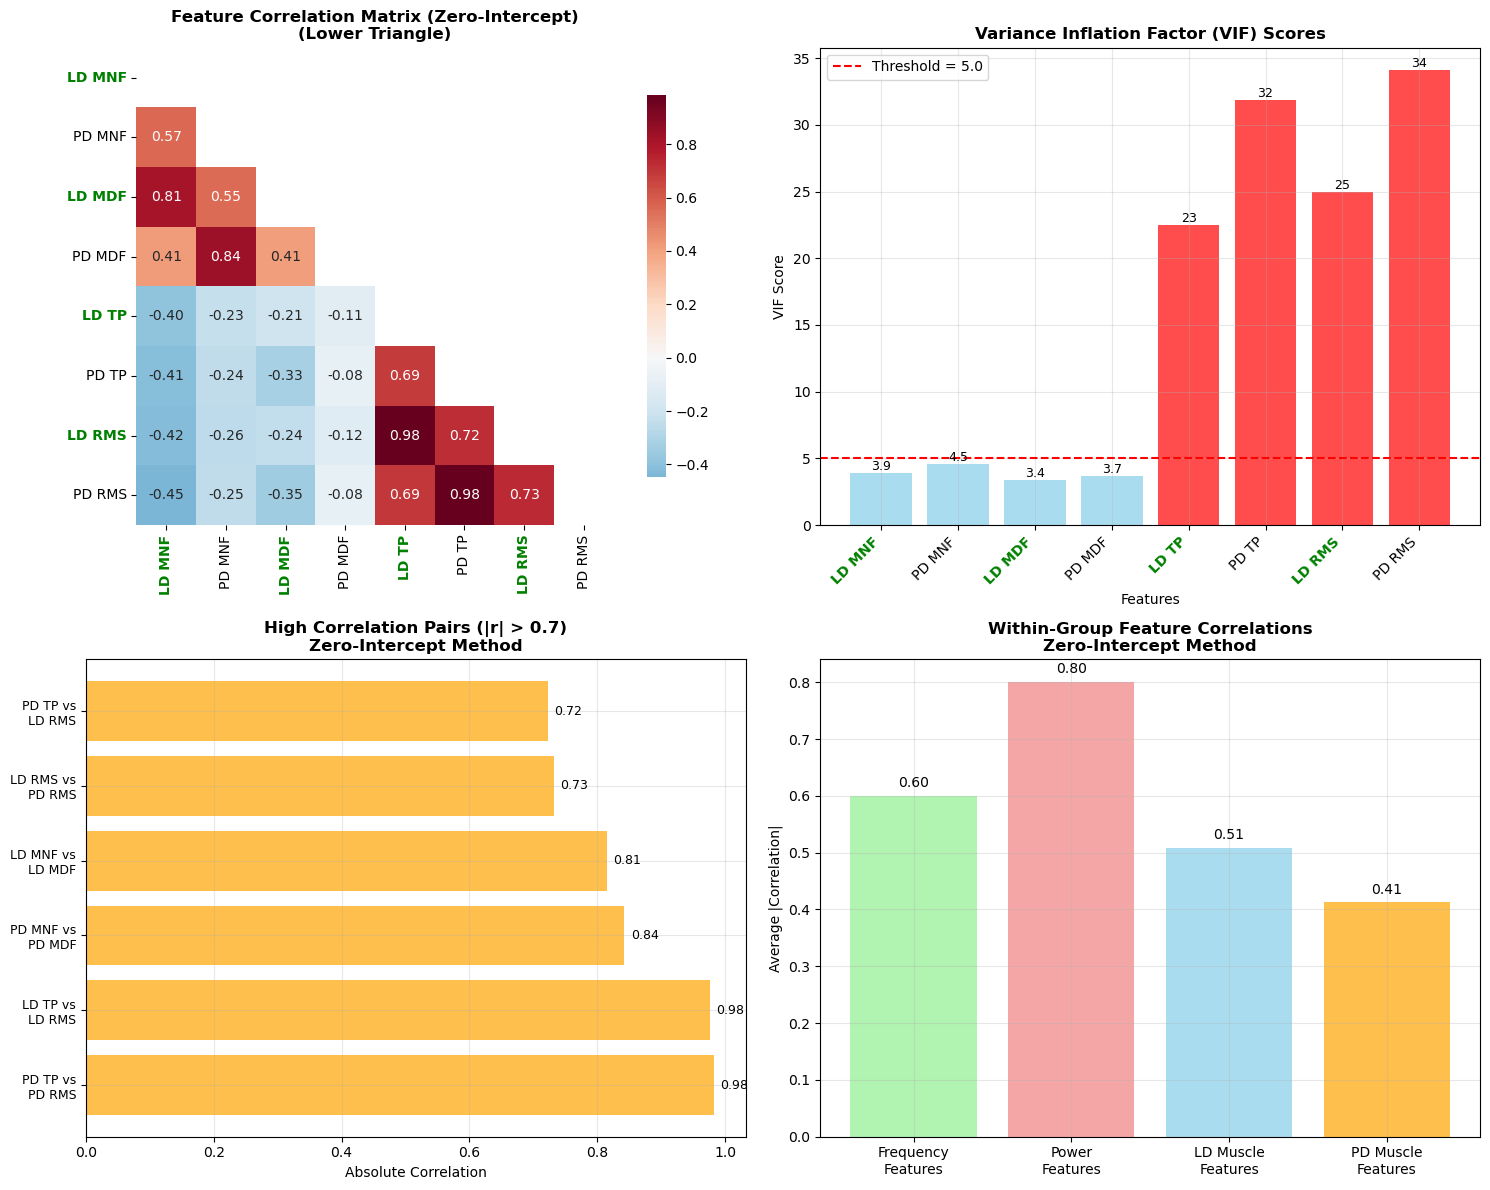

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

def calculate_zero_intercept_correlation_matrix(data, method='zero_intercept'):
    """
    Calculate correlation matrix using zero-intercept or standard Pearson correlation.
    Uses the existing calculate_zero_intercept_correlation function.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Feature data
    method : str
        'zero_intercept' for zero-intercept correlation (recommended for EMG % change features)
        'pearson' for standard Pearson correlation
    
    Returns:
    --------
    pd.DataFrame
        Correlation matrix
    """
    features = data.columns
    n_features = len(features)
    corr_matrix = np.zeros((n_features, n_features))
    
    for i, feat1 in enumerate(features):
        for j, feat2 in enumerate(features):
            if i == j:
                corr_matrix[i, j] = 1.0
            else:
                x_vals = data[feat1].values
                y_vals = data[feat2].values
                
                # Remove NaN values
                mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
                x_clean, y_clean = x_vals[mask], y_vals[mask]
                
                if len(x_clean) < 3:
                    corr_matrix[i, j] = np.nan
                    continue
                
                if method == 'zero_intercept':
                    # Use the existing function from your correlation analysis
                    corr, _, _, _ = calculate_zero_intercept_correlation(x_clean, y_clean)
                else:  # standard pearson
                    corr, _ = stats.pearsonr(x_clean, y_clean)
                
                corr_matrix[i, j] = corr
    
    return pd.DataFrame(corr_matrix, index=features, columns=features)

def analyze_feature_collinearity(data_manager, features, subjects=None, 
                                normalization='standard', vif_threshold=5.0,
                                correlation_method='zero_intercept',
                                figsize=(12, 10)):
    """
    Comprehensive feature collinearity analysis for EMG fatigue features.
    Updated to support zero-intercept correlation method.
    
    Parameters:
    -----------
    data_manager : DataManager object
        The data manager containing the dataset
    features : List[str]
        List of feature names to analyze
    subjects : list, optional
        List of subjects to include. If None, uses all subjects
    normalization : str
        Type of normalization: 'standard', 'minmax', 'robust', or None
    vif_threshold : float
        VIF threshold for identifying problematic collinearity (default: 5.0)
    correlation_method : str
        'zero_intercept' for zero-intercept correlation (recommended for EMG % features)
        'pearson' for standard Pearson correlation
    figsize : tuple
        Figure size for plots
        
    Returns:
    --------
    dict: Dictionary containing correlation matrix, VIF scores, and recommendations
    """
    
    # Get data
    data = data_manager.get_data_for_subjects(subjects)
    if data.empty:
        print("No data found for specified subjects")
        return {}
    
    # Filter valid features
    available_features = data_manager.available_features
    valid_features = [f for f in features if f in available_features]
    invalid_features = [f for f in features if f not in available_features]
    
    if invalid_features:
        print(f"Invalid features (skipped): {invalid_features}")
    
    if len(valid_features) < 2:
        print("Need at least 2 valid features for collinearity analysis")
        return {}
    
    # Extract feature data
    feature_data = data[valid_features].copy()
    
    # Remove rows with any NaN values
    feature_data = feature_data.dropna()
    
    if feature_data.empty:
        print("No complete data rows found")
        return {}
    
    print(f"Using {correlation_method} correlation method for collinearity analysis")
    print(f"Analyzing {len(feature_data)} samples across {len(valid_features)} features")
    
    # Apply normalization if requested (note: may affect zero-intercept interpretation)
    if normalization:
        if correlation_method == 'zero_intercept':
            print(f"⚠️ Warning: Using normalization with zero-intercept correlation")
            print("   This may not be optimal for EMG percentage change features")
        
        if normalization == 'standard':
            scaler = StandardScaler()
        elif normalization == 'minmax':
            scaler = MinMaxScaler()
        elif normalization == 'robust':
            scaler = RobustScaler()
        
        feature_data_scaled = pd.DataFrame(
            scaler.fit_transform(feature_data),
            columns=feature_data.columns,
            index=feature_data.index
        )
    else:
        feature_data_scaled = feature_data
    
    # Calculate correlation matrix using specified method
    if correlation_method == 'zero_intercept':
        corr_matrix = calculate_zero_intercept_correlation_matrix(feature_data_scaled, 'zero_intercept')
    else:
        corr_matrix = feature_data_scaled.corr()  # Standard Pearson
    
    # Calculate VIF scores (always uses standard method for VIF)
    vif_scores = calculate_vif_scores(feature_data_scaled)
    
    # Create visualizations
    fig = create_collinearity_plots(corr_matrix, vif_scores, vif_threshold, 
                                  correlation_method, figsize)
    
    # Generate recommendations
    recommendations = generate_collinearity_recommendations(
        corr_matrix, vif_scores, vif_threshold, correlation_method
    )
    
    # Print summary
    print_collinearity_summary(corr_matrix, vif_scores, vif_threshold, correlation_method)
    
    results = {
        'correlation_matrix': corr_matrix,
        'vif_scores': vif_scores,
        'recommendations': recommendations,
        'figure': fig,
        'n_samples': len(feature_data_scaled),
        'correlation_method': correlation_method
    }
    
    return results

def calculate_vif_scores(feature_data):
    """Calculate Variance Inflation Factor for each feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = feature_data.columns
    
    vif_scores = []
    for i in range(feature_data.shape[1]):
        try:
            vif = variance_inflation_factor(feature_data.values, i)
            vif_scores.append(vif)
        except:
            vif_scores.append(np.inf)
    
    vif_data["VIF"] = vif_scores
    return vif_data.set_index("Feature")

def create_collinearity_plots(corr_matrix, vif_scores, vif_threshold, 
                            correlation_method, figsize):
    """Create comprehensive collinearity visualization plots."""
    
    # Create feature labels for better display
    feature_labels = {}
    for feature in corr_matrix.columns:
        if 'ch2' in feature and 'mean_power_freq' in feature:
            feature_labels[feature] = 'LD MNF'
        elif 'ch1' in feature and 'mean_power_freq' in feature:
            feature_labels[feature] = 'PD MNF'
        elif 'ch2' in feature and 'median_power_freq' in feature:
            feature_labels[feature] = 'LD MDF'
        elif 'ch1' in feature and 'median_power_freq' in feature:
            feature_labels[feature] = 'PD MDF'
        elif 'ch2' in feature and 'total_power' in feature:
            feature_labels[feature] = 'LD TP'
        elif 'ch1' in feature and 'total_power' in feature:
            feature_labels[feature] = 'PD TP'
        elif 'ch2' in feature and 'rms' in feature:
            feature_labels[feature] = 'LD RMS'
        elif 'ch1' in feature and 'rms' in feature:
            feature_labels[feature] = 'PD RMS'
        else:
            feature_labels[feature] = feature
    
    # Apply labels to matrices
    display_corr = corr_matrix.copy()
    display_corr.index = [feature_labels.get(idx, idx) for idx in display_corr.index]
    display_corr.columns = [feature_labels.get(col, col) for col in display_corr.columns]
    
    display_vif = vif_scores.copy()
    display_vif.index = [feature_labels.get(idx, idx) for idx in display_vif.index]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    # Method-specific title
    method_name = "Zero-Intercept" if correlation_method == 'zero_intercept' else "Pearson"
    
    # 1. Correlation Heatmap
    mask = np.triu(np.ones_like(display_corr, dtype=bool))  # Mask upper triangle
    sns.heatmap(display_corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=ax1)
    ax1.set_title(f'Feature Correlation Matrix ({method_name})\n(Lower Triangle)', 
                  fontweight='bold')
    
    # Color LD features
    for label in ax1.get_yticklabels():
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    for label in ax1.get_xticklabels():
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    # 2. VIF Scores Bar Plot
    colors = ['red' if vif >= vif_threshold else 'skyblue' for vif in display_vif['VIF']]
    bars = ax2.bar(range(len(display_vif)), display_vif['VIF'], color=colors, alpha=0.7)
    ax2.axhline(y=vif_threshold, color='red', linestyle='--', 
                label=f'Threshold = {vif_threshold}')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('VIF Score')
    ax2.set_title('Variance Inflation Factor (VIF) Scores', fontweight='bold')
    ax2.set_xticks(range(len(display_vif)))
    ax2.set_xticklabels(display_vif.index, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, vif in zip(bars, display_vif['VIF']):
        height = bar.get_height()
        if height > 20:  # Cap very high values for display
            text = f'{height:.0f}'
        else:
            text = f'{height:.1f}'
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                text, ha='center', va='bottom', fontsize=9)
    
    # Color x-axis labels for LD features
    for label in ax2.get_xticklabels():
        if 'LD' in label.get_text():
            label.set_color('green')
            label.set_weight('bold')
    
    # 3. High Correlation Pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > 0.7:  # Threshold for high correlation
                pair_name = f"{display_corr.index[i]} vs\n{display_corr.columns[j]}"
                high_corr_pairs.append((pair_name, corr_val))
    
    if high_corr_pairs:
        high_corr_pairs.sort(key=lambda x: x[1], reverse=True)
        pairs, correlations = zip(*high_corr_pairs[:10])  # Top 10
        
        bars3 = ax3.barh(range(len(pairs)), correlations, color='orange', alpha=0.7)
        ax3.set_yticks(range(len(pairs)))
        ax3.set_yticklabels(pairs, fontsize=9)
        ax3.set_xlabel('Absolute Correlation')
        ax3.set_title(f'High Correlation Pairs (|r| > 0.7)\n{method_name} Method', 
                      fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, corr in zip(bars3, correlations):
            width = bar.get_width()
            ax3.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                    f'{corr:.2f}', ha='left', va='center', fontsize=9)
    else:
        ax3.text(0.5, 0.5, 'No high correlations\n(|r| > 0.7) found', 
                transform=ax3.transAxes, ha='center', va='center', fontsize=12)
        ax3.set_title(f'High Correlation Pairs (|r| > 0.7)\n{method_name} Method', 
                      fontweight='bold')
    
    # 4. Feature Type Correlation Analysis
    # Group features by type and muscle
    freq_features = [f for f in display_corr.columns if 'MNF' in f or 'MDF' in f]
    power_features = [f for f in display_corr.columns if 'TP' in f or 'RMS' in f]
    ld_features = [f for f in display_corr.columns if 'LD' in f]
    pd_features = [f for f in display_corr.columns if 'PD' in f]
    
    # Calculate average within-group correlations
    group_stats = []
    if len(freq_features) > 1:
        freq_corr = display_corr.loc[freq_features, freq_features]
        avg_freq_corr = abs(freq_corr.values[np.triu_indices_from(freq_corr.values, k=1)]).mean()
        group_stats.append(('Frequency\nFeatures', avg_freq_corr))
    
    if len(power_features) > 1:
        power_corr = display_corr.loc[power_features, power_features]
        avg_power_corr = abs(power_corr.values[np.triu_indices_from(power_corr.values, k=1)]).mean()
        group_stats.append(('Power\nFeatures', avg_power_corr))
    
    if len(ld_features) > 1:
        ld_corr = display_corr.loc[ld_features, ld_features]
        avg_ld_corr = abs(ld_corr.values[np.triu_indices_from(ld_corr.values, k=1)]).mean()
        group_stats.append(('LD Muscle\nFeatures', avg_ld_corr))
    
    if len(pd_features) > 1:
        pd_corr = display_corr.loc[pd_features, pd_features]
        avg_pd_corr = abs(pd_corr.values[np.triu_indices_from(pd_corr.values, k=1)]).mean()
        group_stats.append(('PD Muscle\nFeatures', avg_pd_corr))
    
    if group_stats:
        groups, avg_corrs = zip(*group_stats)
        colors4 = ['lightgreen', 'lightcoral', 'skyblue', 'orange'][:len(groups)]
        bars4 = ax4.bar(range(len(groups)), avg_corrs, color=colors4, alpha=0.7)
        ax4.set_xticks(range(len(groups)))
        ax4.set_xticklabels(groups, rotation=0, ha='center')
        ax4.set_ylabel('Average |Correlation|')
        ax4.set_title(f'Within-Group Feature Correlations\n{method_name} Method', 
                      fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, corr in zip(bars4, avg_corrs):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{corr:.2f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    return fig

def generate_collinearity_recommendations(corr_matrix, vif_scores, vif_threshold, 
                                        correlation_method):
    """Generate recommendations for handling collinearity."""
    recommendations = []
    
    method_name = "Zero-Intercept" if correlation_method == 'zero_intercept' else "Pearson"
    recommendations.append(f"📊 ANALYSIS METHOD: {method_name} Correlation")
    
    if correlation_method == 'zero_intercept':
        recommendations.append("   • Recommended for EMG percentage change features")
        recommendations.append("   • Forced through origin correlation")
    else:
        recommendations.append("   • Standard linear correlation analysis")
    
    # Check for high VIF scores
    high_vif = vif_scores[vif_scores['VIF'] >= vif_threshold]
    if not high_vif.empty:
        recommendations.append(f"\n⚠️ HIGH VIF DETECTED: {len(high_vif)} features have VIF ≥ {vif_threshold}")
        for feature, vif in high_vif.iterrows():
            recommendations.append(f"   • {feature}: VIF = {vif['VIF']:.1f}")
    
    # Check for high correlations (adjust threshold based on method)
    high_corr_threshold = 0.8 if correlation_method == 'zero_intercept' else 0.8
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > high_corr_threshold:
                high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_val))
    
    if high_corr_pairs:
        recommendations.append(f"\n⚠️ HIGH CORRELATIONS: {len(high_corr_pairs)} pairs with |r| > {high_corr_threshold}")
        for feat1, feat2, corr in high_corr_pairs:
            recommendations.append(f"   • {feat1} ↔ {feat2}: r = {corr:.3f}")
    
    # Method-specific recommendations
    if correlation_method == 'zero_intercept':
        recommendations.append(f"\n🔬 ZERO-INTERCEPT SPECIFIC NOTES:")
        recommendations.append("   • Correlations forced through origin")
        recommendations.append("   • More appropriate for EMG fatigue % change features")
        recommendations.append("   • May show different patterns than standard Pearson")
    
    # Provide general recommendations
    if high_vif.empty and not high_corr_pairs:
        recommendations.append(f"\n✅ NO SEVERE COLLINEARITY detected")
        recommendations.append("   • All VIF scores below threshold")
        recommendations.append(f"   • No extremely high correlations (>{high_corr_threshold})")
    else:
        recommendations.append(f"\n📋 RECOMMENDATIONS:")
        recommendations.append("   • Consider removing redundant features")
        recommendations.append("   • Use PCA or feature selection techniques")
        recommendations.append("   • Apply regularization (Ridge/Lasso) in ML models")
        recommendations.append("   • Consider domain knowledge for feature selection")
        
        if correlation_method == 'zero_intercept':
            recommendations.append("   • Zero-intercept method may reveal different collinearity patterns")
            recommendations.append("   • Consider both methods for comprehensive analysis")
    
    return recommendations

def print_collinearity_summary(corr_matrix, vif_scores, vif_threshold, correlation_method):
    """Print a comprehensive summary of collinearity analysis."""
    method_name = "Zero-Intercept" if correlation_method == 'zero_intercept' else "Pearson"
    
    print("="*70)
    print(f"FEATURE COLLINEARITY ANALYSIS SUMMARY - {method_name}")
    print("="*70)
    
    print(f"\n📊 DATASET INFO:")
    print(f"   • Number of features analyzed: {len(corr_matrix.columns)}")
    print(f"   • VIF threshold: {vif_threshold}")
    print(f"   • Correlation method: {method_name}")
    
    print(f"\n📈 VIF SCORES:")
    for feature, vif in vif_scores.iterrows():
        status = "⚠️ HIGH" if vif['VIF'] >= vif_threshold else "✅ OK"
        print(f"   • {feature:30s}: {vif['VIF']:6.2f} {status}")
    
    print(f"\n🔗 CORRELATION SUMMARY ({method_name}):")
    # Find highest correlations
    corr_vals = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_vals.append(abs(corr_matrix.iloc[i, j]))
    
    if corr_vals:
        print(f"   • Maximum |correlation|: {max(corr_vals):.3f}")
        print(f"   • Average |correlation|: {np.mean(corr_vals):.3f}")
        print(f"   • Pairs with |r| > 0.7: {sum(1 for r in corr_vals if r > 0.7)}")
        print(f"   • Pairs with |r| > 0.8: {sum(1 for r in corr_vals if r > 0.8)}")

def run_collinearity_analysis_example(data_manager, correlation_method='zero_intercept'):
    """
    Example of how to run the complete collinearity analysis with method selection.
    
    Parameters:
    -----------
    data_manager : DataManager object
        Your data manager
    correlation_method : str
        'zero_intercept' (recommended for EMG % change features) or 'pearson'
    """
    
    # Define your features
    FEATURES = [
        'ch2_mean_power_freq_max_pct_change',    # LD MNF
        'ch1_mean_power_freq_max_pct_change',    # PD MNF
        'ch2_median_power_freq_max_pct_change',  # LD MDF
        'ch1_median_power_freq_max_pct_change',  # PD MDF
        'ch2_total_power_max_pct_change',        # LD TP
        'ch1_total_power_max_pct_change',        # PD TP
        'ch2_rms_max_pct_change',                # LD RMS
        'ch1_rms_max_pct_change'                 # PD RMS
    ]
    
    # Run analysis with selected method
    results = analyze_feature_collinearity(
        data_manager, 
        FEATURES,
        normalization=None,  # Avoid normalization with zero_intercept for EMG % features
        correlation_method=correlation_method,
        vif_threshold=5.0,
        figsize=(15, 12)
    )
    
    # Print recommendations
    if results and 'recommendations' in results:
        print("\n" + "="*70)
        print("RECOMMENDATIONS")
        print("="*70)
        for rec in results['recommendations']:
            print(rec)
    
    return results

# Comparison function to run both methods
def compare_correlation_methods(data_manager, features=None):
    """
    Compare zero-intercept and Pearson correlation methods side by side.
    
    Parameters:
    -----------
    data_manager : DataManager object
        Your data manager
    features : list, optional
        List of features. If None, uses default EMG features
    
    Returns:
    --------
    dict: Results from both methods
    """
    if features is None:
        features = [
            'ch2_mean_power_freq_max_pct_change',    # LD MNF
            'ch1_mean_power_freq_max_pct_change',    # PD MNF
            'ch2_median_power_freq_max_pct_change',  # LD MDF
            'ch1_median_power_freq_max_pct_change',  # PD MDF
            'ch2_total_power_max_pct_change',        # LD TP
            'ch1_total_power_max_pct_change',        # PD TP
            'ch2_rms_max_pct_change',                # LD RMS
            'ch1_rms_max_pct_change'                 # PD RMS
        ]
    
    print("="*80)
    print("CORRELATION METHOD COMPARISON")
    print("="*80)
    
    # Run zero-intercept analysis
    print(f"\n🔬 RUNNING ZERO-INTERCEPT ANALYSIS...")
    results_zero = run_collinearity_analysis_example(data_manager, 'zero_intercept')
    
    print(f"\n📊 RUNNING STANDARD PEARSON ANALYSIS...")
    results_pearson = run_collinearity_analysis_example(data_manager, 'pearson')
    
    # Compare correlation matrices
    if results_zero and results_pearson:
        print(f"\n🔍 CORRELATION MATRIX COMPARISON:")
        print("-" * 50)
        
        corr_zero = results_zero['correlation_matrix']
        corr_pearson = results_pearson['correlation_matrix']
        
        # Calculate differences
        corr_diff = abs(corr_zero - corr_pearson)
        max_diff = corr_diff.max().max()
        mean_diff = corr_diff.mean().mean()
        
        print(f"Maximum difference in correlations: {max_diff:.3f}")
        print(f"Average difference in correlations: {mean_diff:.3f}")
        
        # Find pairs with largest differences
        large_diff_pairs = []
        for i in range(len(corr_diff.columns)):
            for j in range(i+1, len(corr_diff.columns)):
                diff_val = corr_diff.iloc[i, j]
                if diff_val > 0.1:  # Significant difference threshold
                    large_diff_pairs.append((
                        corr_diff.index[i], 
                        corr_diff.columns[j], 
                        diff_val,
                        corr_zero.iloc[i, j],
                        corr_pearson.iloc[i, j]
                    ))
        
        if large_diff_pairs:
            print(f"\nPairs with large correlation differences (>0.1):")
            for feat1, feat2, diff, r_zero, r_pearson in large_diff_pairs:
                print(f"  {feat1} ↔ {feat2}:")
                print(f"    Zero-intercept: {r_zero:.3f}")
                print(f"    Pearson: {r_pearson:.3f}")
                print(f"    Difference: {diff:.3f}")
    
    return {
        'zero_intercept': results_zero,
        'pearson': results_pearson
    }

# If running as standalone script
if __name__ == "__main__":
    # Assuming you have a data_manager object
    results = run_collinearity_analysis_example(manager)
    pass

In [87]:
s_value= 0.86
s_value**2

0.7395999999999999

In [88]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import re
import warnings
warnings.filterwarnings('ignore')


class SimpleDatasetManager:
    """Simple dataset manager for loading and combining CSV files with optional trial separation"""
    
    def __init__(self, data_directory: str = None):
        self.data_directory = data_directory
        self.data = None
        self.subjects = []
        self.available_features = []
        self.trials_info = {}  # Store trial information when separate_trials=True
        self.separate_trials = False  # Track current mode
        
    def load_all_data(self, pattern: str = "*.csv", target_column: str = 'completion_percentage', 
                      separate_trials: bool = False):
        """
        Load and combine all CSV files from directory
        
        Parameters:
        -----------
        pattern : str
            File pattern to match (default: "*.csv")
        target_column : str
            Required target column name (default: 'completion_percentage')
        separate_trials : bool
            If True, each trial is treated as a separate entity with unique trial_id.
            If False, all trials from the same subject are combined (default: False)
        """
        if not self.data_directory:
            raise ValueError("Data directory not specified")
        
        self.separate_trials = separate_trials
        
        csv_files = glob.glob(str(Path(self.data_directory) / pattern))
        if not csv_files:
            print(f"No files found matching pattern '{pattern}'")
            return
        
        # Group files by subject
        subject_files = {}
        for file_path in csv_files:
            file_name = Path(file_path).stem
            subject_match = re.search(r'S(\d+)', file_name, re.IGNORECASE)
            
            if subject_match:
                subject_num = int(subject_match.group(1))
                if subject_num not in subject_files:
                    subject_files[subject_num] = []
                subject_files[subject_num].append({
                    'path': file_path,
                    'name': file_name,
                    'type': 'HD' if 'HD' in file_name.upper() else 'MD' if 'MD' in file_name.upper() else 'Unknown'
                })
        
        # Load and combine data
        all_dataframes = []
        trial_counter = 1  # Global trial counter for separate_trials mode
        
        for subject_num, files in sorted(subject_files.items()):
            subject_dataframes = []
            
            for file_info in files:
                try:
                    df = pd.read_csv(file_info['path'])
                    
                    # Always set subject_id
                    df['subject_id'] = subject_num
                    
                    # Extract trial information from filename
                    trial_match = re.search(r'Trial_(\d+)', file_info['name'], re.IGNORECASE)
                    if trial_match:
                        original_trial = int(trial_match.group(1))
                        file_type = file_info['type']
                        
                        # Create unique trial indices (legacy system)
                        if file_type == 'MD':
                            unique_trial_index = original_trial + 100
                        else:
                            unique_trial_index = original_trial
                        
                        df['trial_index'] = unique_trial_index
                        df['original_trial_number'] = original_trial
                        
                        if separate_trials:
                            # Create globally unique trial_id for separate trials mode
                            trial_id = f"S{subject_num:02d}_{file_type}_T{original_trial:02d}"
                            df['trial_id'] = trial_id
                            df['trial_id_numeric'] = trial_counter
                            
                            # Store trial information
                            self.trials_info[trial_id] = {
                                'subject_id': subject_num,
                                'original_trial': original_trial,
                                'file_type': file_type,
                                'trial_id_numeric': trial_counter,
                                'source_file': file_info['name']
                            }
                            trial_counter += 1
                        else:
                            # In combined mode, trial_id is just the subject_id
                            df['trial_id'] = f"S{subject_num:02d}_combined"
                            df['trial_id_numeric'] = subject_num
                    
                    df['file_type'] = file_info['type']
                    df['source_file'] = file_info['name']
                    subject_dataframes.append(df)
                    
                except Exception as e:
                    print(f"Failed to load {file_info['name']}: {e}")
            
            if subject_dataframes:
                if separate_trials:
                    # Keep each trial separate
                    all_dataframes.extend(subject_dataframes)
                else:
                    # Combine all trials for this subject
                    subject_combined = pd.concat(subject_dataframes, ignore_index=True)
                    all_dataframes.append(subject_combined)
        
        if not all_dataframes:
            print("No data loaded successfully")
            return
        
        self.data = pd.concat(all_dataframes, ignore_index=True)
        
        # Check required columns
        required_cols = ['subject_id', 'trial_index', 'cycle_index']
        missing_cols = [col for col in required_cols if col not in self.data.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return
        
        if target_column not in self.data.columns:
            print(f"Target column '{target_column}' not found")
            return
        
        self._update_metadata()
        print(f"Data loaded in {'separate trials' if separate_trials else 'combined trials'} mode")
        
    def _update_metadata(self):
        """Update metadata about the dataset"""
        if self.data is None:
            return
        
        self.subjects = sorted(self.data['subject_id'].unique())
        
        metadata_cols = ['subject_id', 'trial_index', 'cycle_index', 'completion_percentage', 
                        'subjective_fatigue', 'motion_type', 'damping_level', 'dataset_source',
                        'file_type', 'source_file', 'trial_id', 'trial_id_numeric', 'original_trial_number']
        self.available_features = [col for col in self.data.columns if col not in metadata_cols]
    
    def get_data_for_subjects(self, subjects=None):
        """Get data for specific subjects"""
        if self.data is None:
            print("No data loaded")
            return pd.DataFrame()
        
        if subjects is None:
            return self.data.copy()
        
        if not isinstance(subjects, list):
            subjects = [subjects]
        
        return self.data[self.data['subject_id'].isin(subjects)]
    
    def get_data_for_trials(self, trial_ids=None):
        """
        Get data for specific trials (only works in separate_trials mode)
        
        Parameters:
        -----------
        trial_ids : list or str or None
            Trial IDs to filter by. Can be:
            - List of trial_id strings (e.g., ['S01_HD_T01', 'S01_MD_T01'])
            - Single trial_id string
            - List of numeric trial IDs
            - None (returns all data)
        """
        if self.data is None:
            print("No data loaded")
            return pd.DataFrame()
        
        if not self.separate_trials:
            print("get_data_for_trials() only works when separate_trials=True")
            return self.get_data_for_subjects()
        
        if trial_ids is None:
            return self.data.copy()
        
        if not isinstance(trial_ids, list):
            trial_ids = [trial_ids]
        
        # Handle both string and numeric trial IDs
        if all(isinstance(tid, str) for tid in trial_ids):
            return self.data[self.data['trial_id'].isin(trial_ids)]
        elif all(isinstance(tid, (int, np.integer)) for tid in trial_ids):
            return self.data[self.data['trial_id_numeric'].isin(trial_ids)]
        else:
            print("Mixed trial ID types not supported. Use either all strings or all numeric IDs.")
            return pd.DataFrame()
    
    def get_unique_trials(self):
        """Get list of unique trials (useful in separate_trials mode)"""
        if self.data is None:
            return []
        
        if self.separate_trials:
            return sorted(self.data['trial_id'].unique())
        else:
            return [f"S{s:02d}_combined" for s in self.subjects]
    
    def get_trials_by_subject(self, subject_id):
        """Get all trials for a specific subject"""
        if self.data is None or not self.separate_trials:
            return []
        
        subject_data = self.data[self.data['subject_id'] == subject_id]
        return sorted(subject_data['trial_id'].unique())
    
    def get_trials_by_type(self, file_type='HD'):
        """Get all trials of a specific type (HD/MD)"""
        if self.data is None or not self.separate_trials:
            return []
        
        type_data = self.data[self.data['file_type'] == file_type]
        return sorted(type_data['trial_id'].unique())
    
    def get_feature_names(self, feature_type='all'):
        """Get list of available feature names"""
        if not self.available_features:
            return []
        
        features = self.available_features.copy()
        
        if feature_type == 'all':
            return features
        elif feature_type == 'original':
            return [f for f in features if not f.endswith('_pct_change')]
        elif feature_type == 'pct_change':
            return [f for f in features if f.endswith('_pct_change')]
        elif feature_type == 'rms':
            return [f for f in features if 'rms' in f.lower()]
        elif feature_type == 'channel':
            return [f for f in features if f.startswith('ch')]
        else:
            return features
    
    def summary(self):
        """Print basic dataset summary"""
        if self.data is None:
            print("No data loaded")
            return
        
        print(f"Dataset shape: {self.data.shape}")
        print(f"Mode: {'Separate trials' if self.separate_trials else 'Combined trials'}")
        print(f"Subjects: {self.subjects}")
        
        if self.separate_trials:
            unique_trials = self.get_unique_trials()
            print(f"Total unique trials: {len(unique_trials)}")
            
            # Show trials per subject
            for subject in self.subjects:
                subject_trials = self.get_trials_by_subject(subject)
                print(f"  Subject {subject}: {len(subject_trials)} trials")
            
            # Show trials by type
            hd_trials = self.get_trials_by_type('HD')
            md_trials = self.get_trials_by_type('MD')
            print(f"HD trials: {len(hd_trials)}, MD trials: {len(md_trials)}")
        else:
            print(f"Trials per subject: Combined")
        
        print(f"Available features: {len(self.available_features)}")
        
        if 'completion_percentage' in self.data.columns:
            completion_range = (self.data['completion_percentage'].min(), 
                              self.data['completion_percentage'].max())
            print(f"Completion percentage range: {completion_range[0]:.1f}% - {completion_range[1]:.1f}%")
    
    def get_trial_info(self, trial_id=None):
        """Get detailed information about trials"""
        if not self.separate_trials:
            print("Trial info only available in separate_trials mode")
            return None
        
        if trial_id is None:
            return self.trials_info.copy()
        else:
            return self.trials_info.get(trial_id, None)


# Example usage
if __name__ == "__main__":
    # Example 1: Load data with combined trials (original behavior)
    print("=== Combined Trials Mode ===")
    manager_combined = SimpleDatasetManager(r"C:\Users\ezior\Downloads\EMG_ML_Features")
    manager_combined.load_all_data("*.csv", separate_trials=False)
    manager_combined.summary()
    
    print("\n" + "="*50 + "\n")
    
    # Example 2: Load data with separate trials
    print("=== Separate Trials Mode ===")
    manager_separate = SimpleDatasetManager(r"C:\Users\ezior\Downloads\EMG_ML_Features")
    manager_separate.load_all_data("*.csv", separate_trials=True)
    manager_separate.summary()
    
    # Show unique trials
    print(f"\nUnique trials: {manager_separate.get_unique_trials()}")
    
    # Get data for specific trials
    if manager_separate.separate_trials:
        first_few_trials = manager_separate.get_unique_trials()[:3]
        trial_data = manager_separate.get_data_for_trials(first_few_trials)
        print(f"Data shape for first 3 trials: {trial_data.shape}")

=== Combined Trials Mode ===
Data loaded in combined trials mode
Dataset shape: (1168, 44)
Mode: Combined trials
Subjects: [1, 2, 3, 4, 5, 6, 7, 8]
Trials per subject: Combined
Available features: 33
Completion percentage range: 0.0% - 100.0%


=== Separate Trials Mode ===
Data loaded in separate trials mode
Dataset shape: (1168, 44)
Mode: Separate trials
Subjects: [1, 2, 3, 4, 5, 6, 7, 8]
Total unique trials: 46
  Subject 1: 6 trials
  Subject 2: 6 trials
  Subject 3: 6 trials
  Subject 4: 5 trials
  Subject 5: 5 trials
  Subject 6: 6 trials
  Subject 7: 6 trials
  Subject 8: 6 trials
HD trials: 24, MD trials: 22
Available features: 33
Completion percentage range: 0.0% - 100.0%

Unique trials: ['S01_HD_T01', 'S01_HD_T02', 'S01_HD_T03', 'S01_MD_T01', 'S01_MD_T02', 'S01_MD_T03', 'S02_HD_T01', 'S02_HD_T02', 'S02_HD_T03', 'S02_MD_T01', 'S02_MD_T02', 'S02_MD_T03', 'S03_HD_T01', 'S03_HD_T02', 'S03_HD_T03', 'S03_MD_T01', 'S03_MD_T02', 'S03_MD_T03', 'S04_HD_T01', 'S04_HD_T02', 'S04_HD_T03', '

Plotting mode: single_subject
Selected subjects: [2]
Coloring by trial using column: trial_id


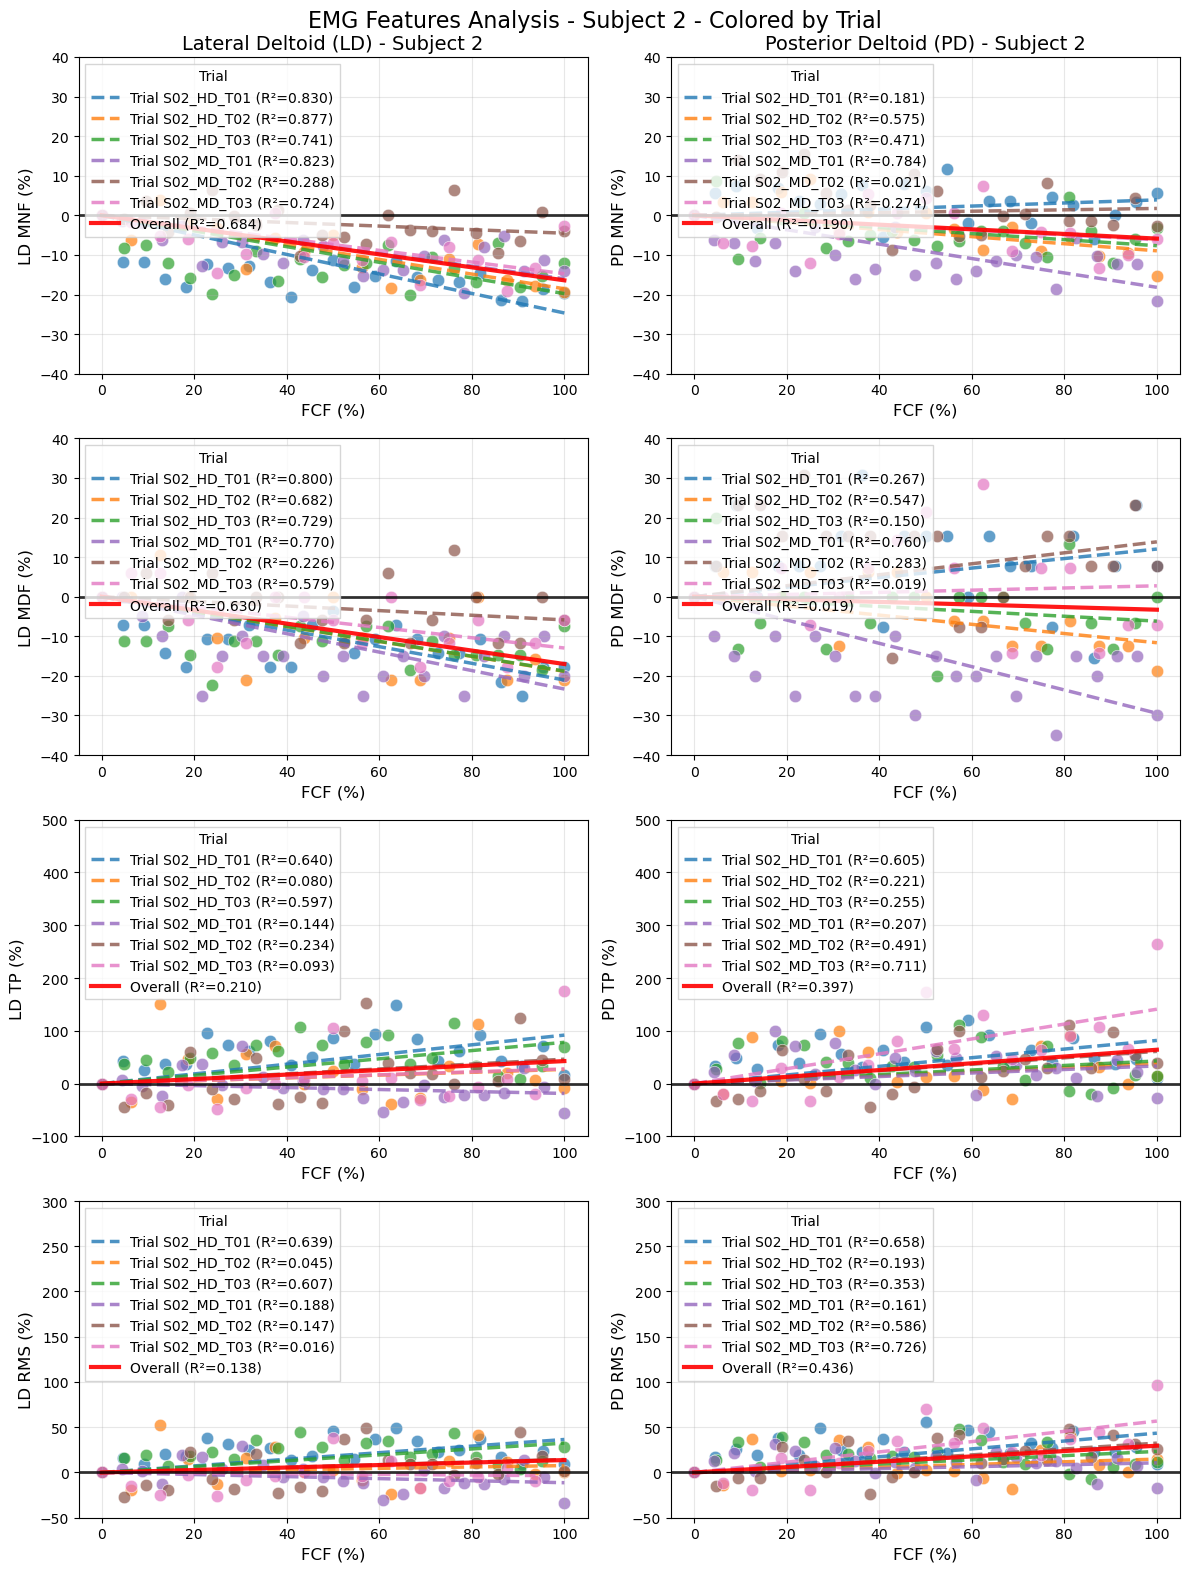

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from typing import List, Dict, Tuple, Union

def plot_features_grid(data_manager, plot_configs: List[Dict], 
                      subjects: Union[None, int, List[int]] = None,
                      plot_mode: str = 'all_subjects',  # 'all_subjects', 'single_subject', 'selected_subjects'
                      x_axis: str = 'completion_percentage',
                      xlabel: str = 'FCF (%)',
                      figsize: Tuple[int, int] = (16, 20),
                      n_rows: int = 4, n_cols: int = 2,
                      save_path: str = None,
                      show_plot: bool = True,
                      suptitle: str = None,
                      show_individual_trends: bool = True,
                      show_overall_trend: bool = True,
                      normalize: bool = False,
                      normalization_scope: str = 'per_feature',  # 'per_feature', 'per_subject', 'global'
                      normalize_features: List[int] = None,  # List of 0s and 1s for each subplot
                      mnf_range: Tuple[float, float] = (-100, 0),  # Custom range for MNF normalization
                      mdf_range: Tuple[float, float] = (-100, 0),  # Custom range for MDF normalization
                      color_by_trial: bool = False,  # Color points by trial instead of subject
                      trial_column: str = 'trial_id'):  # Column name containing trial information
    """
    Enhanced grid plot of EMG features with custom normalization and trial coloring options.
    
    Parameters:
    -----------
    plot_mode : str
        - 'all_subjects': Plot all available subjects (default)
        - 'single_subject': Plot only one subject (requires subjects parameter)
        - 'selected_subjects': Plot specific subjects (requires subjects parameter)
    
    subjects : Union[None, int, List[int]]
        - None: Use all subjects (when plot_mode='all_subjects')
        - int: Single subject ID (when plot_mode='single_subject')
        - List[int]: List of subject IDs (when plot_mode='selected_subjects')
    
    show_individual_trends : bool
        Whether to show individual subject trend lines (dashed lines)
    
    show_overall_trend : bool
        Whether to show overall trend line (solid red line)
        
    normalize : bool
        Whether to apply normalization to the y-values (default: False)
        
    normalization_scope : str
        Scope of normalization when normalize=True:
        - 'per_feature': Normalize each feature across all selected subjects (default)
        - 'per_subject': Normalize each subject's data independently
        
    normalize_features : List[int]
        List of 0s and 1s indicating which features to normalize (length should match plot_configs)
        0 = no normalization, 1 = normalize. If None, uses normalize parameter for all features.
        
    mnf_range : Tuple[float, float]
        Custom normalization range for MNF features (min, max). Default: (-100, 0)
        
    mdf_range : Tuple[float, float]
        Custom normalization range for MDF features (min, max). Default: (-100, 0)
        
    color_by_trial : bool
        If True, color points by trial instead of subject. Requires trial_column in data.
        
    trial_column : str
        Column name containing trial information (default: 'trial_id')
    """
    
    # Get data and validate subjects
    all_data = data_manager.get_data_for_subjects()
    if all_data.empty:
        print("No data found")
        return
    
    available_subjects = sorted(all_data['subject_id'].unique())
    
    # Handle subject selection based on plot_mode
    if plot_mode == 'all_subjects':
        selected_subjects = available_subjects
        if subjects is not None:
            print(f"Note: subjects parameter ignored in 'all_subjects' mode")
    elif plot_mode == 'single_subject':
        if subjects is None:
            print("Error: subjects parameter required for 'single_subject' mode")
            return
        if isinstance(subjects, list):
            subjects = subjects[0]  # Take first subject if list provided
            print(f"Note: Using first subject ({subjects}) from provided list")
        if subjects not in available_subjects:
            print(f"Error: Subject {subjects} not found. Available: {available_subjects}")
            return
        selected_subjects = [subjects]
    elif plot_mode == 'selected_subjects':
        if subjects is None:
            print("Error: subjects parameter required for 'selected_subjects' mode")
            return
        if not isinstance(subjects, list):
            subjects = [subjects]
        invalid_subjects = [s for s in subjects if s not in available_subjects]
        if invalid_subjects:
            print(f"Warning: Invalid subjects {invalid_subjects}. Available: {available_subjects}")
        selected_subjects = [s for s in subjects if s in available_subjects]
        if not selected_subjects:
            print("Error: No valid subjects selected")
            return
    else:
        print(f"Error: Invalid plot_mode '{plot_mode}'. Use 'all_subjects', 'single_subject', or 'selected_subjects'")
        return
    
    # Filter data for selected subjects
    data = all_data[all_data['subject_id'].isin(selected_subjects)]
    
    # Validate trial column if color_by_trial is enabled
    if color_by_trial and trial_column not in data.columns:
        print(f"Warning: Trial column '{trial_column}' not found in data. Falling back to subject coloring.")
        color_by_trial = False
    
    print(f"Plotting mode: {plot_mode}")
    print(f"Selected subjects: {selected_subjects}")
    if normalize or (normalize_features and any(normalize_features)):
        print(f"Normalization scope: {normalization_scope}")
        print(f"MNF range: {mnf_range}, MDF range: {mdf_range}")
    if color_by_trial:
        print(f"Coloring by trial using column: {trial_column}")
    
    # Setup colors
    if color_by_trial:
        unique_trials = sorted(data[trial_column].unique())
        color_dict = _create_color_dict_no_red(unique_trials, 'tab10')
        color_key = trial_column
    else:
        color_dict = _create_color_dict_no_red(selected_subjects, 'tab10')
        color_key = 'subject_id'
    
    # Handle normalize_features parameter
    if normalize_features is None:
        normalize_features = [1 if normalize else 0] * len(plot_configs)
    elif len(normalize_features) != len(plot_configs):
        print(f"Warning: normalize_features length ({len(normalize_features)}) doesn't match plot_configs length ({len(plot_configs)})")
        # Pad or truncate to match
        if len(normalize_features) < len(plot_configs):
            normalize_features.extend([0] * (len(plot_configs) - len(normalize_features)))
        else:
            normalize_features = normalize_features[:len(plot_configs)]
    
    # Default styles
    zero_line_style = {'color': 'black', 'linewidth': 2, 'linestyle': '-', 'alpha': 0.8}
    fit_line_style = {'color': 'red', 'linewidth': 3, 'linestyle': '-', 'alpha': 0.9}
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    for i, config in enumerate(plot_configs[:len(axes)]):
        if 'feature' not in config:
            continue
            
        feature = config['feature']
        ax = axes[i]
        should_normalize = bool(normalize_features[i]) if i < len(normalize_features) else False
        
        # Check feature availability
        available_features = data_manager.available_features + ['completion_percentage', 'cycle_index']
        if feature not in available_features:
            print(f"Invalid feature '{feature}' for subplot {i+1}")
            ax.text(0.5, 0.5, f"Invalid feature:\n{feature}", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f"Subplot {i+1}: ERROR")
            continue
        
        all_x_clean, all_y_clean = [], []
        group_data_dict = {}
        
        # Determine grouping (by subject or by trial)
        if color_by_trial:
            unique_groups = sorted(data[trial_column].unique())
            group_column = trial_column
        else:
            unique_groups = selected_subjects
            group_column = 'subject_id'
        
        # First pass: collect all data for normalization
        for group in unique_groups:
            if color_by_trial:
                group_data = data[data[trial_column] == group].sort_values(x_axis)
            else:
                group_data = data[data['subject_id'] == group].sort_values(x_axis)
                
            x_vals = group_data[x_axis].values
            y_vals = group_data[feature].values
            
            # Remove NaN
            mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
            x_vals, y_vals = x_vals[mask], y_vals[mask]
            
            if len(x_vals) == 0:
                continue
            
            # Apply outlier rejection if specified in config
            if config.get('outlier_rejection', False) and len(x_vals) > 3:
                x_vals, y_vals, _ = _remove_outliers(x_vals, y_vals, config.get('outlier_z_threshold', 3.0))
                if len(x_vals) == 0:
                    continue
            
            group_data_dict[group] = (x_vals, y_vals)
            all_x_clean.extend(x_vals)
            all_y_clean.extend(y_vals)
        
        # Apply normalization if requested for this feature
        if should_normalize and group_data_dict:
            group_data_dict = _apply_custom_normalization(
                group_data_dict, feature, normalization_scope, mnf_range, mdf_range
            )
            
            # Update all_x_clean and all_y_clean for overall trend calculation
            all_x_clean, all_y_clean = [], []
            for x_vals, y_vals in group_data_dict.values():
                all_x_clean.extend(x_vals)
                all_y_clean.extend(y_vals)
        
        # Second pass: plot the data
        for group in unique_groups:
            if group not in group_data_dict:
                continue
                
            x_vals, y_vals = group_data_dict[group]
            color = color_dict[group]
            
            # Scatter plot - larger points for single subject mode
            point_size = 80 if plot_mode == 'single_subject' else 50
            ax.scatter(x_vals, y_vals, color=color, alpha=0.7, s=point_size, 
                      edgecolors='white', linewidth=0.5)
            
            # Individual trend line (dashed) - force zero intercept
            if show_individual_trends and len(x_vals) > 1:
                slope = np.sum(x_vals * y_vals) / np.sum(x_vals**2)
                y_pred = slope * x_vals
                ss_res = np.sum((y_vals - y_pred)**2)
                ss_tot = np.sum(y_vals**2)
                r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
                
                # Thicker line for single subject mode
                line_width = 2.5 if plot_mode == 'single_subject' else 1.5
                
                # Create label based on coloring mode
                if color_by_trial:
                    label = f'Trial {group} (R²={r2:.3f})'
                else:
                    label = f'Subject {group} (R²={r2:.3f})'
                    
                ax.plot(x_vals, y_pred, color=color, linestyle='--', linewidth=line_width, alpha=0.8,
                       label=label)
        
        # Overall trend line (solid red) - only if more than one group or explicitly requested
        if show_overall_trend and len(all_x_clean) > 1:
            all_x, all_y = np.array(all_x_clean), np.array(all_y_clean)
            slope = np.sum(all_x * all_y) / np.sum(all_x**2)
            x_smooth = np.linspace(all_x.min(), all_x.max(), 100)
            y_smooth = slope * x_smooth
            
            y_pred = slope * all_x
            ss_res = np.sum((all_y - y_pred)**2)
            ss_tot = np.sum(all_y**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            # Only show overall trend if multiple groups or single subject with explicit request
            if len(unique_groups) > 1 or (plot_mode == 'single_subject' and show_overall_trend):
                trend_label = f'Overall (R²={r2:.3f})' if len(unique_groups) > 1 else f'Trend (R²={r2:.3f})'
                ax.plot(x_smooth, y_smooth, color='red', linewidth=3, linestyle='-', alpha=0.9,
                       label=trend_label)
        
        # Zero line (adjust for normalized data)
        show_zero_line = True
        if should_normalize:
            # For MNF/MDF with custom ranges, zero might not be visible
            if 'mnf' in feature.lower() or 'mdf' in feature.lower():
                norm_min, norm_max = (mnf_range if 'mnf' in feature.lower() else mdf_range)
                if norm_min > 0 or norm_max < 0:
                    show_zero_line = False
        
        if show_zero_line:
            ax.axhline(y=0, color=zero_line_style['color'], linewidth=zero_line_style['linewidth'], 
                      linestyle=zero_line_style['linestyle'], alpha=zero_line_style['alpha'])
        
        # Formatting
        ax.set_xlabel(xlabel, fontsize=12)
        
        # Adjust ylabel for normalization
        base_ylabel = config.get('ylabel', feature.replace('_', ' ').title())
        if should_normalize:
            ylabel = f"{base_ylabel} (Normalized)"
        else:
            ylabel = base_ylabel
        ax.set_ylabel(ylabel, fontsize=12)
        
        # Enhanced title for single subject mode
        base_title = config.get('title', feature.replace('_', ' ').title())
        if plot_mode == 'single_subject':
            title = f"{base_title} - Subject {selected_subjects[0]}"
        else:
            title = base_title
        
        # Add normalization info to title if enabled
        if should_normalize:
            title += " (Norm)"
            
        # Title only on first row
        if i < n_cols:
            ax.set_title(title, fontsize=14)
        
        # Apply custom y-axis settings (adjust for normalization)
        if should_normalize:
            # For MNF/MDF features, use the custom range with padding
            if 'mnf' in feature.lower():
                y_range = mnf_range[1] - mnf_range[0]
                padding = y_range * 0.1
                ax.set_ylim(mnf_range[0] - padding, mnf_range[1] + padding)
            elif 'mdf' in feature.lower():
                y_range = mdf_range[1] - mdf_range[0]
                padding = y_range * 0.1
                ax.set_ylim(mdf_range[0] - padding, mdf_range[1] + padding)
            else:
                # For other features, use 0-1 range with padding
                ax.set_ylim(-0.1, 1.1)
        else:
            if 'ylim' in config:
                ax.set_ylim(config['ylim'])
                
        if 'yscale' in config and not should_normalize:  # Don't apply log scale to normalized data
            ax.set_yscale(config['yscale'])
            
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.grid(True, alpha=0.3)
        
        # Adjust legend based on mode and coloring
        legend_fontsize = 10 if plot_mode == 'single_subject' else 8
        legend_title = 'Trial' if color_by_trial else 'Subject'
        ax.legend(title=legend_title, loc='upper left', fontsize=legend_fontsize, framealpha=0.8,
                 fancybox=False, shadow=False)
    
    # Hide unused subplots
    for i in range(len(plot_configs), len(axes)):
        axes[i].set_visible(False)
    
    # Enhanced suptitle
    if suptitle:
        final_title = suptitle
    elif plot_mode == 'single_subject':
        final_title = f"EMG Features Analysis - Subject {selected_subjects[0]}"
    elif plot_mode == 'selected_subjects':
        final_title = f"EMG Features Analysis - Subjects {selected_subjects}"
    else:
        final_title = "EMG Features Analysis - All Subjects"
    
    if any(normalize_features):
        final_title += f" (Custom Normalized)"
    if color_by_trial:
        final_title += " - Colored by Trial"
    
    fig.suptitle(final_title, fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    # Save plot with enhanced naming
    if save_path:
        if any(normalize_features):
            save_path = save_path.replace('.png', f'_custom_normalized.png')
        if color_by_trial:
            save_path = save_path.replace('.png', f'_by_trial.png')
        if plot_mode == 'single_subject':
            save_path = save_path.replace('.png', f'_subject_{selected_subjects[0]}.png')
        elif plot_mode == 'selected_subjects':
            subjects_str = '_'.join(map(str, selected_subjects))
            save_path = save_path.replace('.png', f'_subjects_{subjects_str}.png')
        
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig, axes

def _apply_custom_normalization(group_data_dict, feature_name, normalization_scope, mnf_range, mdf_range):
    """Apply custom normalization based on feature type and scope."""
    
    # Determine which custom range to use
    if 'mnf' in feature_name.lower():
        custom_range = mnf_range
        feature_type = 'mnf'
    elif 'mdf' in feature_name.lower():
        custom_range = mdf_range
        feature_type = 'mdf'
    else:
        custom_range = None
        feature_type = 'other'
    
    if normalization_scope == 'per_feature':
        # Normalize across all groups for this feature
        all_y_values = []
        for x_vals, y_vals in group_data_dict.values():
            all_y_values.extend(y_vals)
        
        if len(all_y_values) == 0:
            return group_data_dict
        
        if custom_range and feature_type in ['mnf', 'mdf']:
            # Use custom range for MNF/MDF
            y_min, y_max = custom_range
            print(f"Using custom range for {feature_type.upper()}: {custom_range}")
        else:
            # Use actual min/max for other features
            y_min, y_max = min(all_y_values), max(all_y_values)
        
        if y_max == y_min:
            # All values are the same, set to middle of range
            middle_val = (y_max + y_min) / 2 if not custom_range else (custom_range[1] + custom_range[0]) / 2
            normalized_dict = {}
            for group, (x_vals, y_vals) in group_data_dict.items():
                normalized_dict[group] = (x_vals, np.full_like(y_vals, middle_val))
            return normalized_dict
        
        normalized_dict = {}
        for group, (x_vals, y_vals) in group_data_dict.items():
            # Clamp values to the specified range for MNF/MDF
            if custom_range and feature_type in ['mnf', 'mdf']:
                y_vals_clamped = np.clip(y_vals, y_min, y_max)
                normalized_y = (y_vals_clamped - y_min) / (y_max - y_min)
            else:
                normalized_y = (y_vals - y_min) / (y_max - y_min)
            normalized_dict[group] = (x_vals, normalized_y)
        
        return normalized_dict
        
    elif normalization_scope == 'per_subject':
        # Normalize each group independently
        normalized_dict = {}
        for group, (x_vals, y_vals) in group_data_dict.items():
            if custom_range and feature_type in ['mnf', 'mdf']:
                # Use custom range for MNF/MDF
                y_min, y_max = custom_range
                y_vals_clamped = np.clip(y_vals, y_min, y_max)
                if y_max == y_min:
                    normalized_y = np.full_like(y_vals_clamped, 0.5)
                else:
                    normalized_y = (y_vals_clamped - y_min) / (y_max - y_min)
            else:
                # Use actual range for other features
                y_min, y_max = y_vals.min(), y_vals.max()
                if y_max == y_min:
                    normalized_y = np.full_like(y_vals, 0.5)
                else:
                    normalized_y = (y_vals - y_min) / (y_max - y_min)
                    
            normalized_dict[group] = (x_vals, normalized_y)
        
        return normalized_dict
    
    else:
        print(f"Warning: Unknown normalization scope '{normalization_scope}', using 'per_feature'")
        return _apply_custom_normalization(group_data_dict, feature_name, 'per_feature', mnf_range, mdf_range)

def _remove_outliers(x_vals, y_vals, z_threshold=3.0):
    """Remove outliers based on z-score for both x and y values."""
    z_scores_x = np.abs(stats.zscore(x_vals))
    z_scores_y = np.abs(stats.zscore(y_vals))
    outlier_mask = (z_scores_x < z_threshold) & (z_scores_y < z_threshold)
    return x_vals[outlier_mask], y_vals[outlier_mask], outlier_mask

def _create_color_dict_no_red(unique_groups, color_palette):
    """Create color dictionary excluding red colors (reserved for overall trend)."""
    if color_palette == 'tab10':
        # Get tab10 colors but exclude red (index 3)
        all_colors = plt.cm.tab10(np.arange(10))
        colors = [color for i, color in enumerate(all_colors) if i != 3]  # Remove red
    elif color_palette == 'Set1':
        # Get Set1 colors but exclude red-ish colors
        all_colors = plt.cm.Set1(np.arange(9))
        colors = [color for i, color in enumerate(all_colors) if i not in [0, 5]]  # Remove red and pink
    else:
        # For other palettes, try to exclude red-ish colors
        all_colors = plt.cm.get_cmap(color_palette)(np.linspace(0, 1, len(unique_groups) + 3))
        colors = []
        for color in all_colors:
            # Skip colors that are too red (high red, low green and blue)
            if not (color[0] > 0.7 and color[1] < 0.5 and color[2] < 0.5):
                colors.append(color)
    
    # Ensure we have enough colors
    while len(colors) < len(unique_groups):
        colors.extend(colors)
    
    return dict(zip(unique_groups, colors[:len(unique_groups)]))

# Enhanced usage examples with new features
PLOT_CONFIGS = [
    {'feature': 'ch2_mean_power_freq_max_pct_change', 'title': 'Lateral Deltoid (LD)', 
     'ylim': (-40, 40), 'ylabel': 'LD MNF (%)'},
    {'feature': 'ch1_mean_power_freq_max_pct_change', 'title': 'Posterior Deltoid (PD)', 
     'ylim': (-40, 40), 'ylabel': 'PD MNF (%)'},
    {'feature': 'ch2_median_power_freq_max_pct_change', 'title': 'LD Median Power Frequency', 
     'ylim': (-40, 40), 'ylabel': 'LD MDF (%)'},
    {'feature': 'ch1_median_power_freq_max_pct_change', 'title': 'PD Median Power Frequency', 
     'ylim': (-40, 40), 'ylabel': 'PD MDF (%)'},
    {'feature': 'ch2_total_power_max_pct_change', 'ylim': (-100, 500), 'ylabel': 'LD TP (%)'},
    {'feature': 'ch1_total_power_max_pct_change', 'ylim': (-100, 500), 'ylabel': 'PD TP (%)'},
    {'feature': 'ch2_rms_max_pct_change', 'ylim': (-50, 300), 'ylabel': 'LD RMS (%)', 'outlier_rejection': True},
    {'feature': 'ch1_rms_max_pct_change', 'ylim': (-50, 300), 'ylabel': 'PD RMS (%)', 'outlier_rejection': True},
]


# Enhanced Usage Examples with New Features:

# Custom normalization: normalize only MNF and MDF features (first 4 subplots)
# fig, axes = plot_features_grid(manager, PLOT_CONFIGS, 
#                               normalize_features=[1, 1, 1, 1, 0, 0, 0, 0],
#                               mnf_range=(-100, 0),
#                               mdf_range=(-100, 0))

# Color by trial instead of subject
# fig, axes = plot_features_grid(manager, PLOT_CONFIGS, 
#                               color_by_trial=True,
#                               trial_column='trial_id')

# # Combine custom normalization with trial coloring
# fig, axes = plot_features_grid(manager, PLOT_CONFIGS, 
#                               normalize_features=[1, 1, 1, 1, 0, 0, 0, 0],
#                               mnf_range=(-80, 0),  # Custom MNF range
#                               mdf_range=(-90, 0),  # Custom MDF range
#                               color_by_trial=True,
#                               trial_column='trial_id')

# Single subject with custom normalization and trial coloring
fig, axes = plot_features_grid(manager_separate, PLOT_CONFIGS, 
                              plot_mode='single_subject',
                              subjects=2,
                            #   normalize_features=[0,0,0,0, 1, 1, 1, 1],
                                normalize_features=[0,0,0,0, 0,0,0,0],

                              color_by_trial=True,
                              figsize=(12, 16))

# Normalize only first two features (MNF) with per-subject normalization
# fig, axes = plot_features_grid(manager, PLOT_CONFIGS, 
#                               normalize_features=[1, 1, 0, 0, 0, 0, 0, 0],
#                               normalization_scope='per_subject',
#                               mnf_range=(-100, 0))


📁 Available CSV Files:
[0] S1_Lateral_HD_Trial_1.csv
[1] S1_Lateral_HD_Trial_2.csv
[2] S1_Lateral_HD_Trial_3.csv
[3] S1_Lateral_HD_Trial_4.csv
[4] S1_Lateral_HD_Trial_5.csv
[5] S1_Lateral_HD_Trial_6.csv
[6] S1_Lateral_HD_Trial_7.csv
[7] S1_Lateral_HD_Trial_8.csv
[8] S1_Lateral_HD_Trial_9.csv
[9] S1_Lateral_MD_Trial_1.csv
[10] S1_Lateral_MD_Trial_2.csv
[11] S1_Lateral_MD_Trial_3.csv
[12] S1_Lateral_MD_Trial_4.csv
[13] S1_Lateral_MD_Trial_5.csv
[14] S1_Lateral_MD_Trial_7.csv
[15] S1_Lateral_MD_Trial_8.csv
[16] S1_Lateral_MD_Trial_9.csv
[17] S2_Lateral_HD_Trial_1.csv
[18] S2_Lateral_HD_Trial_2.csv
[19] S2_Lateral_HD_Trial_3.csv
[20] S2_Lateral_HD_Trial_4.csv
[21] S2_Lateral_MD_Trial_1.csv
[22] S2_Lateral_MD_Trial_2.csv
[23] S2_Lateral_MD_Trial_3.csv
[24] S3_Lateral_HD_Trial_1.csv
[25] S3_Lateral_HD_Trial_2.csv
[26] S3_Lateral_HD_Trial_3.csv
[27] S3_Lateral_MD_Trial_1.csv
[28] S3_Lateral_MD_Trial_2.csv
[29] S3_Lateral_MD_Trial_3.csv
[30] S4_Lateral_HD_Trial_1.csv
[31] S4_Lateral_HD_Trial_2

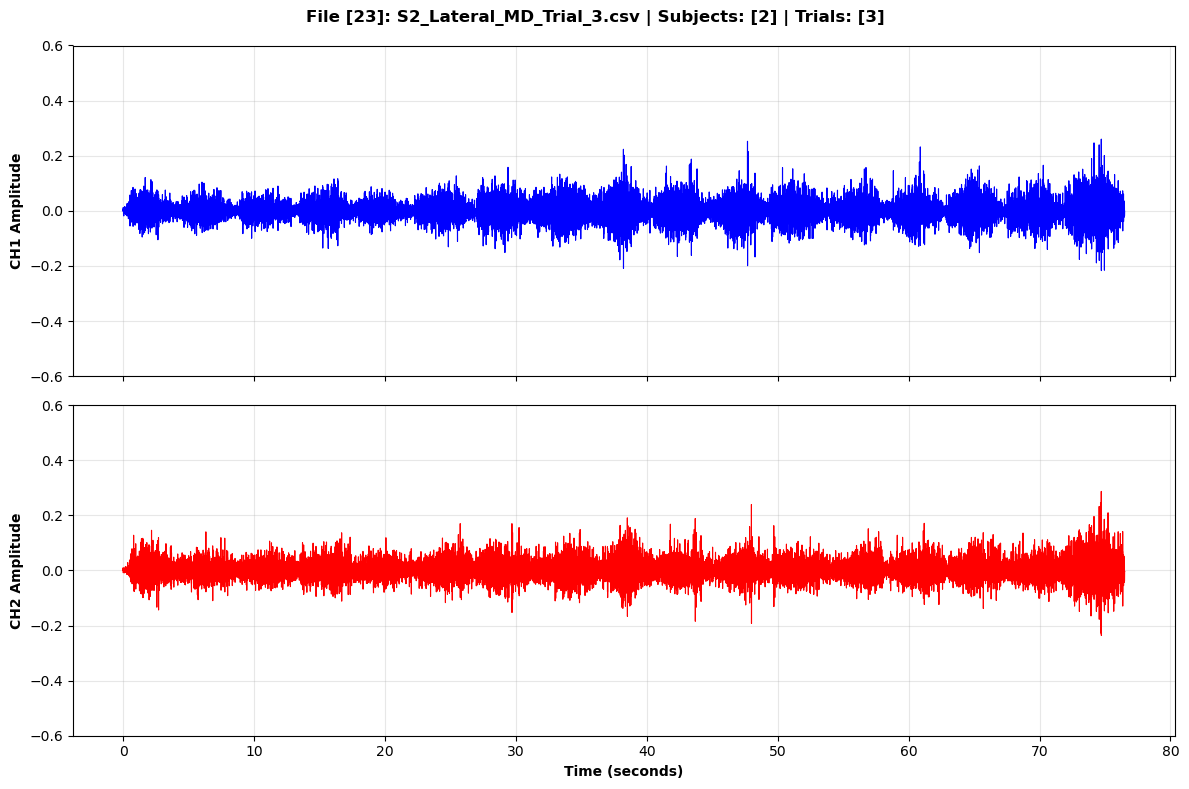

✅ Plotted 153000 samples | Duration: 76.50s | Y-limits: [-0.6, 0.6]


In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

class EMGQuickPlotter:
    """
    Simple EMG plotter for Jupyter notebook workflow
    - Lists all CSV files with indices
    - Select file by index
    - Instant plotting
    - Perfect for re-running cells
    """
    
    def __init__(self, directory_path, sampling_rate=2000):
        self.directory_path = directory_path
        self.sampling_rate = sampling_rate
        self.csv_files = self.get_csv_files()
        
    def get_csv_files(self):
        """Get all CSV files and show them with indices"""
        if not os.path.exists(self.directory_path):
            raise FileNotFoundError(f"Directory not found: {self.directory_path}")
            
        csv_files = glob.glob(os.path.join(self.directory_path, "*.csv"))
        
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in: {self.directory_path}")
        
        # Sort files for consistent indexing
        csv_files.sort()
        
        print("📁 Available CSV Files:")
        print("=" * 50)
        for i, file in enumerate(csv_files):
            print(f"[{i}] {os.path.basename(file)}")
        print("=" * 50)
        
        return csv_files
    
    def load_file(self, file_index):
        """Load specific file by index"""
        if file_index >= len(self.csv_files) or file_index < 0:
            raise IndexError(f"File index {file_index} out of range. Available: 0-{len(self.csv_files)-1}")
        
        file_path = self.csv_files[file_index]
        print(f"📊 Loading: [{file_index}] {os.path.basename(file_path)}")
        
        try:
            data = pd.read_csv(file_path)
        except Exception as e:
            raise Exception(f"Error reading file: {e}")
        
        # Validate columns
        required_cols = ['subject_id', 'trial_index', 'cycle_index', 'ch1_value', 'ch4_value']
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")
        
        return data
    
    def plot_file(self, file_index, subject_id=None, trial_index=None):
        """
        Load and plot file instantly
        
        Args:
            file_index (int): Index of file to plot
            subject_id (str): Optional - specific subject to plot
            trial_index (int): Optional - specific trial to plot
        """
        # Load data
        data = self.load_file(file_index)
        
        # Filter data if specified
        if subject_id is not None:
            data = data[data['subject_id'] == subject_id]
            if data.empty:
                print(f"❌ No data for subject: {subject_id}")
                return
        
        if trial_index is not None:
            data = data[data['trial_index'] == trial_index]
            if data.empty:
                print(f"❌ No data for trial: {trial_index}")
                return
        
        # Sort data
        data = data.sort_values(['subject_id', 'trial_index', 'cycle_index', 'completion_percentage'])
        
        # Create time axis
        time_axis = np.linspace(0, len(data) / self.sampling_rate, len(data))
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Determine y-axis limits based on data range
        ch1_max = abs(data['ch1_value']).max()
        ch4_max = abs(data['ch4_value']).max()
        overall_max = max(ch1_max, ch4_max)
        
        # Set y-limits: [-0.6, 0.6] if data fits, otherwise [-1, 1]
        if overall_max <= 0.6:
            y_limits = [-0.6, 0.6]
        else:
            y_limits = [-1, 1]
        
        # Channel 1 (Blue)
        ax1.plot(time_axis, data['ch1_value'], 'b-', linewidth=0.8)
        ax1.set_ylabel('CH1 Amplitude', fontweight='bold')
        ax1.set_ylim(y_limits)
        ax1.grid(True, alpha=0.3)
        
        # Channel 4 (Red)
        ax2.plot(time_axis, data['ch4_value'], 'r-', linewidth=0.8)
        ax2.set_ylabel('CH2 Amplitude', fontweight='bold')
        ax2.set_xlabel('Time (seconds)', fontweight='bold')
        ax2.set_ylim(y_limits)
        ax2.grid(True, alpha=0.3)
        
        # Title
        file_name = os.path.basename(self.csv_files[file_index])
        subjects = data['subject_id'].unique()
        trials = data['trial_index'].unique() if 'trial_index' in data.columns else ['N/A']
        
        title = f"File [{file_index}]: {file_name}"
        if subject_id: title += f" | Subject: {subject_id}"
        if trial_index: title += f" | Trial: {trial_index}"
        title += f" | Subjects: {list(subjects)} | Trials: {list(trials)}"
        
        fig.suptitle(title, fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Show data info
        print(f"✅ Plotted {len(data)} samples | Duration: {time_axis[-1]:.2f}s | Y-limits: {y_limits}")
        if len(subjects) > 1:
            print(f"💡 Multiple subjects found: {list(subjects)}")
        if len(trials) > 1:
            print(f"💡 Multiple trials found: {list(trials)}")

# =============================================================================
# SIMPLE USAGE FOR JUPYTER
# =============================================================================

# SET YOUR DIRECTORY PATH HERE
DIRECTORY_PATH = r"C:\Users\ezior\Downloads\EMG_Filtered_Cycles"  # ← CHANGE THIS!

# Initialize plotter
plotter = EMGQuickPlotter(DIRECTORY_PATH)

# =============================================================================
# QUICK PLOTTING - CHANGE THESE VALUES AND RE-RUN CELL
# =============================================================================

FILE_INDEX = 23        # ← Change this to select different files
SUBJECT_ID = None       # ← Optional: specify subject (e.g., "s1") or None for all
TRIAL_INDEX = None      # ← Optional: specify trial (e.g., 1) or None for all

# Plot the selected file
plotter.plot_file(FILE_INDEX, SUBJECT_ID, TRIAL_INDEX)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

class EMGQuickPlotter:
    """
    Simple EMG plotter for Jupyter notebook workflow
    - Lists all CSV files with indices
    - Select file by index
    - Instant plotting
    - Perfect for re-running cells
    """
    
    def __init__(self, directory_path, sampling_rate=2000):
        self.directory_path = directory_path
        self.sampling_rate = sampling_rate
        self.csv_files = self.get_csv_files()
        
    def get_csv_files(self):
        """Get all CSV files and show them with indices"""
        if not os.path.exists(self.directory_path):
            raise FileNotFoundError(f"Directory not found: {self.directory_path}")
            
        csv_files = glob.glob(os.path.join(self.directory_path, "*.csv"))
        
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in: {self.directory_path}")
        
        # Sort files for consistent indexing
        csv_files.sort()
        
        print("📁 Available CSV Files:")
        print("=" * 50)
        for i, file in enumerate(csv_files):
            print(f"[{i}] {os.path.basename(file)}")
        print("=" * 50)
        
        return csv_files
    
    def load_file(self, file_index):
        """Load specific file by index"""
        if file_index >= len(self.csv_files) or file_index < 0:
            raise IndexError(f"File index {file_index} out of range. Available: 0-{len(self.csv_files)-1}")
        
        file_path = self.csv_files[file_index]
        print(f"📊 Loading: [{file_index}] {os.path.basename(file_path)}")
        
        try:
            data = pd.read_csv(file_path)
        except Exception as e:
            raise Exception(f"Error reading file: {e}")
        
        # Validate columns
        required_cols = ['subject_id', 'trial_index', 'cycle_index', 'ch1_value', 'ch4_value']
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")
        
        return data
    
    def plot_file(self, file_index, subject_id=None, trial_index=None):
        """
        Load and plot file instantly
        
        Args:
            file_index (int): Index of file to plot
            subject_id (str): Optional - specific subject to plot
            trial_index (int): Optional - specific trial to plot
        """
        # Load data
        data = self.load_file(file_index)
        
        # Filter data if specified
        if subject_id is not None:
            data = data[data['subject_id'] == subject_id]
            if data.empty:
                print(f"❌ No data for subject: {subject_id}")
                return
        
        if trial_index is not None:
            data = data[data['trial_index'] == trial_index]
            if data.empty:
                print(f"❌ No data for trial: {trial_index}")
                return
        
        # Sort data
        data = data.sort_values(['subject_id', 'trial_index', 'cycle_index', 'completion_percentage'])
        
        # Create time axis
        time_axis = np.linspace(0, len(data) / self.sampling_rate, len(data))
        
        # Plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Determine y-axis limits based on data range
        ch1_max = abs(data['ch1_value']).max()
        ch4_max = abs(data['ch4_value']).max()
        overall_max = max(ch1_max, ch4_max)
        
        # Set y-limits: [-0.6, 0.6] if data fits, otherwise [-1, 1]
        if overall_max <= 0.6:
            y_limits = [-0.6, 0.6]
        else:
            y_limits = [-1, 1]
        
        # Channel 1 (Blue)
        ax1.plot(time_axis, data['ch1_value'], 'b-', linewidth=0.8)
        ax1.set_ylabel('CH1 Amplitude', fontweight='bold')
        ax1.set_ylim(y_limits)
        ax1.grid(True, alpha=0.3)
        
        # Channel 4 (Red)
        ax2.plot(time_axis, data['ch4_value'], 'r-', linewidth=0.8)
        ax2.set_ylabel('CH2 Amplitude', fontweight='bold')
        ax2.set_xlabel('Time (seconds)', fontweight='bold')
        ax2.set_ylim(y_limits)
        ax2.grid(True, alpha=0.3)
        
        # Title
        file_name = os.path.basename(self.csv_files[file_index])
        subjects = data['subject_id'].unique()
        trials = data['trial_index'].unique() if 'trial_index' in data.columns else ['N/A']
        
        title = f"File [{file_index}]: {file_name}"
        if subject_id: title += f" | Subject: {subject_id}"
        if trial_index: title += f" | Trial: {trial_index}"
        title += f" | Subjects: {list(subjects)} | Trials: {list(trials)}"
        
        fig.suptitle(title, fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Show data info
        print(f"✅ Plotted {len(data)} samples | Duration: {time_axis[-1]:.2f}s | Y-limits: {y_limits}")
        if len(subjects) > 1:
            print(f"💡 Multiple subjects found: {list(subjects)}")
        if len(trials) > 1:
            print(f"💡 Multiple trials found: {list(trials)}")

# =============================================================================
# SIMPLE USAGE FOR JUPYTER
# =============================================================================

# SET YOUR DIRECTORY PATH HERE
DIRECTORY_PATH = r"C:\Users\ezior\Downloads\EMG_Filtered_Cycles"  # ← CHANGE THIS!

# Initialize plotter
plotter = EMGQuickPlotter(DIRECTORY_PATH)

# =============================================================================
# QUICK PLOTTING - CHANGE THESE VALUES AND RE-RUN CELL
# =============================================================================

FILE_INDEX = 23        # ← Change this to select different files
SUBJECT_ID = None       # ← Optional: specify subject (e.g., "s1") or None for all
TRIAL_INDEX = None      # ← Optional: specify trial (e.g., 1) or None for all

# Plot the selected file
plotter.plot_file(FILE_INDEX, SUBJECT_ID, TRIAL_INDEX)